In [1]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
from openpyxl import load_workbook
import re
import io
import os
import pdb

import sys
sys.path.append(os.path.abspath('../kev/'))

import eq_data
import eq_preproc
import eq_evaluator
import eq_postproc
import eq_writer


# basic input ------------------------------------------------
 
def cl_scripts_load(_sep, _subdir, _file):
    
    # if specific file selected it should be XLSX one
    if _file != "":
        
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        _file = _subdir + _file
        
        # open excel file
        with open(_file, "rb") as f:
            inmemory_file = io.BytesIO(f.read())
        wb = load_workbook(inmemory_file, read_only = True)
                
        r = re.compile(r'heats')
        heats_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], index_col = 0)
        
        r = re.compile(r'targets')
        targets = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None)
        
        r = re.compile(r'enthalpies')
        delta_H = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
        r = re.compile(r'setup')
        setup = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None, index_col = 0)
        
    # use a bunch of plain text files instead
    else:
          
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        file_names = list(os.listdir(path = _subdir))

        r = re.compile(r'heats')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        heats_data = pd.read_csv(file, sep = _sep, index_col = 0, dtype = str)
        heats_data = heats_data.stack().str.replace(',','.').unstack().astype(float)
        
        r = re.compile(r'targets')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        targets = pd.read_csv(file, sep = _sep, header = None)
        
        r = re.compile(r'enthalpies')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        delta_H = pd.read_csv(file, sep = _sep)
        if len(delta_H['Value']) > 0:
            delta_H['Value'] = delta_H['Value'].str.replace(',', '.').astype(float)
        
        r = re.compile(r'setup')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        setup = pd.read_csv(file, sep = _sep, header = None, index_col = 0)
        setup[1][1] = float(setup[1][1].replace(',', '.'))
                
    return heats_data, targets, delta_H, setup

In [2]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np
import re

# basic preprocessing ----------------------------------------
    
def cl_preproc(con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup):
    
    # checking if there are several series
    
    if 'series' not in con_data.columns:        
        con_data['series'] = ''
    
    if 'series' not in heats_data.index:
        heats_data.loc['series'] = '' # probably not needed
    
    if 'volumes' not in heats_data.index:
        heats_data.loc['volumes'] = 1        

    # series variables
    
    ser_info = con_data['series'].to_numpy()
    ser_unique = np.unique(ser_info)
    ser_num = np.shape(np.unique(ser_info))[0]
    
    ser_counts = con_data.groupby(['series']).size().tolist();
    
    # reading volumes from experimental data
    volumes = heats_data.loc['volumes'].to_numpy()
    
    # reading exp heats from experimental data
    heats = heats_data.loc['observation'].to_numpy() - heats_data.loc['dilution'].to_numpy()
        
    # transforming deviation to the matrix form
    devs = heats_data.loc['deviation'].to_numpy()
    devs = np.diag((1 / (np.array(devs) * np.array(devs))) * (np.sum(np.array(devs) * np.array(devs)) / len(devs)))
    
    # creating vector of known enthalpies
    dH_par = np.hstack((np.zeros(len(prod_names_con)), np.transpose(delta_H.drop('Reaction', axis = 1).to_numpy())[0]))
    
    # number of constant to find
    tar_names = set(targets.to_numpy()[0][1:])
    tar_num = [index for index, item in enumerate(prod_names) if item in tar_names]
    
    # number of enthalpy to find
    dH_names = np.hstack((prod_names_con, np.transpose(delta_H.drop('Value', axis = 1).to_numpy())[0]))
    un_el = set(prod_names) - set(dH_names)
    dH_ind_wtf = list([index for index, item in enumerate(prod_names) if item in un_el])
    un_el = set(prod_names) - (set(prod_names) - set(dH_names))
    dH_ind = list([index for index, item in enumerate(prod_names) if item in un_el])
    
    # setup type and initial/active volume
    _calor_setup_type = str(setup.loc['Calorimeter'].to_numpy()[0])
    
    if _calor_setup_type == 'DSC' or _calor_setup_type == 'ampoule':
        vol_init = float(setup.loc['Initial volume'].to_numpy()[0])
    
    else:
        vol_init = float(setup.loc['Active volume'].to_numpy()[0])
   
    # creating array of diff total concentrations
    con_matrix_red = []
    for s in range(ser_num):
        for k in range(ser_counts[s] - 1):
            con_matrix_red.append(con_matrix[int(np.sum(ser_counts[:s])) + k + 1])
            
    if _calor_setup_type == 'DSC' or 'overfilled':
        _calor_setup_type_coeff = [[1] for i in range(len(con_matrix_red))]
    
    if _calor_setup_type == 'ampoule':
        _calor_setup_type_coeff = 1 / np.array(con_matrix_red)[:, idx] 
    
    return (ser_num, ser_counts, ser_info, volumes, heats, devs, tar_num, dH_ind, dH_ind_wtf, dH_par, 
            _calor_setup_type_coeff, _calor_setup_type, vol_init)

In [3]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np

def cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, 
                  dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, vol_init):

    dif_conc = []
    exp_volumes = np.hstack((vol_init, volumes))
    
    for s in range(ser_num):    
        for k in range(ser_counts[s] - 1):
            
            if _calor_setup_type == 'overfilled':
                factor = 1 - (volumes[int(np.sum(ser_counts[:s])) + k - s] / vol_init)
            else:
                factor = 1
            
            dif_conc.append(c_res_out[int(np.sum(ser_counts[:s])) + k + 1] - (c_res_out[int(np.sum(ser_counts[:s])) + k]
                            * factor * (exp_volumes[int(np.sum(ser_counts[:s])) + k] / 
                                        exp_volumes[int(np.sum(ser_counts[:s])) + k + 1])))
            
    dif_conc, devs, volumes = np.array(dif_conc).astype(np.float64), devs.astype(np.float64), volumes.astype(np.float64)
    
#     pdb.set_trace()
    
    # finding vector of experimental values
    
    q_corr = deepcopy(heats)
    
    for i in range(len(heats)):
        for j in range(len(volumes[dH_ind])):
            
            if _calor_setup_type == 'overfilled':
                q_corr[i] -= vol_init * dif_conc[i, dH_ind[j]] * dH_par[j] 
            else:
                q_corr[i] -= volumes[dH_ind[j]] * dif_conc[i, dH_ind[j]] * dH_par[j] 
    
    # solving the system of linear algebraic eqs, where dH are unknown variables, and product of volumes and dif conc are
    # the coefficients
    
    if _calor_setup_type == 'overfilled':
        A = (vol_init * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff)
    
    else:
        A = ((np.array(volumes).reshape((len(volumes), 1)) * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff))
    
    AT = np.transpose(A)
    LTP = np.linalg.inv(np.dot(np.dot(AT, devs), A).astype(np.float64))
    RTP = np.dot(np.dot(AT, devs), q_corr)
    dH_res = np.dot(LTP, RTP)
    dH_res_tmp = dH_par

#     pdb.set_trace()
    
#     dH_res = np.linalg.lstsq(A, q_corr.astype(np.float64))[0]
#     dH_res_tmp = dH_par
    
    for i in range(len(dH_ind_wtf)):
        dH_res_tmp = np.insert(dH_res_tmp, dH_ind_wtf[i], dH_res[i])

    dH_res_out = dH_res_tmp

     # finding F_min
        
    F_min, heats_calc = 0, []
    
    for i in range(len(heats)): 
          
        if _calor_setup_type == 'overfilled':
            F_min += (vol_init * np.sum(dH_res_out * dif_conc[i] * np.array(_calor_setup_type_coeff[i])) - heats[i]) ** 2
            
            heats_calc.append((np.sum(dH_res_out * dif_conc[i] * vol_init * _calor_setup_type_coeff[i])))
        
        else:
            F_min += (np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i])) - heats[i]) ** 2
            
            heats_calc.append(np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i])))

    # calculating st. dev. of dH_res / checking the quality of linear regression
    
    disp = (F_min / (len(heats) - len(dH_ind_wtf)) * (np.diag(LTP))) ** 0.5  
    
    return F_min, dH_res_out, disp, heats_calc

In [4]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

from copy import deepcopy
import eq_evaluator
# import also script cl_enthalpies when needed

# main Hooke-Jeeves function --------------------------------

def cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init):

    # initial step
    
    basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, 
                                                                 st_coeff_matrix, type_con, con_matrix, ign_indices, 
                                                                 ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par,
                                                                 dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, 
                                                                 vol_init)
    
    basis_point_n = deepcopy(lg_k)
    
    print(new_min)

    # algorithm body
    
    for i in range(max_iter):
        
        print('\niteration', i, lg_k[tar_num])
        
        # check success of the previous step (i.e. estimation takes place
        # in the beginning of the iteration and not in the end)
        
        if F_min <= new_min:
        
            # fail ------------ #
        
            if step_init < HJ_eps:
                
                # exit 1: HS epsilon (lg_k move absolute threshold) achieved
                    
                print("p1 " + str(step_init) + " " + str(HJ_eps))
                break
            
            else:
                
                # reduce step and try exploratory move
                
                step_init /= 2
            
                basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps,
                                                                             ser_num, st_coeff_matrix, type_con, con_matrix,
                                                                             ign_indices, ser_counts, ser_info, devs, 
                                                                             volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                                             _calor_setup_type_coeff, _calor_setup_type, 
                                                                             vol_init)
                print('\nF min more ', new_min, F_min, lg_k[tar_num])
                print(str(step_init))
        else:
            
            # success --------- #
            
            F_min = deepcopy(new_min)
            
            print('\nF min less', new_min, F_min, lg_k[tar_num])
            print(str(step_init))
            
            # first HS move
            
            basis_point_n = deepcopy(lg_k)
            lg_k[tar_num] = basis_point[tar_num] + 2 * (lg_k[tar_num] - basis_point[tar_num])

            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                    con_matrix, ign_indices)

            new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                  dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                  _calor_setup_type, vol_init)
            print('\nF min less after', new_min, F_min, lg_k[tar_num])
        
            # check success of the HS move
        
            if F_min <= new_min:
                lg_k = deepcopy(basis_point_n)
                print('\nconstant less after', basis_point[tar_num], lg_k[tar_num]) 
            else:
                F_min = new_min

            basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps,
                                                                         ser_num, st_coeff_matrix, type_con, con_matrix,
                                                                         ign_indices, ser_counts, ser_info, devs,
                                                                         volumes, heats, dH_ind, dH_par, dH_ind_wtf,
                                                                         _calor_setup_type_coeff, _calor_setup_type, 
                                                                         vol_init)
        
    # calculate additional data to return

    c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                       con_matrix, ign_indices)
    new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                          dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                          vol_init)

    
    return F_min, lg_k, dH_res_out, c_res_out, disp


# exploratory move function used in main function ------------------------

def cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init):

    basis_point = deepcopy(lg_k)
    
    c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                con_matrix, ign_indices)

    new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                          dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                          vol_init)

    #if F_min > new_min:
    F_min = new_min
    
    for j in range(len(tar_num)): 
        #pdb.set_trace()
        print('input', lg_k[tar_num[j]], F_min)
        
        # move right ---------------- #
        
        lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
        
        # equilibrium
        c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)
        
        # enthalpies
        new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                              dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                              vol_init)
        
        print('right', lg_k[tar_num[j]], new_min, F_min)
        
        if F_min <= new_min:
            
            # move left ------------- #
            
            lg_k[tar_num[j]] = lg_k[tar_num[j]] - 2 * step_init
            
            # equilibrium
            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                        con_matrix, ign_indices)
        
            # enthalpies
            new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, 
                                                                  dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                  _calor_setup_type, vol_init)
            
            print('left', lg_k[tar_num[j]], new_min, F_min)
            
            # restore initial value - #
            # if move failed -------- #
            
            if F_min <= new_min:
                
                lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
                new_min = deepcopy(F_min)
                
    print('return', basis_point[tar_num[j]], lg_k[tar_num[j]])
    
    return basis_point, lg_k, new_min, c_res_out, disp

In [5]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------
import numpy as np
import eq_evaluator
# import also script cl_enthalpies when needed

def cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix, type_con, con_matrix,
                      ign_indices, ser_num, ser_counts, devs, volumes, dH_ind, dH_par, dH_ind_wtf, 
                      _calor_setup_type_coeff, _calor_setup_type, vol_init):
    
    # creating constants vectors ---------------------------------
    lg_k_1, lg_k_2 = np.array(lg_k), np.array(lg_k)
    heats_one, heats_two = [0] * len(heats), [0] * len(heats)
    jc_mtrx = [[0] * len(heats) for i in range(len(tar_num))]
    comment = ['0'] * len(tar_num)
    
    for i in range(len(tar_num)):
        # calculating the heats for Jacobi matrix computing
        lg_k_1[tar_num[i]] += HJ_eps
        lg_k_2[tar_num[i]] -= HJ_eps
    
        # if lg_k is overestimated
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_1,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                   dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                   _calor_setup_type, vol_init)
        
        new_min_over = new_min
        
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])
    
        for o in range(len(heats)):
            heats_one[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
    
        # if lg_k is underestimated    
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_2,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                   dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                   _calor_setup_type, vol_init)
        
        new_min_under = new_min
        
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])    
   
        for o in range(len(heats)):
            heats_two[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
            
        # checking if optimization reached minimum
        
        if (new_min_over - new_min_under) / (2 * HJ_eps) == 0:
            comment[i] = 'Non-sensitive'
        
        else:
            c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                        con_matrix, ign_indices)
    
            new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                       dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                       _calor_setup_type, vol_init)
            
            if new_min_over < new_min:
                comment[i] = 'Inf'
        
            if new_min_under < new_min:
                comment[i] = '-Inf'
                
        # calculating the Jacobi matrix    
        jc_mtrx[i] = (np.array(heats_one) - np.array(heats_two)) / (2 * HJ_eps)

    jc_mtrx, devs = np.array(jc_mtrx).astype(np.float64), devs.astype(np.float64)

    cov_matrix = (F_min / (len(heats) - len(tar_num))) * np.linalg.inv(np.dot(np.dot(jc_mtrx, devs), np.transpose(jc_mtrx)))

    errs_values = np.diag(cov_matrix) ** 0.5
    
    pearson_matrix = [[0] * np.shape(cov_matrix)[0] for i in range(np.shape(cov_matrix)[0])]
    
    for i in range(np.shape(cov_matrix)[0]):
        for j in range(np.shape(cov_matrix)[1]):
            pearson_matrix[i][j] = cov_matrix[i][j] / (errs_values[i] * errs_values[j]) 
    
    for i in range(len(tar_num)):
        if errs_values[i] >= lg_k[tar_num[i]] * 0.1:
            comment[i] = 'Insignificant'
        if comment[i] != 'Non-sensitive' or comment[i] != 'Inf' or comment[i] != '-Inf' or comment[i] != 'Insignificant':
            comment[i] = 'OK'
    
    return errs_values, comment, pearson_matrix

In [6]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------
import numpy as np
import pandas as pd

def cl_postproc(lg_k, tar_num, errs_values, comment, disp, prod_names, heats, heats_calc, pearson_matrix, dH_res_out):
    lg_k_errs, commentary, dH_res_errs = [0] * len(lg_k), ['OK'] * len(lg_k), [0] * len(lg_k) 

    for i in range(len(tar_num)):
        lg_k_errs[tar_num[i]], commentary[tar_num[i]], dH_res_errs[tar_num[i]]  = errs_values[i], comment[i], disp[i]

    # optimized constants
    lg_k_opt = np.hstack((np.hstack((lg_k, np.array(lg_k_errs).reshape(len(lg_k_errs), 1))), np.array(commentary).reshape(len(commentary), 1)))
    lg_k_opt = np.hstack(((np.array(prod_names).reshape(len(prod_names), 1)), lg_k_opt))
    lg_k_opt = pd.DataFrame(lg_k_opt, columns = ['Component', 'Constant', 'St.Deviation', 'Validity'])

    # calc heats, abs devs
    abs_dev = heats - heats_calc
    heats_ad = np.vstack((np.vstack((np.array(heats_data.columns), heats)), abs_dev))
    ind_heats = [['data'], ['observation'], ['deviation']]
    heats_ad = pd.DataFrame(np.hstack((ind_heats, heats_ad)))

    # calc heats, rel devs
    rel_dev = abs(heats - heats_calc) / heats
    heats_rd = np.vstack((np.vstack((np.array(heats_data.columns), heats)), rel_dev))
    ind_heats = [['data'], ['observation'], ['deviation']]
    heats_rd = pd.DataFrame(np.hstack((ind_heats, heats_rd)))

    # corr matrix
    pearson_matrix_out = pd.DataFrame(pearson_matrix, columns = np.array(prod_names)[tar_num], index = np.array(prod_names)[tar_num])

    # enthalpies
    enth_out = pd.DataFrame(np.hstack((ind_heats, np.vstack((prod_names, np.vstack((dH_res_out, dH_res_errs)))))))
    
    return lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out

In [7]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
import sys
from pathlib import Path
sys.path.append(os.path.abspath('../kev/'))

def cl_output(_sep, _subdir, _file_out, results_stoich_coeff, lg_k_data, c_inp_out, c_res_out, 
              component_name_for_yields, comp_name_res, lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out):

    if _subdir != '':
        _subdir = '/' + _subdir
    _subdir = '../../output' + _subdir + '/'
    
    path = Path(_subdir)
    if not path.exists():    
        path.mkdir(parents = True, exist_ok = True)
        
    # single file (xlsx)
    
    if _file_out != "":
        
        _file_out = _subdir + _file_out
    
        # output
        with pd.ExcelWriter(_file_out, mode = "w") as output: # specify the path!
            results_stoich_coeff.to_excel(output, sheet_name = 'input_stoich_coefficients', index = False)
            lg_k_data.to_excel(output, sheet_name = 'input_k_constants_log10', index = False)
            c_inp_out.to_excel(output, sheet_name = 'input_concentrations', header = None, index = False)
            c_res_out.to_excel(output, sheet_name = 'equilibrium_concentrations', index = False)
            comp_name_res.to_excel(output, sheet_name = 'component_names', header = None, index = False)
            heats_ad.to_excel(output, sheet_name = 'heats_calc_abs_errors', header = None, index = False)
            heats_rd.to_excel(output, sheet_name = 'heats_calc_rel_errors', header = None, index = False)
            lg_k_opt.to_excel(output, sheet_name = 'constants_evaluated', header = None, index = False)
            pearson_matrix_out.to_excel(output, sheet_name = 'correlation_matrix')
            enth_out.to_excel(output, sheet_name = 'enthalpies_calc', header = None, index = False)
    else:
        
        # multiple files (plain files)
        
        _file_out = _subdir + 'stoich_coefficients.csv'
        results_stoich_coeff.to_csv(_file_out, sep = _sep, index = False)
        
        _file_out = _subdir + 'k_constants_log10.csv'
        lg_k_data.to_csv(_file_out, sep = _sep, index = False)
        
        _file_out = _subdir + 'input_concentrations.csv'
        c_inp_out.to_csv(_file_out, sep = _sep, header = None, index = False)
        
        _file_out = _subdir + 'equilibrium_concentrations.csv'
        c_res_out.to_csv(_file_out, sep = _sep, index = False)
        
        _file_out = _subdir + 'component_names.csv'
        comp_name_res.to_csv(_file_out, sep = _sep, header = None, index = False)
        
        _file_out = _subdir + 'heats_calc_abs_errors.csv'
        heats_ad.to_csv(_file_out, sep = _sep, header = None, index = False)
        
        _file_out = _subdir + 'heats_calc_rel_errors.csv'
        heats_ad.to_csv(_file_out, sep = _sep, header = None, index = False)
        
        _file_out = _subdir + 'constants_evaluated.csv'
        lg_k_opt.to_csv(_file_out, sep = _sep, header = None, index = False)
        
        _file_out = _subdir + 'correlation_matrix.csv'
        pearson_matrix_out.to_csv(_file_out, sep = _sep)
        
        _file_out = _subdir + 'enthalpies_calc.csv'
        enth_out.to_csv(_file_out, sep = _sep, header = None, index = False)

In [8]:
# input for xlsx file

_subdir = "calorimetry"
_sep = ";"
_file = "test_6_rounded_2.xlsx"
_file_out = "test_6_rounded_2.xlsx"

# _subdir = "calorimetry/test_1_csv"
# _sep = ";"
# _file = ""
# _file_out = ""

# algo parameters
max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5


# load data

st_coeff_data, lg_k_data, con_data, type_con, component_name_for_yields = eq_data.eq_scripts_load(_sep, _subdir, _file)
heats_data, targets, delta_H, setup = cl_scripts_load(_sep, _subdir, _file)

# preproc

st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, idx, type_con = eq_preproc.eq_preproc(
    st_coeff_data, con_data, type_con, lg_k_data, component_name_for_yields)

(ser_num, ser_counts, ser_info, volumes, heats, devs, 
 tar_num, dH_ind, dH_ind_wtf, dH_par, _calor_setup_type_coeff, _calor_setup_type, vol_init) = cl_preproc(
    con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup)

# pdb.set_trace()

# calculation of eq concentration (starting point)
c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)

# calculation of F_min and unknown enthalpies (starting point)
F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type, vol_init)

# F_min assignment for further calculations
new_min = F_min

# constant refinment
if len(tar_num) > 0:
    F_min, lg_k, dH_res_out, c_res_out, disp = cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init)


F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par,
                                                    dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, vol_init)

# error estimation
if len(tar_num) > 0:
    errs_values, comment, pearson_matrix = cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix,
                                                             type_con, con_matrix, ign_indices, ser_num, ser_counts, devs, 
                                                             volumes, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                             _calor_setup_type, vol_init)

# postproc
(c_inp_out, c_res_out, c_yie_out, g_res_out,
 comp_name_res, results_stoich_coeff) = eq_postproc.eq_postproc(st_coeff_matrix, con_matrix, idx, c_res_out, g_res_out,
                                                                con_data, st_coeff_data, prod_names, prod_names_con, 
                                                                component_name_for_yields, type_con, ign_indices)
lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out = cl_postproc(lg_k, tar_num, errs_values, comment, disp, 
                                                                         prod_names, heats, heats_calc, pearson_matrix,
                                                                         dH_res_out)

# writing into excel file
cl_output(_sep, _subdir, _file_out, results_stoich_coeff, lg_k_data, c_inp_out, c_res_out, 
              component_name_for_yields, comp_name_res, lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out)

dif_conc_1
[[ 4.80628320e-04 -1.83969371e-04  1.83089392e-04  8.79979466e-07]
 [ 4.89944406e-04 -1.71891503e-04  1.69355053e-04  2.53644917e-06]
 [ 4.98584211e-04 -1.60642441e-04  1.56598382e-04  4.04405933e-06]
 [ 5.06577511e-04 -1.50184245e-04  1.44773290e-04  5.41095527e-06]
 [ 5.13957374e-04 -1.40475154e-04  1.33829341e-04  6.64581344e-06]
 [ 5.20758802e-04 -1.31471229e-04  1.23713676e-04  7.75755243e-06]
 [ 5.27017636e-04 -1.23127680e-04  1.14372578e-04  8.75510196e-06]
 [ 5.32769686e-04 -1.15399917e-04  1.05752692e-04  9.64722517e-06]
 [ 5.38050067e-04 -1.08244342e-04  9.78019551e-05  1.04423875e-05]
 [ 5.42892717e-04 -1.01618924e-04  9.04702599e-05  1.11486651e-05]
 [ 5.47330058e-04 -9.54835943e-05  8.37099123e-05  1.17736851e-05]
 [ 5.51392783e-04 -8.98004994e-05  7.74759147e-05  1.23245919e-05]
 [ 5.55109729e-04 -8.45341349e-05  7.17261169e-05  1.28080331e-05]
 [ 5.58507834e-04 -7.96513949e-05  6.64212644e-05  1.32301605e-05]
 [ 5.61612135e-04 -7.51215557e-05  6.15249705e-05  

enth
[0.0 0.0 8.865808989829363 26.037824245963094]

F min less after 0.00021517975897138327 1.4580399521140218e-06 [[4.]
 [5.]]

constant less after [[3.]
 [4.]] [[3.5]
 [4.5]]
dif_conc_1
[[ 5.67983087e-05 -6.08334034e-04  6.07988707e-04  3.45327303e-07]
 [ 7.80535623e-05 -5.85058886e-04  5.83798977e-04  1.25990913e-06]
 [ 1.10600751e-04 -5.50016016e-04  5.47362072e-04  2.65394411e-06]
 [ 1.60104662e-04 -4.97306019e-04  4.92543989e-04  4.76203042e-06]
 [ 2.30799246e-04 -4.22531514e-04  4.14783933e-04  7.74758123e-06]
 [ 3.18044001e-04 -3.30559938e-04  3.19176294e-04  1.13836441e-05]
 [ 4.04929645e-04 -2.39046519e-04  2.24122266e-04  1.49242536e-05]
 [ 4.74760601e-04 -1.65396359e-04  1.47736491e-04  1.76598681e-05]
 [ 5.23245445e-04 -1.14059175e-04  9.46269983e-05  1.94321773e-05]
 [ 5.54798077e-04 -8.04075593e-05  5.99528924e-05  2.04546698e-05]
 [ 5.75122892e-04 -5.84773989e-05  3.74903614e-05  2.09870477e-05]
 [ 5.88412154e-04 -4.38886510e-05  2.26716111e-05  2.12170713e-05]
 [ 5.97

dif_conc_1
[[ 9.36453156e-05 -5.70883257e-04  5.69934160e-04  9.49097317e-07]
 [ 1.22314077e-04 -5.38767316e-04  5.35476352e-04  3.29096473e-06]
 [ 1.61094306e-04 -4.95748245e-04  4.89320086e-04  6.42815982e-06]
 [ 2.11419170e-04 -4.40306272e-04  4.29859003e-04  1.04472702e-05]
 [ 2.71848523e-04 -3.74042932e-04  3.58856048e-04  1.51868871e-05]
 [ 3.36734189e-04 -3.03110887e-04  2.82968387e-04  2.01425079e-05]
 [ 3.98060725e-04 -2.36198094e-04  2.11556528e-04  2.46415978e-05]
 [ 4.49701876e-04 -1.79911938e-04  1.51709063e-04  2.82030010e-05]
 [ 4.89725531e-04 -1.36300163e-04  1.05588879e-04  3.07111139e-05]
 [ 5.19334913e-04 -1.04017759e-04  7.17101242e-05  3.23076345e-05]
 [ 5.40848690e-04 -8.05235964e-05  4.73085441e-05  3.32150523e-05]
 [ 5.56477111e-04 -6.34051074e-05  2.97694486e-05  3.36356588e-05]
 [ 5.67934041e-04 -5.07951788e-05  1.70724939e-05  3.37226850e-05]
 [ 5.76442788e-04 -4.13628288e-05  7.77904156e-06  3.35837874e-05]
 [ 5.82849790e-04 -3.41880879e-05  8.95608050e-07  

dif_conc_1
[[ 5.67983087e-05 -6.08334034e-04  6.07988707e-04  3.45327303e-07]
 [ 7.80535623e-05 -5.85058886e-04  5.83798977e-04  1.25990913e-06]
 [ 1.10600751e-04 -5.50016016e-04  5.47362072e-04  2.65394411e-06]
 [ 1.60104662e-04 -4.97306019e-04  4.92543989e-04  4.76203042e-06]
 [ 2.30799246e-04 -4.22531514e-04  4.14783933e-04  7.74758123e-06]
 [ 3.18044001e-04 -3.30559938e-04  3.19176294e-04  1.13836441e-05]
 [ 4.04929645e-04 -2.39046519e-04  2.24122266e-04  1.49242536e-05]
 [ 4.74760601e-04 -1.65396359e-04  1.47736491e-04  1.76598681e-05]
 [ 5.23245445e-04 -1.14059175e-04  9.46269983e-05  1.94321773e-05]
 [ 5.54798077e-04 -8.04075593e-05  5.99528924e-05  2.04546698e-05]
 [ 5.75122892e-04 -5.84773989e-05  3.74903614e-05  2.09870477e-05]
 [ 5.88412154e-04 -4.38886510e-05  2.26716111e-05  2.12170713e-05]
 [ 5.97298617e-04 -3.38916240e-05  1.26300432e-05  2.12616636e-05]
 [ 6.03371132e-04 -2.68273006e-05  5.63652188e-06  2.11909723e-05]
 [ 6.07593107e-04 -2.16899792e-05  6.42383710e-07  

dif_conc_1
[[ 6.45059440e-05 -6.00177761e-04  5.99383840e-04  7.93971228e-07]
 [ 8.74163063e-05 -5.74102284e-04  5.71248472e-04  2.85376184e-06]
 [ 1.21269087e-04 -5.36128898e-04  5.30256171e-04  5.87272694e-06]
 [ 1.70313050e-04 -4.81660776e-04  4.71461891e-04  1.01988849e-05]
 [ 2.36488766e-04 -4.08646454e-04  3.92703333e-04  1.59431214e-05]
 [ 3.14352037e-04 -3.23102503e-04  3.00569460e-04  2.25330432e-05]
 [ 3.90576605e-04 -2.39602833e-04  2.10881854e-04  2.87209791e-05]
 [ 4.53071031e-04 -1.71296797e-04  1.37847796e-04  3.34490010e-05]
 [ 4.98399896e-04 -1.21848594e-04  8.53602862e-05  3.64883076e-05]
 [ 5.29428470e-04 -8.80594215e-05  4.98870081e-05  3.81724144e-05]
 [ 5.50418275e-04 -6.52347951e-05  2.63005304e-05  3.89342687e-05]
 [ 5.64791887e-04 -4.96167064e-05  1.05074365e-05  3.91092838e-05]
 [ 5.74851193e-04 -3.86819740e-05 -2.36723466e-07  3.89187385e-05]
 [ 5.82060037e-04 -3.08280451e-05 -7.67317567e-06  3.85013266e-05]
 [ 5.87342187e-04 -2.50448359e-05 -1.28986606e-05  

dif_conc_1
[[ 5.67318809e-05 -6.08038247e-04  6.07330705e-04  7.07542319e-07]
 [ 7.77245876e-05 -5.84076728e-04  5.81505686e-04  2.57104208e-06]
 [ 1.09619085e-04 -5.48270113e-04  5.42888600e-04  5.38151275e-06]
 [ 1.57608708e-04 -4.94995467e-04  4.85426932e-04  9.56853583e-06]
 [ 2.25279401e-04 -4.20412832e-04  4.05026723e-04  1.53861085e-05]
 [ 3.07942422e-04 -3.29719677e-04  3.07394193e-04  2.23254842e-05]
 [ 3.90088371e-04 -2.39863706e-04  2.10915366e-04  2.89483404e-05]
 [ 4.56639241e-04 -1.67230687e-04  1.33283787e-04  3.39469000e-05]
 [ 5.03558643e-04 -1.16124135e-04  7.90701173e-05  3.70540192e-05]
 [ 5.34679470e-04 -8.22877212e-05  4.35946138e-05  3.86931148e-05]
 [ 5.55161653e-04 -6.00521615e-05  2.06786643e-05  3.93735246e-05]
 [ 5.68885674e-04 -4.51657246e-05  5.69932875e-06  3.94664800e-05]
 [ 5.78330265e-04 -3.49165945e-05 -4.28823531e-06  3.92050525e-05]
 [ 5.85010531e-04 -2.76491477e-05 -1.10809141e-05  3.87297190e-05]
 [ 5.89854176e-04 -2.23506731e-05 -1.57748362e-05  

dif_conc_1
[[ 5.85981110e-05 -6.06176723e-04  6.05473887e-04  7.02836057e-07]
 [ 8.00865636e-05 -5.81737900e-04  5.79190006e-04  2.54789391e-06]
 [ 1.12529909e-04 -5.45427629e-04  5.40114455e-04  5.31317320e-06]
 [ 1.60922349e-04 -4.91853008e-04  4.82455652e-04  9.39735553e-06]
 [ 2.28457384e-04 -4.17606695e-04  4.02592431e-04  1.50142635e-05]
 [ 3.10211784e-04 -3.28119496e-04  3.06463194e-04  2.16563026e-05]
 [ 3.91143757e-04 -2.39779847e-04  2.11803033e-04  2.79768138e-05]
 [ 4.56876078e-04 -1.68171030e-04  1.35401310e-04  3.27697200e-05]
 [ 5.03509709e-04 -1.17443894e-04  8.16607016e-05  3.57831935e-05]
 [ 5.34648835e-04 -8.36083621e-05  4.62052577e-05  3.74031087e-05]
 [ 5.55253453e-04 -6.12306998e-05  2.31275305e-05  3.81031855e-05]
 [ 5.69110188e-04 -4.61737706e-05  7.93990237e-06  3.82339193e-05]
 [ 5.78666386e-04 -3.57675186e-05 -2.25034640e-06  3.80180038e-05]
 [ 5.85431392e-04 -2.83670686e-05 -9.22408281e-06  3.75909406e-05]
 [ 5.90335619e-04 -2.29594530e-05 -1.40758340e-05  

dif_conc_1
[[ 5.67408524e-05 -6.08078198e-04  6.07419579e-04  6.58619586e-07]
 [ 7.77688578e-05 -5.84208931e-04  5.81814363e-04  2.39456868e-06]
 [ 1.09750445e-04 -5.48503869e-04  5.43487473e-04  5.01639625e-06]
 [ 1.57940058e-04 -4.95302495e-04  4.86372338e-04  8.93015788e-06]
 [ 2.26005087e-04 -4.20691488e-04  4.06309721e-04  1.43817671e-05]
 [ 3.09257744e-04 -3.29827617e-04  3.08925396e-04  2.09022215e-05]
 [ 3.92005864e-04 -2.39753280e-04  2.12612006e-04  2.71412740e-05]
 [ 4.58965805e-04 -1.66986870e-04  1.35122718e-04  3.18641525e-05]
 [ 5.06070604e-04 -1.15850545e-04  8.10348982e-05  3.48156480e-05]
 [ 5.37229159e-04 -8.20393174e-05  4.56474942e-05  3.63918297e-05]
 [ 5.57672644e-04 -5.98449752e-05  2.27752796e-05  3.70697197e-05]
 [ 5.71322579e-04 -4.49986891e-05  7.80215382e-06  3.71966094e-05]
 [ 5.80678055e-04 -3.47835481e-05 -2.20656245e-06  3.69903069e-05]
 [ 5.87263925e-04 -2.75434595e-05 -9.03885825e-06  3.65820157e-05]
 [ 5.92012585e-04 -2.22666459e-05 -1.37844824e-05  

enth
[0.0 0.0 9.97638625212939 13.216286983182702]
right [4.78320312] 1.0828344939092504e-06 1.084229408786766e-06
return [4.78125] [4.78320312]

F min more  1.0828344939092504e-06 1.084229408786766e-06 [[3.50195312]
 [4.78320312]]
0.001953125

iteration 12 [[3.50195312]
 [4.78320312]]

F min less 1.0828344939092504e-06 1.0828344939092504e-06 [[3.50195312]
 [4.78320312]]
0.001953125
dif_conc_1
[[ 5.62836804e-05 -6.08540175e-04  6.07886360e-04  6.53815010e-07]
 [ 7.71924051e-05 -5.84801302e-04  5.82422651e-04  2.37865085e-06]
 [ 1.09046234e-04 -5.49236278e-04  5.44248079e-04  4.98819918e-06]
 [ 1.57156388e-04 -4.96123295e-04  4.87230267e-04  8.89302851e-06]
 [ 2.25301115e-04 -4.21429264e-04  4.07081302e-04  1.43479626e-05]
 [ 3.08856813e-04 -3.30241717e-04  3.09352664e-04  2.08890529e-05]
 [ 3.91989572e-04 -2.39756247e-04  2.12601649e-04  2.71545986e-05]
 [ 4.59207377e-04 -1.66715800e-04  1.34822149e-04  3.18936512e-05]
 [ 5.06404867e-04 -1.15483195e-04  8.06344611e-05  3.48487354e-05]


 [ 6.02552296e-04 -9.56223832e-06 -2.34095952e-05  3.29718336e-05]]
enth
[0.0 0.0 9.976725380971944 13.188703311567512]
input [3.50195312] 1.081751848011775e-06
dif_conc_1
[[ 5.62831464e-05 -6.08537774e-04  6.07881024e-04  6.56749997e-07]
 [ 7.71897649e-05 -5.84793342e-04  5.82404092e-04  2.38925067e-06]
 [ 1.09038375e-04 -5.49222165e-04  5.44211994e-04  5.01017105e-06]
 [ 1.57136479e-04 -4.96104687e-04  4.87173141e-04  8.93154595e-06]
 [ 2.25257287e-04 -4.21412297e-04  4.07003540e-04  1.44087573e-05]
 [ 3.08777008e-04 -3.30235095e-04  3.09259615e-04  2.09754802e-05]
 [ 3.91872895e-04 -2.39762928e-04  2.12498334e-04  2.72645946e-05]
 [ 4.59065623e-04 -1.66730591e-04  1.34709978e-04  3.20206137e-05]
 [ 5.06251714e-04 -1.15499771e-04  8.05144613e-05  3.49853113e-05]
 [ 5.37405322e-04 -8.16926058e-05  4.51302356e-05  3.65623777e-05]
 [ 5.57813611e-04 -5.95381835e-05  2.23026664e-05  3.72355444e-05]
 [ 5.71424272e-04 -4.47379769e-05  7.38243054e-06  3.73556295e-05]
 [ 5.80745297e-04 -3.456

dif_conc_1
[[ 5.65091396e-05 -6.08297456e-04  6.07626381e-04  6.71074816e-07]
 [ 7.74667879e-05 -5.84465324e-04  5.82025078e-04  2.44024611e-06]
 [ 1.09358103e-04 -5.48799204e-04  5.43685800e-04  5.11340446e-06]
 [ 1.57447232e-04 -4.95619300e-04  4.86513120e-04  9.10617953e-06]
 [ 2.25431722e-04 -4.20975006e-04  4.06303392e-04  1.46716140e-05]
 [ 3.08654954e-04 -3.30001455e-04  3.08670281e-04  2.13311741e-05]
 [ 3.91410038e-04 -2.39788644e-04  2.12086907e-04  2.77017362e-05]
 [ 4.58372925e-04 -1.66926093e-04  1.34408284e-04  3.25178095e-05]
 [ 5.05466912e-04 -1.15750573e-04  8.02312633e-05  3.55193115e-05]
 [ 5.36612316e-04 -8.19342892e-05  4.48205959e-05  3.71137006e-05]
 [ 5.57048554e-04 -5.97484797e-05  2.19582018e-05  3.77903044e-05]
 [ 5.70698923e-04 -4.49141595e-05  7.00944512e-06  3.79047956e-05]
 [ 5.80061376e-04 -3.47105711e-05 -2.96917765e-06  3.76799633e-05]
 [ 5.86659028e-04 -2.74805000e-05 -9.76970147e-06  3.72498707e-05]
 [ 5.91422738e-04 -2.22120386e-05 -1.44835434e-05  

dif_conc_1
[[ 5.62798921e-05 -6.08523141e-04  6.07848503e-04  6.74637507e-07]
 [ 7.71736780e-05 -5.84744843e-04  5.82291005e-04  2.45383720e-06]
 [ 1.08990511e-04 -5.49136199e-04  5.43992198e-04  5.14400103e-06]
 [ 1.57015280e-04 -4.95991398e-04  4.86825364e-04  9.16603354e-06]
 [ 2.24990652e-04 -4.21309068e-04  4.06530446e-04  1.47786218e-05]
 [ 3.08291790e-04 -3.30194868e-04  3.08693944e-04  2.15009243e-05]
 [ 3.91163849e-04 -2.39803643e-04  2.11870718e-04  2.79329255e-05]
 [ 4.58204520e-04 -1.66820643e-04  1.34028978e-04  3.27916652e-05]
 [ 5.05321726e-04 -1.15600668e-04  7.97862674e-05  3.58144025e-05]
 [ 5.36461165e-04 -8.17840681e-05  4.43690036e-05  3.74150724e-05]
 [ 5.56883494e-04 -5.96143789e-05  2.15249418e-05  3.80894657e-05]
 [ 5.70521221e-04 -4.47993616e-05  6.60215275e-06  3.81972959e-05]
 [ 5.79874840e-04 -3.46135104e-05 -3.34982153e-06  3.79635611e-05]
 [ 5.86467479e-04 -2.73984214e-05 -1.01254303e-05  3.75234977e-05]
 [ 5.91229307e-04 -2.21422352e-05 -1.48165811e-05  

dif_conc_1
[[ 5.60509222e-05 -6.08745487e-04  6.08064226e-04  6.81260903e-07]
 [ 7.68787335e-05 -5.85015140e-04  5.82536656e-04  2.47848430e-06]
 [ 1.08615600e-04 -5.49457585e-04  5.44260059e-04  5.19752572e-06]
 [ 1.56563154e-04 -4.96343437e-04  4.87077317e-04  9.26612020e-06]
 [ 2.24503965e-04 -4.21625143e-04  4.06675909e-04  1.49492336e-05]
 [ 3.07845115e-04 -3.30381215e-04  3.08619963e-04  2.17612524e-05]
 [ 3.90795590e-04 -2.39825348e-04  2.11545869e-04  2.82794794e-05]
 [ 4.57887856e-04 -1.66730380e-04  1.33531788e-04  3.31985926e-05]
 [ 5.05016406e-04 -1.15467973e-04  7.92155571e-05  3.62524177e-05]
 [ 5.36147503e-04 -8.16495875e-05  4.37863809e-05  3.78632151e-05]
 [ 5.56558480e-04 -5.94934831e-05  2.09581392e-05  3.85353750e-05]
 [ 5.70188410e-04 -4.46952601e-05  6.06114554e-06  3.86342086e-05]
 [ 5.79539003e-04 -3.45250041e-05 -3.86265402e-06  3.83879047e-05]
 [ 5.86132770e-04 -2.73231631e-05 -1.06106824e-05  3.79334639e-05]
 [ 5.90898884e-04 -2.20778734e-05 -1.52757278e-05  

dif_conc_1
[[ 5.65046686e-05 -6.08277449e-04  6.07581897e-04  6.95552287e-07]
 [ 7.74447110e-05 -5.84399080e-04  5.81870514e-04  2.52856652e-06]
 [ 1.09292526e-04 -5.48681967e-04  5.43385749e-04  5.29621801e-06]
 [ 1.57281577e-04 -4.95465123e-04  4.86039110e-04  9.42601228e-06]
 [ 2.25068301e-04 -4.20834878e-04  4.05659716e-04  1.51751626e-05]
 [ 3.07995279e-04 -3.29947083e-04  3.07901863e-04  2.20452203e-05]
 [ 3.90447615e-04 -2.39844123e-04  2.11235444e-04  2.86086790e-05]
 [ 4.57205037e-04 -1.67048588e-04  1.33485384e-04  3.35632039e-05]
 [ 5.04206186e-04 -1.15887900e-04  7.92451923e-05  3.66427098e-05]
 [ 5.35332976e-04 -8.20588565e-05  4.37903906e-05  3.82684737e-05]
 [ 5.55788929e-04 -5.98522929e-05  2.09062042e-05  3.89461169e-05]
 [ 5.69476718e-04 -4.49977978e-05  5.95452179e-06  3.90433626e-05]
 [ 5.78884088e-04 -3.47771520e-05 -4.01329109e-06  3.87906716e-05]
 [ 5.85529272e-04 -2.75333633e-05 -1.07937518e-05  3.83267627e-05]
 [ 5.90340782e-04 -2.22540479e-05 -1.54814804e-05  

 [ 6.01078170e-04 -9.54728576e-06 -2.49136266e-05  3.44609126e-05]]
enth
[0.0 0.0 9.973039102719325 13.028766382282335]

F min less after 1.076508337801758e-06 1.0767421899311484e-06 [[3.50390625]
 [4.81640625]]
dif_conc_1
[[ 5.62748444e-05 -6.08500444e-04  6.07798061e-04  7.02382387e-07]
 [ 7.71487394e-05 -5.84669653e-04  5.82115688e-04  2.55396513e-06]
 [ 1.08916370e-04 -5.49003029e-04  5.43651717e-04  5.35131219e-06]
 [ 1.56827760e-04 -4.95816091e-04  4.86287231e-04  9.52886025e-06]
 [ 2.24578681e-04 -4.21149563e-04  4.05799464e-04  1.53500982e-05]
 [ 3.07543109e-04 -3.30132918e-04  3.07821362e-04  2.23115557e-05]
 [ 3.90070980e-04 -2.39866789e-04  2.10904142e-04  2.89626479e-05]
 [ 4.56878411e-04 -1.66959994e-04  1.32981571e-04  3.39784232e-05]
 [ 5.03890715e-04 -1.15756736e-04  7.86673927e-05  3.70893454e-05]
 [ 5.35009669e-04 -8.19254898e-05  4.32003507e-05  3.87251475e-05]
 [ 5.55455004e-04 -5.97321281e-05  2.03319524e-05  3.94002064e-05]
 [ 5.69135771e-04 -4.48941469e-05  5.406

dif_conc_1
[[ 5.65012092e-05 -6.08261969e-04  6.07547477e-04  7.14491949e-07]
 [ 7.74276375e-05 -5.84347848e-04  5.81750976e-04  2.59687235e-06]
 [ 1.09241851e-04 -5.48591362e-04  5.43153865e-04  5.43749733e-06]
 [ 1.57153702e-04 -4.95346093e-04  4.85673176e-04  9.67291676e-06]
 [ 2.24788132e-04 -4.20726845e-04  4.05163481e-04  1.55633644e-05]
 [ 3.07487372e-04 -3.29905297e-04  3.07310383e-04  2.25949137e-05]
 [ 3.89707362e-04 -2.39887047e-04  2.10581038e-04  2.93060084e-05]
 [ 4.56307468e-04 -1.67143159e-04  1.32776959e-04  3.43662010e-05]
 [ 5.03238022e-04 -1.15993881e-04  7.84889895e-05  3.75048937e-05]
 [ 5.34351353e-04 -8.21549565e-05  4.30009684e-05  3.91539962e-05]
 [ 5.54823338e-04 -5.99323392e-05  2.01007079e-05  3.98316610e-05]
 [ 5.68540750e-04 -4.50622395e-05  5.14744129e-06  3.99148891e-05]
 [ 5.77983458e-04 -3.48284009e-05 -4.81141323e-06  3.96400540e-05]
 [ 5.84665928e-04 -2.75740045e-05 -1.15758294e-05  3.91494640e-05]
 [ 5.89514869e-04 -2.22862978e-05 -1.62428946e-05  

dif_conc_1
[[ 5.62731163e-05 -6.08492673e-04  6.07780792e-04  7.11880853e-07]
 [ 7.71402054e-05 -5.84643923e-04  5.82055693e-04  2.58822980e-06]
 [ 1.08891015e-04 -5.48957486e-04  5.43535276e-04  5.42221012e-06]
 [ 1.56763693e-04 -4.95756190e-04  4.86103362e-04  9.65282864e-06]
 [ 2.24438088e-04 -4.21095125e-04  4.05549997e-04  1.55451286e-05]
 [ 3.07287888e-04 -3.30111833e-04  3.07523970e-04  2.25878626e-05]
 [ 3.89698752e-04 -2.39888406e-04  2.10575146e-04  2.93132600e-05]
 [ 4.56427053e-04 -1.67007610e-04  1.32625445e-04  3.43821655e-05]
 [ 5.03403977e-04 -1.15810046e-04  7.82872749e-05  3.75227733e-05]
 [ 5.34516324e-04 -8.19737825e-05  4.28035919e-05  3.91701992e-05]
 [ 5.54969871e-04 -5.97723188e-05  1.99272010e-05  3.98451493e-05]
 [ 5.68665659e-04 -4.49264785e-05  5.00083292e-06  3.99257414e-05]
 [ 5.78088633e-04 -3.47146003e-05 -4.93382738e-06  3.96486799e-05]
 [ 5.84754499e-04 -2.74786004e-05 -1.16780860e-05  3.91562969e-05]
 [ 5.89589866e-04 -2.22058811e-05 -1.63287307e-05  

enth
[0.0 0.0 9.97060854267598 12.99657918059745]
right [4.82421875] 1.0751797441679009e-06 1.0753260500527966e-06
return [4.82324219] [4.82421875]

iteration 26 [[3.50488281]
 [4.82421875]]

F min less 1.0751797441679009e-06 1.0751797441679009e-06 [[3.50488281]
 [4.82421875]]
0.0009765625
dif_conc_1
[[ 5.61587992e-05 -6.08605104e-04  6.07891338e-04  7.13766676e-07]
 [ 7.69939538e-05 -5.84782986e-04  5.82187567e-04  2.59541850e-06]
 [ 1.08707380e-04 -5.49124956e-04  5.43686580e-04  5.43837552e-06]
 [ 1.56547351e-04 -4.95940955e-04  4.86256550e-04  9.68440539e-06]
 [ 2.24215885e-04 -4.21260972e-04  4.05659489e-04  1.56014837e-05]
 [ 3.07102472e-04 -3.30208008e-04  3.07530906e-04  2.26771024e-05]
 [ 3.89569604e-04 -2.39896211e-04  2.10461609e-04  2.94346021e-05]
 [ 4.56335481e-04 -1.66955666e-04  1.32429985e-04  3.45256810e-05]
 [ 5.03323680e-04 -1.15735945e-04  7.80587760e-05  3.76771714e-05]
 [ 5.34433285e-04 -8.18994076e-05  4.25718032e-05  3.93276134e-05]
 [ 5.54880366e-04 -5.9705849

dif_conc_1
[[ 5.60449792e-05 -6.08718635e-04  6.08004578e-04  7.14056578e-07]
 [ 7.68493582e-05 -5.84926149e-04  5.82329298e-04  2.59685067e-06]
 [ 1.08528205e-04 -5.49299873e-04  5.43857240e-04  5.44263279e-06]
 [ 1.56341887e-04 -4.96135653e-04  4.86440482e-04  9.69517122e-06]
 [ 2.24017284e-04 -4.21435928e-04  4.05810798e-04  1.56251297e-05]
 [ 3.06959826e-04 -3.30307699e-04  3.07587641e-04  2.27200580e-05]
 [ 3.89502851e-04 -2.39900299e-04  2.10403031e-04  2.94972677e-05]
 [ 4.56319540e-04 -1.66895631e-04  1.32293974e-04  3.46016571e-05]
 [ 5.03324876e-04 -1.15652849e-04  7.78937782e-05  3.77590725e-05]
 [ 5.34432786e-04 -8.18169308e-05  4.24063510e-05  3.94105891e-05]
 [ 5.54871988e-04 -5.96326710e-05  1.95500247e-05  4.00826801e-05]
 [ 5.68553741e-04 -4.48071923e-05  4.65034956e-06  4.01569451e-05]
 [ 5.77966043e-04 -3.46139753e-05 -5.25805900e-06  3.98718867e-05]
 [ 5.84624866e-04 -2.73936339e-05 -1.19772710e-05  3.93709049e-05]
 [ 5.89456252e-04 -2.21337910e-05 -1.66065244e-05  

dif_conc_1
[[ 5.60441073e-05 -6.08714695e-04  6.07995827e-04  7.18868252e-07]
 [ 7.68450502e-05 -5.84913098e-04  5.82298888e-04  2.61420976e-06]
 [ 1.08515397e-04 -5.49276758e-04  5.43798203e-04  5.47855565e-06]
 [ 1.56309490e-04 -4.96105227e-04  4.86347233e-04  9.75799445e-06]
 [ 2.23946107e-04 -4.21408254e-04  4.05684274e-04  1.57239799e-05]
 [ 3.06830498e-04 -3.30296976e-04  3.07436867e-04  2.28601089e-05]
 [ 3.89314167e-04 -2.39911294e-04  2.10236338e-04  2.96749567e-05]
 [ 4.56090792e-04 -1.66919830e-04  1.32113623e-04  3.48062065e-05]
 [ 5.03078322e-04 -1.15679911e-04  7.77013504e-05  3.79785631e-05]
 [ 5.34183037e-04 -8.18414199e-05  4.22055806e-05  3.96358486e-05]
 [ 5.54626549e-04 -5.96530305e-05  1.93453058e-05  4.03077588e-05]
 [ 5.68316052e-04 -4.48235543e-05  4.44538521e-06  4.03782727e-05]
 [ 5.77737533e-04 -3.46269665e-05 -5.46058812e-06  4.00874052e-05]
 [ 5.84406010e-04 -2.74039189e-05 -1.21755561e-05  3.95794751e-05]
 [ 5.89247069e-04 -2.21419391e-05 -1.67994113e-05  

dif_conc_1
[[ 5.61567524e-05 -6.08595878e-04  6.07870839e-04  7.25039606e-07]
 [ 7.69838450e-05 -5.84752434e-04  5.82116354e-04  2.63607927e-06]
 [ 1.08677344e-04 -5.49070876e-04  5.43548385e-04  5.52249114e-06]
 [ 1.56471445e-04 -4.95869824e-04  4.86038381e-04  9.83144263e-06]
 [ 2.24049294e-04 -4.21196333e-04  4.05363619e-04  1.58327141e-05]
 [ 3.06800050e-04 -3.30182994e-04  3.07178457e-04  2.30045379e-05]
 [ 3.89128616e-04 -2.39921917e-04  2.10072033e-04  2.98498843e-05]
 [ 4.55800950e-04 -1.67012224e-04  1.32008570e-04  3.50036540e-05]
 [ 5.02747551e-04 -1.15799224e-04  7.76092037e-05  3.81900222e-05]
 [ 5.33849685e-04 -8.19566924e-05  4.21027736e-05  3.98539281e-05]
 [ 5.54306846e-04 -5.97534905e-05  1.92265219e-05  4.05270022e-05]
 [ 5.68015012e-04 -4.49078188e-05  4.31287276e-06  4.05950482e-05]
 [ 5.77455630e-04 -3.46968387e-05 -5.60274451e-06  4.02994360e-05]
 [ 5.84142146e-04 -2.74618645e-05 -1.23235293e-05  3.97853939e-05]
 [ 5.88999739e-04 -2.21902407e-05 -1.69501382e-05  

 [ 6.00124407e-04 -9.52422374e-06 -2.59135138e-05  3.54377377e-05]]
enth
[0.0 0.0 9.968565207027913 12.939262837392707]

F min less after 1.0735457348440663e-06 1.073657260516178e-06 [[3.50585938]
 [4.8359375 ]]
dif_conc_1
[[ 5.60423458e-05 -6.08706736e-04  6.07978147e-04  7.28588648e-07]
 [ 7.68363489e-05 -5.84886737e-04  5.82237464e-04  2.64927240e-06]
 [ 1.08489534e-04 -5.49230081e-04  5.43678986e-04  5.55109595e-06]
 [ 1.56244094e-04 -4.96043807e-04  4.86158997e-04  9.88481016e-06]
 [ 2.23802496e-04 -4.21352416e-04  4.05428987e-04  1.59234292e-05]
 [ 3.06569667e-04 -3.30275363e-04  3.07132810e-04  2.31425528e-05]
 [ 3.88933753e-04 -2.39933506e-04  2.09900348e-04  3.00331584e-05]
 [ 4.55629728e-04 -1.66968678e-04  1.31750256e-04  3.52184222e-05]
 [ 5.02581497e-04 -1.15734535e-04  7.73137722e-05  3.84207651e-05]
 [ 5.33679915e-04 -8.18908430e-05  4.18013051e-05  4.00895476e-05]
 [ 5.54132264e-04 -5.96941122e-05  1.89331850e-05  4.07609621e-05]
 [ 5.67837531e-04 -4.48565616e-05  4.032

dif_conc_1
[[ 5.61549724e-05 -6.08587855e-04  6.07853012e-04  7.34843071e-07]
 [ 7.69750562e-05 -5.84725870e-04  5.82054439e-04  2.67143150e-06]
 [ 1.08651240e-04 -5.49023873e-04  5.43428274e-04  5.59559822e-06]
 [ 1.56405510e-04 -4.95808031e-04  4.85848861e-04  9.95917023e-06]
 [ 2.23904677e-04 -4.21140219e-04  4.05106773e-04  1.60334459e-05]
 [ 3.06537682e-04 -3.30161313e-04  3.06872724e-04  2.32885883e-05]
 [ 3.88746219e-04 -2.39944271e-04  2.09734344e-04  3.02099270e-05]
 [ 4.55337618e-04 -1.67061356e-04  1.31643502e-04  3.54178540e-05]
 [ 5.02248346e-04 -1.15854184e-04  7.72199197e-05  3.86342665e-05]
 [ 5.33344214e-04 -8.20064386e-05  4.16967952e-05  4.03096529e-05]
 [ 5.53810328e-04 -5.97948514e-05  1.88127266e-05  4.09821592e-05]
 [ 5.67534417e-04 -4.49410545e-05  3.89875159e-06  4.10424077e-05]
 [ 5.76993851e-04 -3.47232189e-05 -6.01176633e-06  4.07348344e-05]
 [ 5.83700133e-04 -2.74827392e-05 -1.27237930e-05  4.02065322e-05]
 [ 5.88577511e-04 -2.22067672e-05 -1.73393129e-05  

dif_conc_1
[[ 5.58150384e-05 -6.08931819e-04  6.08201006e-04  7.30812849e-07]
 [ 7.65463999e-05 -5.85167875e-04  5.82509791e-04  2.65808343e-06]
 [ 1.08127515e-04 -5.49571231e-04  5.43999266e-04  5.57196515e-06]
 [ 1.55822562e-04 -4.96422074e-04  4.86493997e-04  9.92807624e-06]
 [ 2.23380818e-04 -4.21692339e-04  4.05687155e-04  1.60051841e-05]
 [ 3.06239132e-04 -3.30470792e-04  3.07193133e-04  2.32776590e-05]
 [ 3.88733898e-04 -2.39945336e-04  2.09724153e-04  3.02211831e-05]
 [ 4.55517322e-04 -1.66856919e-04  1.31414333e-04  3.54425868e-05]
 [ 5.02497153e-04 -1.15577731e-04  7.69158207e-05  3.86619126e-05]
 [ 5.33591203e-04 -8.17344455e-05  4.13997983e-05  4.03346575e-05]
 [ 5.54029498e-04 -5.95549053e-05  1.85520077e-05  4.10029351e-05]
 [ 5.67721116e-04 -4.47376702e-05  3.67869084e-06  4.10590927e-05]
 [ 5.77150978e-04 -3.45528569e-05 -6.19537567e-06  4.07480689e-05]
 [ 5.83832408e-04 -2.73399964e-05 -1.28770035e-05  4.02169999e-05]
 [ 5.88689488e-04 -2.20865079e-05 -1.74678551e-05  

dif_conc_1
[[ 5.59269542e-05 -6.08811977e-04  6.08073238e-04  7.38739158e-07]
 [ 7.66831867e-05 -5.85002894e-04  5.82316616e-04  2.68627743e-06]
 [ 1.08284414e-04 -5.49357333e-04  5.43728369e-04  5.62896416e-06]
 [ 1.55972551e-04 -4.96175859e-04  4.86151558e-04  1.00243015e-05]
 [ 2.23458300e-04 -4.21470443e-04  4.05320844e-04  1.61495987e-05]
 [ 3.06162208e-04 -3.30352995e-04  3.06880616e-04  2.34723793e-05]
 [ 3.88480627e-04 -2.39960155e-04  2.09500520e-04  3.04596353e-05]
 [ 4.55145589e-04 -1.66958304e-04  1.31245369e-04  3.57129350e-05]
 [ 5.02078427e-04 -1.15706957e-04  7.67555480e-05  3.89514118e-05]
 [ 5.33169081e-04 -8.18585794e-05  4.12259438e-05  4.06326458e-05]
 [ 5.53622858e-04 -5.96626515e-05  1.83608594e-05  4.13018292e-05]
 [ 5.67336162e-04 -4.48277309e-05  3.47385663e-06  4.13539865e-05]
 [ 5.76788661e-04 -3.46272862e-05 -6.40883228e-06  4.10359565e-05]
 [ 5.83491773e-04 -2.74015143e-05 -1.30946027e-05  4.04961169e-05]
 [ 5.88369015e-04 -2.21376102e-05 -1.76861236e-05  

dif_conc_1
[[ 5.58132549e-05 -6.08923721e-04  6.08183027e-04  7.40694013e-07]
 [ 7.65375863e-05 -5.85141045e-04  5.82447318e-04  2.69372690e-06]
 [ 1.08101302e-04 -5.49523700e-04  5.43877990e-04  5.64570977e-06]
 [ 1.55756223e-04 -4.96359487e-04  4.86302486e-04  1.00570013e-05]
 [ 2.23234992e-04 -4.21635403e-04  4.05427457e-04  1.62079465e-05]
 [ 3.05974073e-04 -3.30448755e-04  3.06884000e-04  2.35647550e-05]
 [ 3.88347232e-04 -2.39968008e-04  2.09382830e-04  3.05851775e-05]
 [ 4.55048824e-04 -1.66906720e-04  1.31045437e-04  3.58612839e-05]
 [ 5.01992619e-04 -1.15633358e-04  7.65225401e-05  3.91108200e-05]
 [ 5.33080637e-04 -8.17847192e-05  4.09897801e-05  4.07949498e-05]
 [ 5.53528272e-04 -5.95966481e-05  1.81342676e-05  4.14624190e-05]
 [ 5.67236238e-04 -4.47711722e-05  3.26081963e-06  4.15104688e-05]
 [ 5.76685338e-04 -3.45794190e-05 -6.60789536e-06  4.11871466e-05]
 [ 5.83386936e-04 -2.73609926e-05 -1.32804832e-05  4.06414758e-05]
 [ 5.88264179e-04 -2.21031128e-05 -1.78599545e-05  

enth
[0.0 0.0 9.966742185978015 12.870607215845695]
right [4.84960938] 1.0720711864895335e-06 1.0721037969083802e-06
return [4.84863281] [4.84960938]

iteration 40 [[3.50683594]
 [4.84960938]]

F min less 1.0720711864895335e-06 1.0720711864895335e-06 [[3.50683594]
 [4.84960938]]
0.0009765625
dif_conc_1
[[ 5.59248445e-05 -6.08802421e-04  6.08052017e-04  7.50404653e-07]
 [ 7.66727665e-05 -5.84971248e-04  5.82242905e-04  2.72834299e-06]
 [ 1.08253448e-04 -5.49301314e-04  5.43585364e-04  5.71594950e-06]
 [ 1.55894278e-04 -4.96102172e-04  4.85925911e-04  1.01762614e-05]
 [ 2.23286478e-04 -4.21403494e-04  4.05015125e-04  1.63883692e-05]
 [ 3.05850292e-04 -3.30327138e-04  3.06516985e-04  2.38101529e-05]
 [ 3.88025969e-04 -2.39986863e-04  2.09099278e-04  3.08875854e-05]
 [ 4.54594921e-04 -1.67016923e-04  1.30811940e-04  3.62049838e-05]
 [ 5.01485534e-04 -1.15772453e-04  7.62936463e-05  3.94788095e-05]
 [ 5.32569229e-04 -8.19177926e-05  4.07445186e-05  4.11732845e-05]
 [ 5.53034131e-04 -5.97118

dif_conc_1
[[ 5.59245404e-05 -6.08801044e-04  6.08048958e-04  7.52086052e-07]
 [ 7.66712648e-05 -5.84966688e-04  5.82232283e-04  2.73440520e-06]
 [ 1.08248987e-04 -5.49293242e-04  5.43564760e-04  5.72848233e-06]
 [ 1.55883004e-04 -4.96091559e-04  4.85893410e-04  1.01981485e-05]
 [ 2.23261741e-04 -4.21393855e-04  4.04971110e-04  1.64227456e-05]
 [ 3.05805402e-04 -3.30323419e-04  3.06464657e-04  2.38587617e-05]
 [ 3.87960557e-04 -2.39990712e-04  2.09041564e-04  3.09491482e-05]
 [ 4.54515715e-04 -1.67025366e-04  1.30749620e-04  3.62757467e-05]
 [ 5.01400274e-04 -1.15781886e-04  7.62272518e-05  3.95546367e-05]
 [ 5.32482990e-04 -8.19263195e-05  4.06753342e-05  4.12509960e-05]
 [ 5.52949516e-04 -5.97189068e-05  1.78000292e-05  4.19189160e-05]
 [ 5.66685002e-04 -4.48728808e-05  2.91299985e-06  4.19599970e-05]
 [ 5.76163566e-04 -3.46630782e-05 -6.96234893e-06  4.16252595e-05]
 [ 5.82893984e-04 -2.74297981e-05 -1.36358241e-05  4.10656223e-05]
 [ 5.87798511e-04 -2.21599695e-05 -1.82119085e-05  

dif_conc_1
[[ 5.58105346e-05 -6.08911370e-04  6.08155604e-04  7.55765645e-07]
 [ 7.65241468e-05 -5.85100133e-04  5.82352054e-04  2.74807847e-06]
 [ 1.08061348e-04 -5.49451251e-04  5.43693139e-04  5.75811191e-06]
 [ 1.55655175e-04 -4.96264148e-04  4.86010759e-04  1.02533889e-05]
 [ 2.23013034e-04 -4.21548741e-04  4.05032173e-04  1.65165671e-05]
 [ 3.05570931e-04 -3.30415273e-04  3.06413895e-04  2.40013784e-05]
 [ 3.87759473e-04 -2.40002585e-04  2.08864226e-04  3.11383596e-05]
 [ 4.54336995e-04 -1.66982585e-04  1.30485336e-04  3.64972487e-05]
 [ 5.01226373e-04 -1.15718077e-04  7.59257327e-05  3.97923470e-05]
 [ 5.32305602e-04 -8.18612715e-05  4.03678497e-05  4.14934329e-05]
 [ 5.52767815e-04 -5.96601914e-05  1.75008995e-05  4.21593319e-05]
 [ 5.66501002e-04 -4.48221492e-05  2.62754183e-06  4.21947282e-05]
 [ 5.75979691e-04 -3.46198138e-05 -7.23275975e-06  4.18523992e-05]
 [ 5.82712262e-04 -2.73929008e-05 -1.38913409e-05  4.12842417e-05]
 [ 5.87620440e-04 -2.21283269e-05 -1.84532649e-05  

enth
[0.0 0.0 9.967523933034157 12.82159246345611]
left [3.50683594] 1.072511482192813e-06 1.0711072880944556e-06
input [4.85742188] 1.0711072880944556e-06
dif_conc_1
[[ 5.58096157e-05 -6.08907198e-04  6.08146341e-04  7.60857047e-07]
 [ 7.65196079e-05 -5.85086315e-04  5.82319880e-04  2.76643507e-06]
 [ 1.08047859e-04 -5.49426791e-04  5.43630730e-04  5.79606113e-06]
 [ 1.55621077e-04 -4.96231974e-04  4.85912314e-04  1.03196604e-05]
 [ 2.22938182e-04 -4.21519514e-04  4.04898868e-04  1.66206462e-05]
 [ 3.05435058e-04 -3.30403998e-04  3.06255470e-04  2.41485274e-05]
 [ 3.87561468e-04 -2.40014265e-04  2.08689581e-04  3.13246847e-05]
 [ 4.54097280e-04 -1.67008186e-04  1.30296825e-04  3.67113616e-05]
 [ 5.00968423e-04 -1.15746662e-04  7.57249529e-05  4.00217116e-05]
 [ 5.32044794e-04 -8.18870966e-05  4.01586926e-05  4.17284153e-05]
 [ 5.52512023e-04 -5.96816228e-05  1.72879701e-05  4.23936931e-05]
 [ 5.66253805e-04 -4.48393365e-05  2.41472101e-06  4.24247378e-05]
 [ 5.75742555e-04 -3.46334271

dif_conc_1
[[ 5.58089996e-05 -6.08904400e-04  6.08140130e-04  7.64270265e-07]
 [ 7.65165654e-05 -5.85077053e-04  5.82298313e-04  2.77873996e-06]
 [ 1.08038819e-04 -5.49410397e-04  5.43588901e-04  5.82149571e-06]
 [ 1.55598229e-04 -4.96210414e-04  4.85846346e-04  1.03640680e-05]
 [ 2.22888038e-04 -4.21499934e-04  4.04809565e-04  1.66903696e-05]
 [ 3.05344058e-04 -3.30396449e-04  3.06149373e-04  2.42470762e-05]
 [ 3.87428882e-04 -2.40022095e-04  2.08572654e-04  3.14494407e-05]
 [ 4.53936790e-04 -1.67025341e-04  1.30170645e-04  3.68546965e-05]
 [ 5.00795750e-04 -1.15765815e-04  7.55905857e-05  4.01752319e-05]
 [ 5.31870236e-04 -8.19043995e-05  4.00187401e-05  4.18856707e-05]
 [ 5.52340851e-04 -5.96959805e-05  1.71455145e-05  4.25505068e-05]
 [ 5.66088418e-04 -4.48508492e-05  2.27235989e-06  4.25786127e-05]
 [ 5.75583930e-04 -3.46425441e-05 -7.58306309e-06  4.22254291e-05]
 [ 5.82334090e-04 -2.74108441e-05 -1.42336267e-05  4.16444708e-05]
 [ 5.87259819e-04 -2.21424947e-05 -1.87855508e-05  

 [ 5.98836510e-04 -9.48741509e-06 -2.72750273e-05  3.67624427e-05]]
enth
[0.0 0.0 9.961700524079802 12.82775797713787]
right [4.86230469] 1.0706992988557233e-06 1.070851637717842e-06
return [4.86132812] [4.86230469]

iteration 48 [[3.50878906]
 [4.86230469]]

F min less 1.0706992988557233e-06 1.0706992988557233e-06 [[3.50878906]
 [4.86230469]]
0.0009765625
dif_conc_1
[[ 5.56955039e-05 -6.09015875e-04  6.08249583e-04  7.66291741e-07]
 [ 7.63711680e-05 -5.85214750e-04  5.82428311e-04  2.78643963e-06]
 [ 1.07855820e-04 -5.49576099e-04  5.43737308e-04  5.83879153e-06]
 [ 1.55381683e-04 -4.96393218e-04  4.85995407e-04  1.03978108e-05]
 [ 2.22663691e-04 -4.21664139e-04  4.04913626e-04  1.67505125e-05]
 [ 3.05153523e-04 -3.30491872e-04  3.06149684e-04  2.43421883e-05]
 [ 3.87291703e-04 -2.40030144e-04  2.08451573e-04  3.15785709e-05]
 [ 4.53835433e-04 -1.66974256e-04  1.29967117e-04  3.70071392e-05]
 [ 5.00705164e-04 -1.15692757e-04  7.53538832e-05  4.03388761e-05]
 [ 5.31777191e-04 -8.183100

dif_conc_1
[[ 5.55825228e-05 -6.09128547e-04  6.08361947e-04  7.66600407e-07]
 [ 7.62275189e-05 -5.85356874e-04  5.82568910e-04  2.78796470e-06]
 [ 1.07677561e-04 -5.49749825e-04  5.43906499e-04  5.84332599e-06]
 [ 1.55176721e-04 -4.96586709e-04  4.86177428e-04  1.04092811e-05]
 [ 2.22464497e-04 -4.21838132e-04  4.05062420e-04  1.67757126e-05]
 [ 3.05008565e-04 -3.30591058e-04  3.06203097e-04  2.43879608e-05]
 [ 3.87220950e-04 -2.40034180e-04  2.08388892e-04  3.16452878e-05]
 [ 4.53814463e-04 -1.66914471e-04  1.29826577e-04  3.70878941e-05]
 [ 5.00701012e-04 -1.15610047e-04  7.51843119e-05  4.04257379e-05]
 [ 5.31771476e-04 -8.17489403e-05  3.96090630e-05  4.21398894e-05]
 [ 5.52228747e-04 -5.95575456e-05  1.67565434e-05  4.28010459e-05]
 [ 5.65963495e-04 -4.47325687e-05  1.91088425e-06  4.28218161e-05]
 [ 5.75449592e-04 -3.45427122e-05 -7.91707763e-06  4.24595994e-05]
 [ 5.82193928e-04 -2.73265581e-05 -1.45423598e-05  4.18689179e-05]
 [ 5.87116832e-04 -2.20709326e-05 -1.90716611e-05  

dif_conc_1
[[ 5.56939507e-05 -6.09008805e-04  6.08233891e-04  7.74914240e-07]
 [ 7.63634960e-05 -5.85191339e-04  5.82373815e-04  2.81752334e-06]
 [ 1.07833019e-04 -5.49534653e-04  5.43631614e-04  5.90303909e-06]
 [ 1.55324037e-04 -4.96338700e-04  4.85828726e-04  1.05099744e-05]
 [ 2.22537130e-04 -4.21614618e-04  4.04688024e-04  1.69265936e-05]
 [ 3.04923783e-04 -3.30472785e-04  3.05881771e-04  2.45910147e-05]
 [ 3.86956968e-04 -2.40049963e-04  2.08156478e-04  3.18934857e-05]
 [ 4.53430340e-04 -1.67017648e-04  1.29648808e-04  3.73688402e-05]
 [ 5.00269479e-04 -1.15741173e-04  7.50150312e-05  4.07261444e-05]
 [ 5.31336939e-04 -8.18747194e-05  3.94260842e-05  4.24486472e-05]
 [ 5.51810482e-04 -5.96665961e-05  1.65563790e-05  4.31102604e-05]
 [ 5.65567867e-04 -4.48236205e-05  1.69735887e-06  4.31263922e-05]
 [ 5.75077595e-04 -3.46178770e-05 -8.13874274e-06  4.27564311e-05]
 [ 5.81844594e-04 -2.73886117e-05 -1.47675870e-05  4.21561987e-05]
 [ 5.86788600e-04 -2.21224171e-05 -1.92969247e-05  

dif_conc_1
[[ 5.56374357e-05 -6.09065164e-04  6.08290094e-04  7.75070363e-07]
 [ 7.62916485e-05 -5.85262415e-04  5.82444120e-04  2.81829450e-06]
 [ 1.07743872e-04 -5.49621508e-04  5.43716177e-04  5.90533097e-06]
 [ 1.55221541e-04 -4.96435402e-04  4.85919633e-04  1.05157684e-05]
 [ 2.22437481e-04 -4.21701547e-04  4.04762234e-04  1.69393136e-05]
 [ 3.04851134e-04 -3.30522346e-04  3.05908243e-04  2.46141029e-05]
 [ 3.86921279e-04 -2.40052017e-04  2.08124895e-04  3.19271221e-05]
 [ 4.53419467e-04 -1.66987820e-04  1.29578280e-04  3.74095410e-05]
 [ 5.00267014e-04 -1.15699872e-04  7.49299632e-05  4.07699113e-05]
 [ 5.31333723e-04 -8.18337187e-05  3.93408667e-05  4.24928642e-05]
 [ 5.51803537e-04 -5.96302115e-05  1.64766650e-05  4.31535905e-05]
 [ 5.65557026e-04 -4.47926242e-05  1.62452701e-06  4.31682296e-05]
 [ 5.75063586e-04 -3.45917880e-05 -8.20493290e-06  4.27965293e-05]
 [ 5.81828275e-04 -2.73666466e-05 -1.48278368e-05  4.21944834e-05]
 [ 5.86770719e-04 -2.21038204e-05 -1.93519987e-05  

dif_conc_1
[[ 5.56369667e-05 -6.09063027e-04  6.08285351e-04  7.77676413e-07]
 [ 7.62893320e-05 -5.85255337e-04  5.82427649e-04  2.82768868e-06]
 [ 1.07736987e-04 -5.49608978e-04  5.43684232e-04  5.92474629e-06]
 [ 1.55204133e-04 -4.96418919e-04  4.85869260e-04  1.05496593e-05]
 [ 2.22399258e-04 -4.21686576e-04  4.04694068e-04  1.69925080e-05]
 [ 3.04781748e-04 -3.30516578e-04  3.05827320e-04  2.46892575e-05]
 [ 3.86820189e-04 -2.40058013e-04  2.08035797e-04  3.20222160e-05]
 [ 4.53297150e-04 -1.67000941e-04  1.29482204e-04  3.75187376e-05]
 [ 5.00135492e-04 -1.15714507e-04  7.48277109e-05  4.08867984e-05]
 [ 5.31200859e-04 -8.18469278e-05  3.92344214e-05  4.26125187e-05]
 [ 5.51673349e-04 -5.96411620e-05  1.63683786e-05  4.32728276e-05]
 [ 5.65431335e-04 -4.48013962e-05  1.51638077e-06  4.32851488e-05]
 [ 5.74943129e-04 -3.45987275e-05 -8.31151185e-06  4.29100465e-05]
 [ 5.81713277e-04 -2.73721176e-05 -1.49318926e-05  4.23040102e-05]
 [ 5.86661160e-04 -2.21081341e-05 -1.94529305e-05  

dif_conc_1
[[ 5.56364962e-05 -6.09060883e-04  6.08280592e-04  7.80291184e-07]
 [ 7.62870078e-05 -5.85248236e-04  5.82411123e-04  2.83711374e-06]
 [ 1.07730079e-04 -5.49596408e-04  5.43652184e-04  5.94422368e-06]
 [ 1.55186671e-04 -4.96402386e-04  4.85818732e-04  1.05836543e-05]
 [ 2.22360924e-04 -4.21671561e-04  4.04625704e-04  1.70458570e-05]
 [ 3.04712170e-04 -3.30510795e-04  3.05746177e-04  2.47646175e-05]
 [ 3.86718833e-04 -2.40064029e-04  2.07946473e-04  3.21175558e-05]
 [ 4.53174523e-04 -1.67014102e-04  1.29385898e-04  3.76282041e-05]
 [ 5.00003648e-04 -1.15729186e-04  7.47252256e-05  4.10039631e-05]
 [ 5.31067684e-04 -8.18601764e-05  3.91277432e-05  4.27324456e-05]
 [ 5.51542870e-04 -5.96521445e-05  1.62598650e-05  4.33923241e-05]
 [ 5.65305377e-04 -4.48101933e-05  1.40801768e-06  4.34023098e-05]
 [ 5.74822431e-04 -3.46056860e-05 -8.41829384e-06  4.30237856e-05]
 [ 5.81598063e-04 -2.73776028e-05 -1.50361356e-05  4.24137384e-05]
 [ 5.86551410e-04 -2.21124583e-05 -1.95540326e-05  

dif_conc_1
[[ 5.56360241e-05 -6.09058732e-04  6.08275817e-04  7.82914704e-07]
 [ 7.62846760e-05 -5.85241112e-04  5.82394542e-04  2.84656979e-06]
 [ 1.07723150e-04 -5.49583798e-04  5.43620034e-04  5.96376334e-06]
 [ 1.55169156e-04 -4.96385802e-04  4.85768049e-04  1.06177535e-05]
 [ 2.22322479e-04 -4.21656502e-04  4.04557141e-04  1.70993609e-05]
 [ 3.04642402e-04 -3.30504998e-04  3.05664814e-04  2.48401832e-05]
 [ 3.86617211e-04 -2.40070065e-04  2.07856923e-04  3.22131420e-05]
 [ 4.53051584e-04 -1.67027303e-04  1.29289362e-04  3.77379409e-05]
 [ 4.99871482e-04 -1.15743910e-04  7.46225070e-05  4.11214055e-05]
 [ 5.30934196e-04 -8.18734646e-05  3.90208318e-05  4.28526453e-05]
 [ 5.51412099e-04 -5.96631592e-05  1.61511240e-05  4.35120801e-05]
 [ 5.65179152e-04 -4.48190153e-05  1.29943770e-06  4.35197127e-05]
 [ 5.74701493e-04 -3.46126634e-05 -8.52527886e-06  4.31377468e-05]
 [ 5.81482634e-04 -2.73831022e-05 -1.51405657e-05  4.25236679e-05]
 [ 5.86441468e-04 -2.21167929e-05 -1.96553051e-05  

 [ 5.98202776e-04 -9.47824402e-06 -2.79271038e-05  3.74053482e-05]]
enth
[0.0 0.0 9.95979823338687 12.770486865964854]
right [4.87451172] 1.0696852764075404e-06 1.0697273811795625e-06
return [4.87402344] [4.87451172]

iteration 59 [[3.50976562]
 [4.87451172]]

F min less 1.0696852764075404e-06 1.0696852764075404e-06 [[3.50976562]
 [4.87451172]]
0.00048828125
dif_conc_1
[[ 5.55794040e-05 -6.09114317e-04  6.08330369e-04  7.83948905e-07]
 [ 7.62121100e-05 -5.85309740e-04  5.82459232e-04  2.85050786e-06]
 [ 1.07631748e-04 -5.49666357e-04  5.43693751e-04  5.97260591e-06]
 [ 1.55060842e-04 -4.96476873e-04  4.85841877e-04  1.06349963e-05]
 [ 2.22209940e-04 -4.21738323e-04  4.04608244e-04  1.71300786e-05]
 [ 3.04546265e-04 -3.30552581e-04  3.05663846e-04  2.48887359e-05]
 [ 3.86547257e-04 -2.40074138e-04  2.07795115e-04  3.22790231e-05]
 [ 4.52999248e-04 -1.67001915e-04  1.29186250e-04  3.78156658e-05]
 [ 4.99824453e-04 -1.15707563e-04  7.45027860e-05  4.12047802e-05]
 [ 5.30885995e-04 -8.1836

dif_conc_1
[[ 5.55229929e-05 -6.09170571e-04  6.08386464e-04  7.84106525e-07]
 [ 7.61403783e-05 -5.85380693e-04  5.82529407e-04  2.85128651e-06]
 [ 1.07542711e-04 -5.49753079e-04  5.43778159e-04  5.97492052e-06]
 [ 1.54958409e-04 -4.96573453e-04  4.85932603e-04  1.06408495e-05]
 [ 2.22110243e-04 -4.21825166e-04  4.04682233e-04  1.71429323e-05]
 [ 3.04473415e-04 -3.30602096e-04  3.05690024e-04  2.49120719e-05]
 [ 3.86511225e-04 -2.40076173e-04  2.07763154e-04  3.23130196e-05]
 [ 4.52987943e-04 -1.66972094e-04  1.29115303e-04  3.78567916e-05]
 [ 4.99821523e-04 -1.15666288e-04  7.44173044e-05  4.12489864e-05]
 [ 5.30882320e-04 -8.17959713e-05  3.88139699e-05  4.29820144e-05]
 [ 5.51353735e-04 -5.95941354e-05  1.59547135e-05  4.36394684e-05]
 [ 5.65114592e-04 -4.47600277e-05  1.11690627e-06  4.36432610e-05]
 [ 5.74632440e-04 -3.45628660e-05 -8.69393296e-06  4.32565969e-05]
 [ 5.81410877e-04 -2.73410509e-05 -1.52964254e-05  4.26374762e-05]
 [ 5.86368493e-04 -2.20810826e-05 -1.97997006e-05  

dif_conc_1
[[ 5.55784547e-05 -6.09109986e-04  6.08320757e-04  7.89229238e-07]
 [ 7.62074212e-05 -5.85295397e-04  5.82425858e-04  2.86953924e-06]
 [ 1.07617813e-04 -5.49640968e-04  5.43629039e-04  6.01192934e-06]
 [ 1.55025615e-04 -4.96443482e-04  4.85739867e-04  1.07036145e-05]
 [ 2.22132609e-04 -4.21708001e-04  4.04470270e-04  1.72377308e-05]
 [ 3.04405919e-04 -3.30540912e-04  3.05500159e-04  2.50407525e-05]
 [ 3.86342839e-04 -2.40086299e-04  2.07615019e-04  3.24712794e-05]
 [ 4.52751989e-04 -1.67028499e-04  1.28992159e-04  3.80363406e-05]
 [ 4.99558692e-04 -1.15737204e-04  7.42963057e-05  4.14409011e-05]
 [ 5.30617643e-04 -8.18636789e-05  3.86847077e-05  4.31789841e-05]
 [ 5.51098291e-04 -5.96526421e-05  1.58162831e-05  4.38364053e-05]
 [ 5.64872212e-04 -4.48087310e-05  9.71933099e-07  4.38369372e-05]
 [ 5.74403879e-04 -3.46029506e-05 -8.84232457e-06  4.34450735e-05]
 [ 5.81195720e-04 -2.73740398e-05 -1.54456046e-05  4.28196444e-05]
 [ 5.86165942e-04 -2.21083622e-05 -1.99476922e-05  

dif_conc_1
[[ 5.55220444e-05 -6.09166238e-04  6.08376850e-04  7.89387914e-07]
 [ 7.61356925e-05 -5.85366342e-04  5.82496019e-04  2.87032302e-06]
 [ 1.07528782e-04 -5.49727670e-04  5.43713412e-04  6.01425874e-06]
 [ 1.54923183e-04 -4.96540025e-04  4.85830521e-04  1.07095035e-05]
 [ 2.22032882e-04 -4.21794801e-04  4.04544141e-04  1.72506592e-05]
 [ 3.04332962e-04 -3.30590404e-04  3.05526188e-04  2.50642167e-05]
 [ 3.86306614e-04 -2.40088349e-04  2.07582895e-04  3.25054544e-05]
 [ 4.52740443e-04 -1.66998710e-04  1.28921036e-04  3.80776747e-05]
 [ 4.99555516e-04 -1.15695958e-04  7.42106376e-05  4.14853231e-05]
 [ 5.30613739e-04 -8.18227337e-05  3.85989138e-05  4.32238331e-05]
 [ 5.51090708e-04 -5.96163073e-05  1.57360309e-05  4.38803235e-05]
 [ 5.64860793e-04 -4.47777767e-05  8.98607257e-07  4.38793109e-05]
 [ 5.74389351e-04 -3.45768966e-05 -8.90896295e-06  4.34856548e-05]
 [ 5.81178941e-04 -2.73521035e-05 -1.55062568e-05  4.28583603e-05]
 [ 5.86147656e-04 -2.20897893e-05 -2.00031243e-05  

dif_conc_1
[[ 5.54655269e-05 -6.09221713e-04  6.08431283e-04  7.90430308e-07]
 [ 7.60632358e-05 -5.85434830e-04  5.82560538e-04  2.87429207e-06]
 [ 1.07437473e-04 -5.49810068e-04  5.43786897e-04  6.02317054e-06]
 [ 1.54814891e-04 -4.96630939e-04  4.85904058e-04  1.07268816e-05]
 [ 2.21920214e-04 -4.21876507e-04  4.04594887e-04  1.72816204e-05]
 [ 3.04236491e-04 -3.30637934e-04  3.05524776e-04  2.51131582e-05]
 [ 3.86236139e-04 -2.40092418e-04  2.07520558e-04  3.25718604e-05]
 [ 4.52687469e-04 -1.66973356e-04  1.28817353e-04  3.81560032e-05]
 [ 4.99507809e-04 -1.15659668e-04  7.40903507e-05  4.15693199e-05]
 [ 5.30564872e-04 -8.17862693e-05  3.84771179e-05  4.33091648e-05]
 [ 5.51039095e-04 -5.95836914e-05  1.56191868e-05  4.39645526e-05]
 [ 5.64806895e-04 -4.47498041e-05  7.88766834e-07  4.39611812e-05]
 [ 5.74334147e-04 -3.45532026e-05 -9.01155879e-06  4.35645529e-05]
 [ 5.81123360e-04 -2.73320283e-05 -1.56019881e-05  4.29340164e-05]
 [ 5.86092435e-04 -2.20726839e-05 -2.00925563e-05  

dif_conc_1
[[ 5.55209298e-05 -6.09161146e-04  6.08365552e-04  7.95594290e-07]
 [ 7.61301868e-05 -5.85349480e-04  5.82456790e-04  2.89269074e-06]
 [ 1.07512419e-04 -5.49697821e-04  5.43637349e-04  6.06047160e-06]
 [ 1.54881814e-04 -4.96500765e-04  4.85710633e-04  1.07901325e-05]
 [ 2.21942059e-04 -4.21759151e-04  4.04382020e-04  1.73771310e-05]
 [ 3.04168125e-04 -3.30576690e-04  3.05333922e-04  2.52427681e-05]
 [ 3.86066545e-04 -2.40102657e-04  2.07371441e-04  3.27312160e-05]
 [ 4.52450112e-04 -1.67029970e-04  1.28693224e-04  3.83367466e-05]
 [ 4.99243536e-04 -1.15730800e-04  7.39683419e-05  4.17624611e-05]
 [ 5.30298807e-04 -8.18541591e-05  3.83468327e-05  4.35073397e-05]
 [ 5.50782362e-04 -5.96423388e-05  1.54797487e-05  4.41626379e-05]
 [ 5.64563341e-04 -4.47986115e-05  6.42827164e-07  4.41559280e-05]
 [ 5.74104528e-04 -3.45933624e-05 -9.16085767e-06  4.37540121e-05]
 [ 5.80907259e-04 -2.73650704e-05 -1.57520046e-05  4.31170750e-05]
 [ 5.85889049e-04 -2.21000000e-05 -2.02413098e-05  

dif_conc_1
[[ 5.54647314e-05 -6.09218075e-04  6.08423210e-04  7.94864314e-07]
 [ 7.60593056e-05 -5.85422779e-04  5.82532506e-04  2.89027329e-06]
 [ 1.07425789e-04 -5.49788730e-04  5.43732538e-04  6.05619209e-06]
 [ 1.54785342e-04 -4.96602866e-04  4.85818363e-04  1.07845037e-05]
 [ 2.21855315e-04 -4.21851007e-04  4.04478987e-04  1.73720198e-05]
 [ 3.04118661e-04 -3.30628120e-04  3.05387318e-04  2.52408021e-05]
 [ 3.86064499e-04 -2.40102651e-04  2.07369383e-04  3.27332680e-05]
 [ 4.52479888e-04 -1.66995711e-04  1.28654483e-04  3.83412286e-05]
 [ 4.99284761e-04 -1.15684579e-04  7.39171264e-05  4.17674561e-05]
 [ 5.30339729e-04 -8.18087327e-05  3.82969020e-05  4.35118442e-05]
 [ 5.50818675e-04 -5.96022954e-05  1.54359752e-05  4.41663686e-05]
 [ 5.64594276e-04 -4.47646915e-05  6.05923431e-07  4.41589136e-05]
 [ 5.74130565e-04 -3.45649663e-05 -9.19161517e-06  4.37563707e-05]
 [ 5.80929181e-04 -2.73412910e-05 -1.57776413e-05  4.31189323e-05]
 [ 5.85907610e-04 -2.20799769e-05 -2.02627951e-05  

enth
[0.0 0.0 9.95766814998056 12.728968104545755]

F min less after 1.069148801693615e-06 1.0691823233542692e-06 [[3.51074219]
 [4.88427734]]
dif_conc_1
[[ 5.54642519e-05 -6.09215882e-04  6.08418345e-04  7.97536589e-07]
 [ 7.60569372e-05 -5.85415517e-04  5.82515613e-04  2.89990406e-06]
 [ 1.07418749e-04 -5.49775873e-04  5.43699784e-04  6.07608941e-06]
 [ 1.54767540e-04 -4.96585954e-04  4.85766735e-04  1.08192182e-05]
 [ 2.21816225e-04 -4.21835648e-04  4.04409179e-04  1.74264689e-05]
 [ 3.04047705e-04 -3.30622212e-04  3.05304546e-04  2.53176663e-05]
 [ 3.85961156e-04 -2.40108817e-04  2.07278373e-04  3.28304446e-05]
 [ 4.52354921e-04 -1.67009179e-04  1.28556452e-04  3.84527277e-05]
 [ 4.99150499e-04 -1.15699587e-04  7.38128789e-05  4.18867111e-05]
 [ 5.30204224e-04 -8.18222644e-05  3.81884602e-05  4.36338178e-05]
 [ 5.50686032e-04 -5.96135013e-05  1.53257441e-05  4.42878060e-05]
 [ 5.64466347e-04 -4.47736577e-05  4.95927669e-07  4.42778765e-05]
 [ 5.74008094e-04 -3.45720502e-05 -9.29991

dif_conc_1
[[ 5.55199675e-05 -6.09156750e-04  6.08355797e-04  8.00952671e-07]
 [ 7.61254340e-05 -5.85334924e-04  5.82422924e-04  2.91199983e-06]
 [ 1.07498296e-04 -5.49672058e-04  5.43571701e-04  6.10035716e-06]
 [ 1.54846119e-04 -4.96466890e-04  4.85607188e-04  1.08597023e-05]
 [ 2.21863723e-04 -4.21728403e-04  4.04242186e-04  1.74862163e-05]
 [ 3.04025997e-04 -3.30564871e-04  3.05168156e-04  2.53967152e-05]
 [ 3.85859604e-04 -2.40115009e-04  2.07189204e-04  3.29258050e-05]
 [ 4.52199895e-04 -1.67056942e-04  1.28496953e-04  3.85599903e-05]
 [ 4.98974715e-04 -1.15760861e-04  7.37596426e-05  4.20012212e-05]
 [ 5.30027502e-04 -8.18812695e-05  3.81297482e-05  4.37515348e-05]
 [ 5.50516794e-04 -5.96647931e-05  1.52590896e-05  4.44057519e-05]
 [ 5.64307221e-04 -4.48165797e-05  4.22645622e-07  4.43940797e-05]
 [ 5.73859348e-04 -3.46075592e-05 -9.37764701e-06  4.39849954e-05]
 [ 5.80673456e-04 -2.73762469e-05 -1.59634546e-05  4.33397015e-05]
 [ 5.85666561e-04 -2.21087976e-05 -2.04462029e-05  

dif_conc_1
[[ 5.54632882e-05 -6.09211474e-04  6.08408566e-04  8.02907986e-07]
 [ 7.60521770e-05 -5.85400920e-04  5.82481660e-04  2.91926061e-06]
 [ 1.07404601e-04 -5.49750035e-04  5.43633960e-04  6.11607482e-06]
 [ 1.54731773e-04 -4.96551972e-04  4.85663006e-04  1.08889662e-05]
 [ 2.21737706e-04 -4.21804796e-04  4.04268956e-04  1.75358400e-05]
 [ 3.03905210e-04 -3.30610351e-04  3.05138330e-04  2.54720217e-05]
 [ 3.85753659e-04 -2.40121212e-04  2.07095665e-04  3.30255466e-05]
 [ 4.52104042e-04 -1.67036240e-04  1.28359695e-04  3.86765458e-05]
 [ 4.98880996e-04 -1.15729738e-04  7.36036786e-05  4.21260625e-05]
 [ 5.29932267e-04 -8.18494491e-05  3.79708732e-05  4.38785896e-05]
 [ 5.50419863e-04 -5.96360114e-05  1.51045967e-05  4.45314642e-05]
 [ 5.64209684e-04 -4.47916663e-05  2.75284093e-07  4.45165307e-05]
 [ 5.73762428e-04 -3.45862757e-05 -9.51713763e-06  4.41031982e-05]
 [ 5.80578153e-04 -2.73580642e-05 -1.60951233e-05  4.34531876e-05]
 [ 5.85573593e-04 -2.20931779e-05 -2.05704102e-05  

dif_conc_1
[[ 5.54352094e-05 -6.09239921e-04  6.08437382e-04  8.02539515e-07]
 [ 7.60167626e-05 -5.85437555e-04  5.82519514e-04  2.91804042e-06]
 [ 1.07361319e-04 -5.49795477e-04  5.43681562e-04  6.11391494e-06]
 [ 1.54683574e-04 -4.96603012e-04  4.85716886e-04  1.08861257e-05]
 [ 2.21694367e-04 -4.21850714e-04  4.04317452e-04  1.75332612e-05]
 [ 3.03880495e-04 -3.30636057e-04  3.05165027e-04  2.54710305e-05]
 [ 3.85752634e-04 -2.40121201e-04  2.07094618e-04  3.30265829e-05]
 [ 4.52118917e-04 -1.67019103e-04  1.28340296e-04  3.86788079e-05]
 [ 4.98901593e-04 -1.15706621e-04  7.35780417e-05  4.21285827e-05]
 [ 5.29952714e-04 -8.18267305e-05  3.79458828e-05  4.38808617e-05]
 [ 5.50438008e-04 -5.96159856e-05  1.50826901e-05  4.45333453e-05]
 [ 5.64225142e-04 -4.47747034e-05  2.56817293e-07  4.45180356e-05]
 [ 5.73775440e-04 -3.45720757e-05 -9.53252732e-06  4.41043866e-05]
 [ 5.80589108e-04 -2.73461735e-05 -1.61079493e-05  4.34541228e-05]
 [ 5.85582869e-04 -2.20831659e-05 -2.05811580e-05  

enth
[0.0 0.0 9.957268865044059 12.711373112277563]
input [3.51098633] 1.0689907081065275e-06
dif_conc_1
[[ 5.54070629e-05 -6.09267987e-04  6.08465367e-04  8.02620000e-07]
 [ 7.59809642e-05 -5.85472956e-04  5.82554518e-04  2.91843800e-06]
 [ 1.07316867e-04 -5.49838747e-04  5.43723651e-04  6.11509669e-06]
 [ 1.54632394e-04 -4.96651204e-04  4.85762090e-04  1.08891138e-05]
 [ 2.21644468e-04 -4.21894052e-04  4.04354230e-04  1.75398222e-05]
 [ 3.03843872e-04 -3.30660772e-04  3.05177833e-04  2.54829389e-05]
 [ 3.85734273e-04 -2.40122221e-04  2.07078297e-04  3.30439241e-05]
 [ 4.52112832e-04 -1.67004222e-04  1.28304450e-04  3.86997734e-05]
 [ 4.98899673e-04 -1.15686021e-04  7.35349224e-05  4.21511020e-05]
 [ 5.29950439e-04 -8.18062839e-05  3.79027149e-05  4.39035830e-05]
 [ 5.50433916e-04 -5.95978429e-05  1.50423132e-05  4.45555800e-05]
 [ 5.64219160e-04 -4.47592482e-05  2.19925713e-07  4.45394731e-05]
 [ 5.73767932e-04 -3.45590676e-05 -9.56605298e-06  4.41249024e-05]
 [ 5.80580502e-04 -2.733

dif_conc_1
[[ 5.54348063e-05 -6.09238077e-04  6.08433290e-04  8.04787180e-07]
 [ 7.60147717e-05 -5.85431446e-04  5.82505306e-04  2.92613986e-06]
 [ 1.07355402e-04 -5.49784664e-04  5.43654019e-04  6.13064514e-06]
 [ 1.54668615e-04 -4.96588791e-04  4.85673485e-04  1.09153061e-05]
 [ 2.21661526e-04 -4.21837803e-04  4.04258790e-04  1.75790130e-05]
 [ 3.03820897e-04 -3.30631095e-04  3.05095505e-04  2.55355906e-05]
 [ 3.85665854e-04 -2.40126390e-04  2.07018216e-04  3.31081736e-05]
 [ 4.52014005e-04 -1.67030429e-04  1.28258035e-04  3.87723945e-05]
 [ 4.98788908e-04 -1.15719238e-04  7.34905906e-05  4.22286504e-05]
 [ 5.29839021e-04 -8.18381039e-05  3.78549374e-05  4.39831805e-05]
 [ 5.50326755e-04 -5.96254016e-05  1.49902690e-05  4.46351827e-05]
 [ 5.64117881e-04 -4.47822350e-05  1.64620094e-07  4.46177651e-05]
 [ 5.73672793e-04 -3.45780237e-05 -9.62327912e-06  4.42010852e-05]
 [ 5.80491256e-04 -2.73508538e-05 -1.61964405e-05  4.35472943e-05]
 [ 5.85489783e-04 -2.20868481e-05 -2.06668797e-05  

dif_conc_1
[[ 5.54346448e-05 -6.09237338e-04  6.08431650e-04  8.05687998e-07]
 [ 7.60139738e-05 -5.85428998e-04  5.82499612e-04  2.92938584e-06]
 [ 1.07353030e-04 -5.49780331e-04  5.43642981e-04  6.13734966e-06]
 [ 1.54662620e-04 -4.96583092e-04  4.85656093e-04  1.09269990e-05]
 [ 2.21648367e-04 -4.21832630e-04  4.04235285e-04  1.75973445e-05]
 [ 3.03797020e-04 -3.30629108e-04  3.05067652e-04  2.55614554e-05]
 [ 3.85631089e-04 -2.40128470e-04  2.06987611e-04  3.31408586e-05]
 [ 4.51971979e-04 -1.67034967e-04  1.28225085e-04  3.88098825e-05]
 [ 4.98743771e-04 -1.15724293e-04  7.34555643e-05  4.22687322e-05]
 [ 5.29793483e-04 -8.18426612e-05  3.78185136e-05  4.40241616e-05]
 [ 5.50282196e-04 -5.96291744e-05  1.49532561e-05  4.46759685e-05]
 [ 5.64074924e-04 -4.47852525e-05  1.27698932e-07  4.46577042e-05]
 [ 5.73631687e-04 -3.45804067e-05 -9.65961930e-06  4.42398078e-05]
 [ 5.80452074e-04 -2.73527288e-05 -1.62318731e-05  4.35846019e-05]
 [ 5.85452511e-04 -2.20883230e-05 -2.07012012e-05  

dif_conc_1
[[ 5.54063368e-05 -6.09264663e-04  6.08457992e-04  8.06670710e-07]
 [ 7.59773778e-05 -5.85461945e-04  5.82528910e-04  2.93303491e-06]
 [ 1.07306207e-04 -5.49819256e-04  5.43674007e-04  6.14524872e-06]
 [ 1.54605440e-04 -4.96625566e-04  4.85683860e-04  1.09417056e-05]
 [ 2.21585285e-04 -4.21870773e-04  4.04248490e-04  1.76222830e-05]
 [ 3.03736458e-04 -3.30651824e-04  3.05052524e-04  2.55993007e-05]
 [ 3.85577860e-04 -2.40131577e-04  2.06940597e-04  3.31909805e-05]
 [ 4.51923741e-04 -1.67024641e-04  1.28156196e-04  3.88684456e-05]
 [ 4.98696585e-04 -1.15708765e-04  7.33773221e-05  4.23314464e-05]
 [ 5.29745548e-04 -8.18267840e-05  3.77388245e-05  4.40879737e-05]
 [ 5.50233434e-04 -5.96148128e-05  1.48757718e-05  4.47390917e-05]
 [ 5.64025886e-04 -4.47728202e-05  5.37973496e-08  4.47191750e-05]
 [ 5.73582986e-04 -3.45697848e-05 -9.72956697e-06  4.42991314e-05]
 [ 5.80404207e-04 -2.73436534e-05 -1.62978906e-05  4.36415440e-05]
 [ 5.85405838e-04 -2.20805259e-05 -2.07634688e-05  

 [ 5.97352785e-04 -9.46762015e-06 -2.87983421e-05  3.82659627e-05]]
enth
[0.0 0.0 9.957556283869051 12.69537033985032]
left [3.51098633] 1.068993371771123e-06 1.0689000645007374e-06
input [4.890625] 1.0689000645007374e-06
dif_conc_1
[[ 5.54060940e-05 -6.09263551e-04  6.08455525e-04  8.08025461e-07]
 [ 7.59761784e-05 -5.85458263e-04  5.82520346e-04  2.93791652e-06]
 [ 1.07302642e-04 -5.49812738e-04  5.43657406e-04  6.15533146e-06]
 [ 1.54596428e-04 -4.96616994e-04  4.85657704e-04  1.09592899e-05]
 [ 2.21565501e-04 -4.21862991e-04  4.04213142e-04  1.76498493e-05]
 [ 3.03700555e-04 -3.30648834e-04  3.05010641e-04  2.56381930e-05]
 [ 3.85525587e-04 -2.40134706e-04  2.06894582e-04  3.32401247e-05]
 [ 4.51860553e-04 -1.67031468e-04  1.28106662e-04  3.89248069e-05]
 [ 4.98628725e-04 -1.15716369e-04  7.33246707e-05  4.23917019e-05]
 [ 5.29677093e-04 -8.18336378e-05  3.76840768e-05  4.41495752e-05]
 [ 5.50166460e-04 -5.96204859e-05  1.48201437e-05  4.48003931e-05]
 [ 5.63961327e-04 -4.47773570e

dif_conc_1
[[ 5.54059319e-05 -6.09262809e-04  6.08453879e-04  8.08929886e-07]
 [ 7.59753777e-05 -5.85455805e-04  5.82514629e-04  2.94117538e-06]
 [ 1.07300262e-04 -5.49808386e-04  5.43646324e-04  6.16206221e-06]
 [ 1.54590412e-04 -4.96611272e-04  4.85640244e-04  1.09710276e-05]
 [ 2.21552296e-04 -4.21857797e-04  4.04189548e-04  1.76682490e-05]
 [ 3.03676593e-04 -3.30646839e-04  3.04982689e-04  2.56641505e-05]
 [ 3.85490700e-04 -2.40136795e-04  2.06863873e-04  3.32729224e-05]
 [ 4.51818383e-04 -1.67036025e-04  1.28073607e-04  3.89624193e-05]
 [ 4.98583440e-04 -1.15721445e-04  7.32895371e-05  4.24319114e-05]
 [ 5.29631412e-04 -8.18382126e-05  3.76475457e-05  4.41906811e-05]
 [ 5.50121769e-04 -5.96242726e-05  1.47830265e-05  4.48412971e-05]
 [ 5.63918250e-04 -4.47803851e-05 -3.87076375e-08  4.48192457e-05]
 [ 5.73480003e-04 -3.45757577e-05 -9.82060534e-06  4.43961414e-05]
 [ 5.80306056e-04 -2.73483519e-05 -1.63866443e-05  4.37349963e-05]
 [ 5.85312488e-04 -2.20842212e-05 -2.08494279e-05  

dif_conc_1
[[ 5.53777176e-05 -6.09290489e-04  6.08481026e-04  8.09463604e-07]
 [ 7.59391943e-05 -5.85489957e-04  5.82546750e-04  2.94320687e-06]
 [ 1.07254636e-04 -5.49849454e-04  5.43682833e-04  6.16662122e-06]
 [ 1.54536230e-04 -4.96656569e-04  4.85676658e-04  1.09799118e-05]
 [ 2.21495770e-04 -4.21898507e-04  4.04214441e-04  1.76840651e-05]
 [ 3.03627911e-04 -3.30670540e-04  3.04981408e-04  2.56891323e-05]
 [ 3.85454758e-04 -2.40138865e-04  2.06832071e-04  3.33067943e-05]
 [ 4.51791044e-04 -1.67023440e-04  1.28021096e-04  3.90023445e-05]
 [ 4.98558702e-04 -1.15703401e-04  7.32287104e-05  4.24746940e-05]
 [ 5.29606129e-04 -8.18200682e-05  3.75859742e-05  4.42341084e-05]
 [ 5.50095178e-04 -5.96080345e-05  1.47239599e-05  4.48841261e-05]
 [ 5.63890592e-04 -4.47664523e-05 -9.42307808e-08  4.48608374e-05]
 [ 5.73451766e-04 -3.45639510e-05 -9.87245788e-06  4.44361852e-05]
 [ 5.80277702e-04 -2.73383445e-05 -1.64350130e-05  4.37733575e-05]
 [ 5.85284382e-04 -2.20756910e-05 -2.08945949e-05  

dif_conc_1
[[ 5.54055259e-05 -6.09260949e-04  6.08449754e-04  8.11195359e-07]
 [ 7.59733721e-05 -5.85449648e-04  5.82500310e-04  2.94933813e-06]
 [ 1.07294302e-04 -5.49797488e-04  5.43618568e-04  6.17892038e-06]
 [ 1.54575346e-04 -4.96596941e-04  4.85596517e-04  1.10004242e-05]
 [ 2.21519227e-04 -4.21844789e-04  4.04130464e-04  1.77143255e-05]
 [ 3.03616593e-04 -3.30641843e-04  3.04912697e-04  2.57291468e-05]
 [ 3.85403351e-04 -2.40142028e-04  2.06786989e-04  3.33550389e-05]
 [ 4.51712805e-04 -1.67047439e-04  1.27990855e-04  3.90565840e-05]
 [ 4.98470067e-04 -1.15734157e-04  7.32015883e-05  4.25325722e-05]
 [ 5.29517056e-04 -8.18496695e-05  3.75561037e-05  4.42935802e-05]
 [ 5.50009899e-04 -5.96337554e-05  1.46901223e-05  4.49436843e-05]
 [ 5.63810428e-04 -4.47879678e-05 -1.31363684e-07  4.49194853e-05]
 [ 5.73376852e-04 -3.45817440e-05 -9.91178460e-06  4.44933057e-05]
 [ 5.80207756e-04 -2.73530605e-05 -1.64755273e-05  4.38285878e-05]
 [ 5.85219007e-04 -2.20879239e-05 -2.09355040e-05  

enth
[0.0 0.0 9.956294301987512 12.686613280894905]

F min less after 1.0688254250307255e-06 1.0688264590392858e-06 [[3.51147461]
 [4.89355469]]
dif_conc_1
[[ 5.53772301e-05 -6.09288256e-04  6.08476071e-04  8.12184713e-07]
 [ 7.59367864e-05 -5.85482560e-04  5.82529548e-04  2.95301152e-06]
 [ 1.07247479e-04 -5.49836361e-04  5.43649490e-04  6.18687094e-06]
 [ 1.54518138e-04 -4.96639350e-04  4.85624126e-04  1.10152238e-05]
 [ 2.21456051e-04 -4.21882875e-04  4.04143459e-04  1.77394158e-05]
 [ 3.03555834e-04 -3.30664536e-04  3.04897323e-04  2.57672132e-05]
 [ 3.85349822e-04 -2.40145153e-04  2.06739711e-04  3.34054424e-05]
 [ 4.51664210e-04 -1.67037155e-04  1.27921691e-04  3.91154638e-05]
 [ 4.98422510e-04 -1.15718674e-04  7.31230656e-05  4.25956121e-05]
 [ 5.29468765e-04 -8.18338319e-05  3.74761372e-05  4.43577092e-05]
 [ 5.49960808e-04 -5.96194252e-05  1.46123715e-05  4.50071055e-05]
 [ 5.63761091e-04 -4.47755596e-05 -2.05515595e-07  4.49812305e-05]
 [ 5.73327883e-04 -3.45711402e-05 -9.981

dif_conc_1
[[ 5.53632090e-05 -6.09302463e-04  6.08490465e-04  8.11998282e-07]
 [ 7.59191016e-05 -5.85500862e-04  5.82548468e-04  2.95239415e-06]
 [ 1.07225864e-04 -5.49859069e-04  5.43673291e-04  6.18577813e-06]
 [ 1.54494065e-04 -4.96664860e-04  4.85651074e-04  1.10137867e-05]
 [ 2.21434402e-04 -4.21905828e-04  4.04167717e-04  1.77381112e-05]
 [ 3.03543487e-04 -3.30677383e-04  3.04910671e-04  2.57667122e-05]
 [ 3.85349310e-04 -2.40145140e-04  2.06739173e-04  3.34059673e-05]
 [ 4.51671641e-04 -1.67028579e-04  1.27911971e-04  3.91166085e-05]
 [ 4.98432800e-04 -1.15707110e-04  7.31102267e-05  4.25968868e-05]
 [ 5.29478979e-04 -8.18224690e-05  3.74636258e-05  4.43588578e-05]
 [ 5.49969872e-04 -5.96094105e-05  1.46014064e-05  4.50080561e-05]
 [ 5.63768813e-04 -4.47670776e-05 -2.14757080e-07  4.49819905e-05]
 [ 5.73334383e-04 -3.45640405e-05 -9.98966344e-06  4.45534781e-05]
 [ 5.80165125e-04 -2.73380540e-05 -1.65481711e-05  4.38862251e-05]
 [ 5.85176759e-04 -2.20751318e-05 -2.10033359e-05  

dif_conc_1
[[ 5.53491505e-05 -6.09316481e-04  6.08504442e-04  8.12038950e-07]
 [ 7.59012193e-05 -5.85518544e-04  5.82565949e-04  2.95259503e-06]
 [ 1.07203655e-04 -5.49880681e-04  5.43694306e-04  6.18637521e-06]
 [ 1.54468484e-04 -4.96688932e-04  4.85673635e-04  1.10152963e-05]
 [ 2.21409440e-04 -4.21927476e-04  4.04186050e-04  1.77414256e-05]
 [ 3.03525126e-04 -3.30689730e-04  3.04917003e-04  2.57727271e-05]
 [ 3.85340042e-04 -2.40145651e-04  2.06730926e-04  3.34147245e-05]
 [ 4.51668489e-04 -1.67021146e-04  1.27893954e-04  3.91271928e-05]
 [ 4.98431725e-04 -1.15696820e-04  7.30885718e-05  4.26082514e-05]
 [ 5.29477732e-04 -8.18122549e-05  3.74419500e-05  4.43703195e-05]
 [ 5.49967725e-04 -5.96003469e-05  1.45811320e-05  4.50192671e-05]
 [ 5.63765730e-04 -4.47593564e-05 -2.33281764e-07  4.49927945e-05]
 [ 5.73330548e-04 -3.45575415e-05 -1.00064977e-05  4.45638125e-05]
 [ 5.80160750e-04 -2.73325820e-05 -1.65634903e-05  4.38960723e-05]
 [ 5.85172029e-04 -2.20704985e-05 -2.10173324e-05  

dif_conc_1
[[ 5.53629648e-05 -6.09301344e-04  6.08487982e-04  8.13361936e-07]
 [ 7.59178952e-05 -5.85497155e-04  5.82539848e-04  2.95730753e-06]
 [ 1.07222279e-04 -5.49852507e-04  5.43656581e-04  6.19592545e-06]
 [ 1.54485000e-04 -4.96656231e-04  4.85624750e-04  1.10314809e-05]
 [ 2.21414503e-04 -4.21897994e-04  4.04132150e-04  1.77658445e-05]
 [ 3.03507377e-04 -3.30674375e-04  3.04868544e-04  2.58058312e-05]
 [ 3.85296739e-04 -2.40148292e-04  2.06692906e-04  3.34553866e-05]
 [ 4.51608103e-04 -1.67035452e-04  1.27862180e-04  3.91732732e-05]
 [ 4.98364579e-04 -1.15714764e-04  7.30573138e-05  4.26574537e-05]
 [ 5.29410177e-04 -8.18293658e-05  3.74086169e-05  4.44207635e-05]
 [ 5.49902576e-04 -5.96151177e-05  1.45455244e-05  4.50696455e-05]
 [ 5.63703962e-04 -4.47716403e-05 -2.70482810e-07  4.50422794e-05]
 [ 5.73272351e-04 -3.45676418e-05 -1.00444936e-05  4.46119087e-05]
 [ 5.80106020e-04 -2.73408859e-05 -1.66016129e-05  4.39424988e-05]
 [ 5.85120560e-04 -2.20773581e-05 -2.10550825e-05  

enth
[0.0 0.0 9.956005528456721 12.682982208100404]
left [3.51159668] 1.068796492528821e-06 1.0687884472393274e-06
input [4.89453125] 1.0687884472393274e-06
dif_conc_1
[[ 5.53489063e-05 -6.09315361e-04  6.08501959e-04  8.13402672e-07]
 [ 7.59000131e-05 -5.85514836e-04  5.82557327e-04  2.95750874e-06]
 [ 1.07200070e-04 -5.49874118e-04  5.43677594e-04  6.19652348e-06]
 [ 1.54459419e-04 -4.96680300e-04  4.85647307e-04  1.10329928e-05]
 [ 2.21389538e-04 -4.21919640e-04  4.04150476e-04  1.77691637e-05]
 [ 3.03489009e-04 -3.30686720e-04  3.04874866e-04  2.58118543e-05]
 [ 3.85287459e-04 -2.40148804e-04  2.06684649e-04  3.34641552e-05]
 [ 4.51604936e-04 -1.67028021e-04  1.27844151e-04  3.91838708e-05]
 [ 4.98363489e-04 -1.15704476e-04  7.30356471e-05  4.26688320e-05]
 [ 5.29408915e-04 -8.18191529e-05  3.73869292e-05  4.44322384e-05]
 [ 5.49900415e-04 -5.96060549e-05  1.45252384e-05  4.50808688e-05]
 [ 5.63700867e-04 -4.47639194e-05 -2.89018292e-07  4.50530946e-05]
 [ 5.73268505e-04 -3.4561143

dif_conc_1
[[ 5.53487841e-05 -6.09314801e-04  6.08500715e-04  8.14085387e-07]
 [ 7.58994093e-05 -5.85512980e-04  5.82553011e-04  2.95996862e-06]
 [ 1.07198275e-04 -5.49870832e-04  5.43669229e-04  6.20160368e-06]
 [ 1.54454882e-04 -4.96675979e-04  4.85634128e-04  1.10418512e-05]
 [ 2.21379577e-04 -4.21915717e-04  4.04132669e-04  1.77830477e-05]
 [ 3.03470932e-04 -3.30685214e-04  3.04853776e-04  2.58314377e-05]
 [ 3.85261141e-04 -2.40150382e-04  2.06661488e-04  3.34888942e-05]
 [ 4.51573129e-04 -1.67031463e-04  1.27819228e-04  3.92122356e-05]
 [ 4.98329340e-04 -1.15708308e-04  7.30091626e-05  4.26991487e-05]
 [ 5.29374476e-04 -8.18226058e-05  3.73593967e-05  4.44632238e-05]
 [ 5.49866733e-04 -5.96089120e-05  1.44972702e-05  4.51116943e-05]
 [ 5.63668411e-04 -4.47662033e-05 -3.16906957e-07  4.50832675e-05]
 [ 5.73237462e-04 -3.45629455e-05 -1.00887768e-05  4.46514944e-05]
 [ 5.80072058e-04 -2.73368313e-05 -1.66436838e-05  4.39805151e-05]
 [ 5.85087701e-04 -2.20738390e-05 -2.10949800e-05  

dif_conc_1
[[ 5.53486617e-05 -6.09314240e-04  6.08499471e-04  8.14768672e-07]
 [ 7.58988049e-05 -5.85511122e-04  5.82548692e-04  2.96243051e-06]
 [ 1.07196479e-04 -5.49867544e-04  5.43660856e-04  6.20668792e-06]
 [ 1.54450341e-04 -4.96671655e-04  4.85620938e-04  1.10507164e-05]
 [ 2.21369608e-04 -4.21911792e-04  4.04114850e-04  1.77969418e-05]
 [ 3.03452842e-04 -3.30683706e-04  3.04832672e-04  2.58510344e-05]
 [ 3.85234807e-04 -2.40151962e-04  2.06638313e-04  3.35136490e-05]
 [ 4.51541303e-04 -1.67034908e-04  1.27794290e-04  3.92406177e-05]
 [ 4.98295170e-04 -1.15712143e-04  7.29826632e-05  4.27294832e-05]
 [ 5.29340018e-04 -8.18260612e-05  3.73318495e-05  4.44942265e-05]
 [ 5.49833032e-04 -5.96117711e-05  1.44692876e-05  4.51425361e-05]
 [ 5.63635937e-04 -4.47684889e-05 -3.44809223e-07  4.51134556e-05]
 [ 5.73206403e-04 -3.45647493e-05 -1.01162286e-05  4.46807496e-05]
 [ 5.80042467e-04 -2.73382495e-05 -1.66704382e-05  4.40086877e-05]
 [ 5.85059568e-04 -2.20749538e-05 -2.11208836e-05  

 [ 5.97123858e-04 -9.45464499e-06 -2.90532199e-05  3.85078653e-05]]
enth
[0.0 0.0 9.955336033499172 12.680776880550303]
dif_conc_1
[[ 5.53346065e-05 -6.09328254e-04  6.08513445e-04  8.14809468e-07]
 [ 7.58809264e-05 -5.85528799e-04  5.82566167e-04  2.96263202e-06]
 [ 1.07174273e-04 -5.49889151e-04  5.43681864e-04  6.20728684e-06]
 [ 1.54424762e-04 -4.96695719e-04  4.85643489e-04  1.10522306e-05]
 [ 2.21344642e-04 -4.21933434e-04  4.04133168e-04  1.78002661e-05]
 [ 3.03434467e-04 -3.30696050e-04  3.04838983e-04  2.58570668e-05]
 [ 3.85225513e-04 -2.40152473e-04  2.06630042e-04  3.35224311e-05]
 [ 4.51538120e-04 -1.67027477e-04  1.27776247e-04  3.92512311e-05]
 [ 4.98294063e-04 -1.15701856e-04  7.29609815e-05  4.27408777e-05]
 [ 5.29338739e-04 -8.18158497e-05  3.73101475e-05  4.45057170e-05]
 [ 5.49830855e-04 -5.96027096e-05  1.44489884e-05  4.51537739e-05]
 [ 5.63632828e-04 -4.47607692e-05 -3.63356662e-07  4.51242840e-05]
 [ 5.73202544e-04 -3.45582515e-05 -1.01330835e-05  4.46911058e-05

In [9]:
print(np.array(c_res_out))
#print(c_res_out[int(np.sum(ser_counts[:0])) + 1])

[[7.14350686e-18 4.00000000e-03 9.28564931e-17 1.60513959e-32]
 [5.53346065e-05 3.38401697e-03 6.08513445e-04 8.14809468e-07]
 [1.31123626e-04 2.79286755e-03 1.19006891e-03 3.77608815e-06]
 [2.38080473e-04 2.23834733e-03 1.73177743e-03 9.97711357e-06]
 [3.92111109e-04 1.73794618e-03 2.21455408e-03 2.10128277e-05]
 [6.12807710e-04 1.31314045e-03 2.61502727e-03 3.87783660e-05]
 [9.15231063e-04 9.80277761e-04 2.91555153e-03 6.45714497e-05]
 [1.29894896e-03 7.38510524e-04 3.11737893e-03 9.79875153e-05]
 [1.74835090e-03 5.70268535e-04 3.24002852e-03 1.37077602e-04]
 [2.24377445e-03 4.53630388e-04 3.30766988e-03 1.79593420e-04]
 [2.76943531e-03 3.71070970e-04 3.33955826e-03 2.23804756e-04]
 [3.31473407e-03 3.10861015e-04 3.34854217e-03 2.68592281e-04]
 [3.87295130e-03 2.65592362e-04 3.34270798e-03 3.13277740e-04]
 [4.43983656e-03 2.30600895e-04 3.32712251e-03 3.57457849e-04]
 [5.01264448e-03 2.02892589e-04 3.30501860e-03 4.00894293e-04]
 [5.58954961e-03 1.80492400e-04 3.27851032e-03 4.434477

In [10]:
#print('\nStoich coeff data')
#print(st_coeff_data)

#print('\nlg K')
#print(lg_k_data)

#print('\nconcentrations')
#print(con_data)

#print('\ntype con')
#print(type_con)

#print('\nexperimental data')
#print(heats_data)

print('\n_calor_setup_type_coeff')
print(_calor_setup_type_coeff)

print('\ntargets')
print(targets)

#print('\ndelta_H')
#print(delta_H)


_calor_setup_type_coeff
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]

targets
            0   1    2
0  constants   HL  H2L


In [11]:
print('\nSeries')
print(ser_num)
print(ser_counts)
print(ser_info)

print('\nSt coeff matr')
print(st_coeff_matrix)

print('\nprod names')
print(prod_names)
print(prod_names_con)

print('\nconst')
print(lg_k)

print('\nconcentrations')
print(con_matrix)

print(ign_indices)

print('\ntype con')
print(type_con)

print('\nvolumes')
print(volumes)

print('\nheats')
print(heats)

print('\ndeviations')
print(devs)

print('\nwhat to find and what is known')
print(tar_num)
print(dH_ind)
print(dH_ind_wtf)

print('\nenthalpies')
print(dH_par)


Series
1
[21]
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

St coeff matr
[[1 0]
 [0 1]
 [1 1]
 [2 1]]

prod names
['H', 'L', 'HL', 'H2L']
['H', 'L']

const
[[0.        ]
 [0.        ]
 [3.51184082]
 [4.89562988]]

concentrations
[[1.00000000e-16 4.00000000e-03]
 [6.65477670e-04 3.99334522e-03]
 [1.32874472e-03 3.98671255e-03]
 [1.98981213e-03 3.98010188e-03]
 [2.64869085e-03 3.97351309e-03]
 [3.30539171e-03 3.96694608e-03]
 [3.95992550e-03 3.96040075e-03]
 [4.61230292e-03 3.95387697e-03]
 [5.26253463e-03 3.94737465e-03]
 [5.91063117e-03 3.94089369e-03]
 [6.55660306e-03 3.93443397e-03]
 [7.20046073e-03 3.92799539e-03]
 [7.84221453e-03 3.92157785e-03]
 [8.48187477e-03 3.91518125e-03]
 [9.11945166e-03 3.90880548e-03]
 [9.75495538e-03 3.90245045e-03]
 [1.03883960e-02 3.89611604e-03]
 [1.10197836e-02 3.88980216e-03]
 [1.16491281e-02 3.88350872e-03]
 [1.22764394e-02 3.87723561e-03]
 [1.29017274e-02 3.87098273e-03]]
[]

type con
0    tot
1    tot
Name: 0, dtype: object



In [12]:
print('\nEq conc')
print(np.array(c_res_out))
print(np.shape(c_res_out))


Eq conc
[[7.14350686e-18 4.00000000e-03 9.28564931e-17 1.60513959e-32]
 [5.53346065e-05 3.38401697e-03 6.08513445e-04 8.14809468e-07]
 [1.31123626e-04 2.79286755e-03 1.19006891e-03 3.77608815e-06]
 [2.38080473e-04 2.23834733e-03 1.73177743e-03 9.97711357e-06]
 [3.92111109e-04 1.73794618e-03 2.21455408e-03 2.10128277e-05]
 [6.12807710e-04 1.31314045e-03 2.61502727e-03 3.87783660e-05]
 [9.15231063e-04 9.80277761e-04 2.91555153e-03 6.45714497e-05]
 [1.29894896e-03 7.38510524e-04 3.11737893e-03 9.79875153e-05]
 [1.74835090e-03 5.70268535e-04 3.24002852e-03 1.37077602e-04]
 [2.24377445e-03 4.53630388e-04 3.30766988e-03 1.79593420e-04]
 [2.76943531e-03 3.71070970e-04 3.33955826e-03 2.23804756e-04]
 [3.31473407e-03 3.10861015e-04 3.34854217e-03 2.68592281e-04]
 [3.87295130e-03 2.65592362e-04 3.34270798e-03 3.13277740e-04]
 [4.43983656e-03 2.30600895e-04 3.32712251e-03 3.57457849e-04]
 [5.01264448e-03 2.02892589e-04 3.30501860e-03 4.00894293e-04]
 [5.58954961e-03 1.80492400e-04 3.27851032e-03

In [13]:
print('\nlg K')
print(lg_k)

print('\nF_min')
print(F_min)

print('\nFinal enthalpies')
print(dH_res_out)

print('\ncalculated error of enthalpy')
print(disp)

if len(tar_num) > 0:
    print('\ncalculated error of constant')
    print(errs_values)
    
    print('\ncomments')
    print(comment)
    
    print('\ncorrelation matrix')
    print(np.array(pearson_matrix))


lg K
[[0.        ]
 [0.        ]
 [3.51184082]
 [4.89562988]]

F_min
1.0687646323237202e-06

Final enthalpies
[0.0 0.0 9.955336033499172 12.680776880550303]

calculated error of enthalpy
[0.01311197 0.10077185]

calculated error of constant
[0.01909089 0.02138836]

comments
['OK', 'OK']

correlation matrix
[[ 1.         -0.98556684]
 [-0.98556684  1.        ]]


In [14]:
print(lg_k_opt)
print(heats_ad)
print(heats_rd)
print(pearson_matrix_out)
print(enth_out)

  Component         Constant          St.Deviation Validity
0         H              0.0                   0.0       OK
1         L              0.0                   0.0       OK
2        HL  3.5118408203125  0.019090885488574138       OK
3       H2L  4.8956298828125  0.021388358248078648       OK
            0            1            2            3            4   \
0         data            1            2            3            4   
1  observation        0.091        0.088        0.083        0.075   
2    deviation -0.000176013  0.000150018  0.000219473 -0.000120855   

            5            6            7            8            9   ...  \
0            5            6            7            8            9  ...   
1        0.064        0.051        0.038        0.027        0.019  ...   
2 -0.000266102  5.57281e-05  0.000333244  9.92105e-05 -0.000310421  ...   

            11           12           13           14           15         16  \
0           11           12          

In [15]:
#import matplotlib.pyplot

#s = 4.5

#xxx = []
#FFF = []
#while s < 5.5:
    #lg_k[tar_num] = s
    
    #c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
        #con_matrix, ign_indices, ser_counts, ser_info)
        
    #F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               #_calor_setup_type_coeff)
    
    #xxx.append(s)
    #FFF.append(F_min)
    #s += 0.02


#matplotlib.pyplot.plot(xxx, FFF, 'ro-')

#import sys
#import os
##sys.path.append('../kev_calorim')
#print(os.path.abspath('../kev/'))
#print(os.getcwd())

#lg_k is array

In [16]:
import matplotlib.pyplot as plt
from copy import copy, deepcopy

def cl_heatmap_fmin(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix
                    , ign_indices, ser_num, ser_counts, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf
                    , _calor_setup_type_coeff, _calor_setup_type, vol_init, range_x, range_y, range_quant):

    const_x = np.linspace(range_x[0], range_x[1], range_quant)
    const_y = np.linspace(range_y[0], range_y[1], range_quant)
#     pdb.set_trace()
    htmp = [[0] * range_quant for i in range(range_quant)]
    htmp = np.array(htmp)
    
    for counter_x_idx, counter_x in enumerate(const_x):
        for counter_y_idx, counter_y in enumerate(const_y):
            
            lg_k[range_x[2]], lg_k[range_y[2]] = counter_x, counter_y

            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                            con_matrix, ign_indices)
            F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs
                                                    , volumes, heats, dH_ind, dH_par, dH_ind_wtf
                                                    , _calor_setup_type_coeff, _calor_setup_type, vol_init)
#             pdb.set_trace()
            htmp[counter_x_idx, counter_y_idx] = float(F_min * float("1e10"))

    htmp = pd.DataFrame(data = htmp, index = const_x, columns = const_y)

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(htmp, cmap = 'RdYlGn_r')
    ax.set_xticks(np.arange(len(const_x)))
    ax.set_yticks(np.arange(len(const_y)))

    ax.set_xlabel('lg K1')
    ax.set_ylabel('lg K2')

    ax.set_xticklabels(const_x)
    ax.set_yticklabels(const_y)

    plt.show()
    return htmp

In [17]:
# heatmap : preprocessing ----------------------------

# input for xlsx file

_subdir = "calorimetry"
_sep = ";"
_file = "test_6.xlsx"
_file_out = "map_6.xlsx"
_const_x = (3.45, 3.6, 2)
_const_y = (4.75, 4.9, 3)
_iterations = 25

# algo parameters
max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5

# load data

st_coeff_data, lg_k_data, con_data, type_con, component_name_for_yields = eq_data.eq_scripts_load(_sep, _subdir, _file)
heats_data, targets, delta_H, setup = cl_scripts_load(_sep, _subdir, _file)

# preproc

st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, idx, type_con = eq_preproc.eq_preproc(
    st_coeff_data, con_data, type_con, lg_k_data, component_name_for_yields)

(ser_num, ser_counts, ser_info, volumes, heats, devs, 
 tar_num, dH_ind, dH_ind_wtf, dH_par, _calor_setup_type_coeff, _calor_setup_type, vol_init) = cl_preproc(
    con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup)

dif_conc_1
[[ 6.28844369e-05 -6.01839047e-04  6.01084860e-04  7.54186867e-07]
 [ 8.54266351e-05 -5.76228200e-04  5.73510677e-04  2.71752284e-06]
 [ 1.18940164e-04 -5.38716793e-04  5.33103038e-04  5.61375426e-06]
 [ 1.67891553e-04 -4.84481107e-04  4.74681054e-04  9.80005243e-06]
 [ 2.34560101e-04 -4.11104039e-04  3.95689837e-04  1.54142015e-05]
 [ 3.13610387e-04 -3.24466559e-04  3.02555922e-04  2.19106371e-05]
 [ 3.91222052e-04 -2.39642206e-04  2.11606046e-04  2.80361598e-05]
 [ 4.54679166e-04 -1.70426430e-04  1.37715199e-04  3.27112313e-05]
 [ 5.00416699e-04 -1.20616551e-04  8.49130048e-05  3.57035464e-05]
 [ 5.31500075e-04 -8.68065670e-05  4.94529047e-05  3.73536637e-05]
 [ 5.52387723e-04 -6.41020511e-05  2.60044920e-05  3.80975648e-05]
 [ 5.66609672e-04 -4.86393273e-05  1.03704680e-05  3.82688785e-05]
 [ 5.76513566e-04 -3.78528769e-05 -2.32531161e-07  3.80854633e-05]
 [ 5.83579402e-04 -3.01272284e-05 -7.55541157e-06  3.76827796e-05]
 [ 5.88734897e-04 -2.44508810e-05 -1.26939142e-05  

dif_conc_1
[[ 6.28633993e-05 -6.01756347e-04  6.00898423e-04  8.57924214e-07]
 [ 8.53249425e-05 -5.75959600e-04  5.72871784e-04  3.08781562e-06]
 [ 1.18647885e-04 -5.38255155e-04  5.31887483e-04  6.36767137e-06]
 [ 1.67185682e-04 -4.83897279e-04  4.72807528e-04  1.10897504e-05]
 [ 2.33089647e-04 -4.10596884e-04  3.93205074e-04  1.73918105e-05]
 [ 3.11057768e-04 -3.24282647e-04  2.99635480e-04  2.46471676e-05]
 [ 3.87591749e-04 -2.39853697e-04  2.08398725e-04  3.14549719e-05]
 [ 4.50309033e-04 -1.70886472e-04  1.34265149e-04  3.66213230e-05]
 [ 4.95698508e-04 -1.21142922e-04  8.12475556e-05  3.98953669e-05]
 [ 5.26703981e-04 -8.72948584e-05  4.56333936e-05  4.16614667e-05]
 [ 5.47660857e-04 -6.45165910e-05  2.21067073e-05  4.24098911e-05]
 [ 5.62023420e-04 -4.89779790e-05  6.46152489e-06  4.25164789e-05]
 [ 5.72099617e-04 -3.81251604e-05 -4.10189776e-06  4.22271296e-05]
 [ 5.79349601e-04 -3.03448885e-05 -1.13498547e-05  4.16949240e-05]
 [ 5.84691215e-04 -2.46246242e-05 -1.63901707e-05  

dif_conc_1
[[ 6.28394866e-05 -6.01662339e-04  6.00686495e-04  9.75844226e-07]
 [ 8.52096396e-05 -5.75654998e-04  5.72147277e-04  3.50772067e-06]
 [ 1.18317730e-04 -5.37733508e-04  5.30514035e-04  7.21947311e-06]
 [ 1.66392351e-04 -4.83240754e-04  4.70701146e-04  1.25396075e-05]
 [ 2.31446667e-04 -4.10030235e-04  3.90428795e-04  1.96014401e-05]
 [ 3.08221535e-04 -3.24080442e-04  2.96394837e-04  2.76856058e-05]
 [ 3.83575979e-04 -2.40093934e-04  2.04863430e-04  3.52305041e-05]
 [ 4.45492008e-04 -1.71404070e-04  1.30483320e-04  4.09207498e-05]
 [ 4.90515523e-04 -1.21733970e-04  7.72466664e-05  4.44873038e-05]
 [ 5.21454914e-04 -8.78422540e-05  4.14791185e-05  4.63631379e-05]
 [ 5.42508626e-04 -6.49802159e-05  1.78817286e-05  4.70984971e-05]
 [ 5.57046325e-04 -4.93554760e-05  2.23943169e-06  4.71160774e-05]
 [ 5.67331498e-04 -3.84273670e-05 -8.26558246e-06  4.66930445e-05]
 [ 5.74802068e-04 -3.05851784e-05 -1.54167547e-05  4.60021730e-05]
 [ 5.80364858e-04 -2.48152002e-05 -2.03354606e-05  

 [ 6.00840535e-04 -1.05123848e-05 -2.32210638e-05  3.37334487e-05]]
enth
[0.0 0.0 10.138421233894647 12.394259608798414]
dif_conc_1
[[ 6.20827912e-05 -6.02638512e-04  6.01882145e-04  7.56367211e-07]
 [ 8.44239155e-05 -5.77220356e-04  5.74492270e-04  2.72808640e-06]
 [ 1.17724810e-04 -5.39901680e-04  5.34257458e-04  5.64422126e-06]
 [ 1.66536128e-04 -4.85762607e-04  4.75888630e-04  9.87397668e-06]
 [ 2.33282900e-04 -4.12226414e-04  3.96657387e-04  1.55690272e-05]
 [ 3.12697547e-04 -3.25109334e-04  3.02928632e-04  2.21807019e-05]
 [ 3.90778497e-04 -2.39700421e-04  2.11278921e-04  2.84214994e-05]
 [ 4.54560121e-04 -1.70080718e-04  1.36904729e-04  3.31759891e-05]
 [ 5.00423715e-04 -1.20107070e-04  8.39010593e-05  3.62060115e-05]
 [ 5.31512732e-04 -8.62824375e-05  4.84173027e-05  3.78651366e-05]
 [ 5.52359823e-04 -6.36250675e-05  2.50226260e-05  3.86024486e-05]
 [ 5.66532830e-04 -4.82254476e-05  9.46587127e-06  3.87596000e-05]
 [ 5.76393525e-04 -3.74997451e-05 -1.05882366e-06  3.85586362e-0

dif_conc_1
[[ 6.20644045e-05 -6.02565092e-04  6.01716918e-04  8.48173727e-07]
 [ 8.43348265e-05 -5.76981385e-04  5.73925239e-04  3.05614639e-06]
 [ 1.17467826e-04 -5.39489644e-04  5.33176403e-04  6.31324090e-06]
 [ 1.65912478e-04 -4.85239317e-04  4.74218400e-04  1.10209170e-05]
 [ 2.31976608e-04 -4.11769687e-04  3.94437640e-04  1.73320468e-05]
 [ 3.10419469e-04 -3.24942541e-04  3.00316967e-04  2.46255734e-05]
 [ 3.87530531e-04 -2.39889874e-04  2.08409861e-04  3.14800128e-05]
 [ 4.50647960e-04 -1.70493279e-04  1.33817691e-04  3.66755884e-05]
 [ 4.96201536e-04 -1.20577938e-04  8.06206151e-05  3.99573233e-05]
 [ 5.27223468e-04 -8.67180199e-05  4.49992040e-05  4.17188182e-05]
 [ 5.48134922e-04 -6.39939484e-05  2.15354889e-05  4.24584685e-05]
 [ 5.62435632e-04 -4.85261823e-05  5.97014838e-06  4.25560637e-05]
 [ 5.72451907e-04 -3.77411321e-05 -4.51765161e-06  4.22588686e-05]
 [ 5.79649662e-04 -3.00195340e-05 -1.17004723e-05  4.17202188e-05]
 [ 5.84947552e-04 -2.43481735e-05 -1.66867848e-05  

dif_conc_1
[[ 6.20438002e-05 -6.02482812e-04  6.01531754e-04  9.51057881e-07]
 [ 8.42352103e-05 -5.76714135e-04  5.73291123e-04  3.42301208e-06]
 [ 1.17181428e-04 -5.39030301e-04  5.31971319e-04  7.05898210e-06]
 [ 1.65220547e-04 -4.84658449e-04  4.72364733e-04  1.22937158e-05]
 [ 2.30534854e-04 -4.11265587e-04  3.91987686e-04  1.92779007e-05]
 [ 3.07917649e-04 -3.24761028e-04  2.97452122e-04  2.73089055e-05]
 [ 3.83977662e-04 -2.40102054e-04  2.05281352e-04  3.48207016e-05]
 [ 4.46382028e-04 -1.70951427e-04  1.30468053e-04  4.04833734e-05]
 [ 4.91611476e-04 -1.21099923e-04  7.70745271e-05  4.40253970e-05]
 [ 5.22575840e-04 -8.72001971e-05  4.13159311e-05  4.58842688e-05]
 [ 5.43573640e-04 -6.44014374e-05  1.77891878e-05  4.66122612e-05]
 [ 5.58029451e-04 -4.88574143e-05  2.22643947e-06  4.66310131e-05]
 [ 5.68230359e-04 -3.80059771e-05 -8.20948713e-06  4.62155731e-05]
 [ 5.75622777e-04 -3.02299627e-05 -1.53068592e-05  4.55366600e-05]
 [ 5.81115731e-04 -2.45149291e-05 -2.01847699e-05  

enth
[0.0 0.0 10.116699838521983 12.521617807676357]
dif_conc_1
[[ 6.12944199e-05 -6.03446147e-04  6.02709043e-04  7.37103794e-07]
 [ 8.34512470e-05 -5.78259258e-04  5.75597406e-04  2.66185263e-06]
 [ 1.16577454e-04 -5.41175666e-04  5.35658075e-04  5.51759093e-06]
 [ 1.65331391e-04 -4.87163704e-04  4.77486088e-04  9.67761590e-06]
 [ 2.32314226e-04 -4.13457136e-04  3.98150157e-04  1.53069793e-05]
 [ 3.12324803e-04 -3.25791623e-04  3.03920467e-04  2.18711563e-05]
 [ 3.91109929e-04 -2.39710238e-04  2.11629987e-04  2.80802508e-05]
 [ 4.55376310e-04 -1.69632780e-04  1.36825043e-04  3.28077373e-05]
 [ 5.01439511e-04 -1.19483478e-04  8.36696707e-05  3.58138076e-05]
 [ 5.32549707e-04 -8.56548470e-05  4.81990973e-05  3.74557519e-05]
 [ 5.53341278e-04 -6.30619306e-05  2.48778093e-05  3.81841297e-05]
 [ 5.67436013e-04 -4.77422866e-05  9.40273672e-06  3.83395776e-05]
 [ 5.77217940e-04 -3.70916240e-05 -1.05064091e-06  3.81423429e-05]
 [ 5.84178106e-04 -2.94829898e-05 -8.24513265e-06  3.77283160e-05

enth
[0.0 0.0 10.122549180732227 12.224422166421029]
dif_conc_1
[[ 6.12743648e-05 -6.03364802e-04  6.02526299e-04  8.38503395e-07]
 [ 8.33538213e-05 -5.77993870e-04  5.74969204e-04  3.02466654e-06]
 [ 1.16295303e-04 -5.40716456e-04  5.34457504e-04  6.25895222e-06]
 [ 1.64642985e-04 -4.86577769e-04  4.75625812e-04  1.09519572e-05]
 [ 2.30863501e-04 -4.12942972e-04  3.95671103e-04  1.72718689e-05]
 [ 3.09781662e-04 -3.25602263e-04  3.00998604e-04  2.46036585e-05]
 [ 3.87473259e-04 -2.39922084e-04  2.08417009e-04  3.15050748e-05]
 [ 4.50991824e-04 -1.70095020e-04  1.33365036e-04  3.67299837e-05]
 [ 4.96707707e-04 -1.20009811e-04  7.99905330e-05  4.00192789e-05]
 [ 5.27743844e-04 -8.61404493e-05  4.43644387e-05  4.17760133e-05]
 [ 5.48608284e-04 -6.34722548e-05  2.09654658e-05  4.25067998e-05]
 [ 5.62846267e-04 -4.80762373e-05  5.48089879e-06  4.25953742e-05]
 [ 5.72802231e-04 -3.73593363e-05 -4.93090436e-06  4.22903413e-05]
 [ 5.79947648e-04 -2.96965198e-05 -1.20488638e-05  4.17452335e-05

dif_conc_1
[[ 6.12542476e-05 -6.03283201e-04  6.02342980e-04  9.40221251e-07]
 [ 8.32563177e-05 -5.77728227e-04  5.74340414e-04  3.38781298e-06]
 [ 1.16013908e-04 -5.40258323e-04  5.33259843e-04  6.99848017e-06]
 [ 1.63959654e-04 -4.85995848e-04  4.73778639e-04  1.22172098e-05]
 [ 2.29431418e-04 -4.12435388e-04  3.93223853e-04  1.92115354e-05]
 [ 3.07284437e-04 -3.25418054e-04  2.98132963e-04  2.72850914e-05]
 [ 3.83917202e-04 -2.40134454e-04  2.05285693e-04  3.48487614e-05]
 [ 4.46718810e-04 -1.70554273e-04  1.30010528e-04  4.05437452e-05]
 [ 4.92110963e-04 -1.20531796e-04  7.64377585e-05  4.40940382e-05]
 [ 5.23091448e-04 -8.66213149e-05  4.06737750e-05  4.59475435e-05]
 [ 5.44044042e-04 -6.38776818e-05  1.72120803e-05  4.66656154e-05]
 [ 5.58438428e-04 -4.84051739e-05  1.73094291e-06  4.66742768e-05]
 [ 5.68579880e-04 -3.76219572e-05 -8.62798709e-06  4.62500730e-05]
 [ 5.75920500e-04 -2.99049185e-05 -1.56592540e-05  4.55639801e-05]
 [ 5.81370101e-04 -2.42389769e-05 -2.04823043e-05  

enth
[0.0 0.0 10.095808187861408 12.614635059406282]
dif_conc_1
[[ 6.05127885e-05 -6.04236214e-04  6.03507545e-04  7.28668290e-07]
 [ 8.24772421e-05 -5.79260845e-04  5.76626574e-04  2.63427108e-06]
 [ 1.15407515e-04 -5.42393489e-04  5.36923783e-04  5.46970653e-06]
 [ 1.64057001e-04 -4.88499469e-04  4.78883226e-04  9.61624252e-06]
 [ 2.31191175e-04 -4.14634343e-04  3.99381520e-04  1.52528235e-05]
 [ 3.11682693e-04 -3.26453900e-04  3.04602911e-04  2.18509891e-05]
 [ 3.91059825e-04 -2.39738266e-04  2.11635940e-04  2.81023266e-05]
 [ 4.55732304e-04 -1.69228361e-04  1.36372198e-04  3.28561633e-05]
 [ 5.01955556e-04 -1.18912309e-04  8.30433775e-05  3.58689317e-05]
 [ 5.33075739e-04 -8.50779873e-05  4.75714098e-05  3.75065800e-05]
 [ 5.53816894e-04 -6.25433674e-05  2.43163006e-05  3.82270770e-05]
 [ 5.67846739e-04 -4.72965835e-05  8.92206186e-06  3.83745548e-05]
 [ 5.77567128e-04 -3.67143581e-05 -1.45597070e-06  3.81704213e-05]
 [ 5.84474318e-04 -2.91643397e-05 -8.58618922e-06  3.77507562e-05

dif_conc_1
[[ 6.04932090e-05 -6.04155548e-04  6.03326635e-04  8.28913326e-07]
 [ 8.23818931e-05 -5.78997087e-04  5.76003709e-04  2.99337801e-06]
 [ 1.15130334e-04 -5.41935566e-04  5.35730755e-04  6.20481114e-06]
 [ 1.63377252e-04 -4.87912581e-04  4.77029702e-04  1.08828787e-05]
 [ 2.29750332e-04 -4.14116728e-04  3.96905447e-04  1.72112812e-05]
 [ 3.09144325e-04 -3.26261833e-04  3.01680409e-04  2.45814244e-05]
 [ 3.87419930e-04 -2.39950327e-04  2.08420167e-04  3.15301607e-05]
 [ 4.51340603e-04 -1.69691715e-04  1.32907205e-04  3.67845103e-05]
 [ 4.97216963e-04 -1.19438601e-04  7.93573701e-05  4.00812321e-05]
 [ 5.28265041e-04 -8.55622150e-05  4.37291687e-05  4.18330497e-05]
 [ 5.49080889e-04 -6.29515659e-05  2.03966953e-05  4.25548838e-05]
 [ 5.63255287e-04 -4.76281813e-05  4.99381394e-06  4.26344101e-05]
 [ 5.73150567e-04 -3.69797942e-05 -5.34163508e-06  4.23215482e-05]
 [ 5.80243547e-04 -2.93758131e-05 -1.23944057e-05  4.17700403e-05]
 [ 5.85454104e-04 -2.38020001e-05 -1.72722544e-05  

dif_conc_1
[[ 6.04709527e-05 -6.04063849e-04  6.03120980e-04  9.42868761e-07]
 [ 8.22737705e-05 -5.78697943e-04  5.75297299e-04  3.40064418e-06]
 [ 1.14817177e-04 -5.41418025e-04  5.34382517e-04  7.03550859e-06]
 [ 1.62613123e-04 -4.87252468e-04  4.74945348e-04  1.23071201e-05]
 [ 2.28140179e-04 -4.13538238e-04  3.94138314e-04  1.93999242e-05]
 [ 3.06323674e-04 -3.26050473e-04  2.98437037e-04  2.76134362e-05]
 [ 3.83393326e-04 -2.40191212e-04  2.04875332e-04  3.53158799e-05]
 [ 4.46499532e-04 -1.70213070e-04  1.29108844e-04  4.11042261e-05]
 [ 4.92011285e-04 -1.20029651e-04  7.53337903e-05  4.46958611e-05]
 [ 5.22999791e-04 -8.61051622e-05  3.95498137e-05  4.65553530e-05]
 [ 5.43918613e-04 -6.34081939e-05  1.61476795e-05  4.72605317e-05]
 [ 5.58272573e-04 -4.79978894e-05  7.50529080e-07  4.72474167e-05]
 [ 5.68379732e-04 -3.72744545e-05 -9.52311424e-06  4.67977256e-05]
 [ 5.75695133e-04 -2.96092888e-05 -1.64759209e-05  4.60849741e-05]
 [ 5.81128006e-04 -2.39866379e-05 -2.12290768e-05  

enth
[0.0 0.0 10.076325127278391 12.632926784910733]
dif_conc_1
[[ 5.97359419e-05 -6.05000488e-04  6.04259248e-04  7.41240298e-07]
 [ 8.14925853e-05 -5.80197758e-04  5.77515743e-04  2.68201467e-06]
 [ 1.14187560e-04 -5.43506869e-04  5.37930587e-04  5.57628222e-06]
 [ 1.62644090e-04 -4.89706805e-04  4.79884989e-04  9.82181627e-06]
 [ 2.29763827e-04 -4.15701200e-04  4.00087886e-04  1.56133141e-05]
 [ 3.10501201e-04 -3.27074395e-04  3.04662408e-04  2.24119868e-05]
 [ 3.90236160e-04 -2.39807165e-04  2.10950072e-04  2.88570926e-05]
 [ 4.55153121e-04 -1.68917410e-04  1.35171113e-04  3.37462968e-05]
 [ 5.01459173e-04 -1.18449810e-04  8.16219969e-05  3.68278140e-05]
 [ 5.32570581e-04 -8.46030830e-05  4.61164447e-05  3.84866416e-05]
 [ 5.53274569e-04 -6.21121808e-05  2.29116049e-05  3.92005890e-05]
 [ 5.67268354e-04 -4.69228737e-05  7.59626547e-06  3.93266500e-05]
 [ 5.76962984e-04 -3.63954564e-05 -2.69789579e-06  3.90934677e-05]
 [ 5.83855614e-04 -2.88927652e-05 -9.74843126e-06  3.86410224e-05

dif_conc_1
[[ 5.97185872e-05 -6.04927863e-04  6.04096643e-04  8.31219929e-07]
 [ 8.14078954e-05 -5.79959852e-04  5.76955242e-04  3.00461031e-06]
 [ 1.13940577e-04 -5.43092672e-04  5.36855210e-04  6.23746199e-06]
 [ 1.62035767e-04 -4.89174001e-04  4.78211057e-04  1.09629438e-05]
 [ 2.28468014e-04 -4.15229368e-04  3.97848409e-04  1.73809590e-05]
 [ 3.08208941e-04 -3.26898443e-04  3.02018243e-04  2.48801992e-05]
 [ 3.86942342e-04 -2.39999912e-04  2.08041748e-04  3.19581637e-05]
 [ 4.51178225e-04 -1.69338472e-04  1.32038342e-04  3.73001311e-05]
 [ 4.97173578e-04 -1.18926715e-04  7.82902125e-05  4.06365035e-05]
 [ 5.28224240e-04 -8.50405423e-05  4.26450233e-05  4.23955233e-05]
 [ 5.49000088e-04 -6.24799457e-05  1.93726571e-05  4.31073049e-05]
 [ 5.63128332e-04 -4.72209084e-05  4.05232312e-06  4.31686377e-05]
 [ 5.72984283e-04 -3.66335132e-05 -6.20045620e-06  4.28341141e-05]
 [ 5.80047612e-04 -2.90820285e-05 -1.31779485e-05  4.22597588e-05]
 [ 5.85237494e-04 -2.35517863e-05 -1.79892920e-05  

enth
[0.0 0.0 10.088900544257207 12.049866627818558]
dif_conc_1
[[ 5.96939208e-05 -6.04824635e-04  6.03865521e-04  9.59114238e-07]
 [ 8.12878222e-05 -5.79622491e-04  5.76160446e-04  3.46204471e-06]
 [ 1.13591724e-04 -5.42507419e-04  5.35335850e-04  7.17156861e-06]
 [ 1.61180939e-04 -4.88424853e-04  4.75857934e-04  1.25669193e-05]
 [ 2.26658135e-04 -4.14570271e-04  3.94720336e-04  1.98499349e-05]
 [ 3.05025854e-04 -3.26656478e-04  2.98351228e-04  2.83052506e-05]
 [ 3.82389376e-04 -2.40273634e-04  2.04036226e-04  3.62374079e-05]
 [ 4.45703626e-04 -1.69930687e-04  1.27748172e-04  4.21825153e-05]
 [ 4.91291477e-04 -1.19596202e-04  7.37470858e-05  4.58491178e-05]
 [ 5.22281326e-04 -8.56536800e-05  3.79283855e-05  4.77253004e-05]
 [ 5.43179818e-04 -6.29941771e-05  1.45808556e-05  4.84133438e-05]
 [ 5.57516410e-04 -4.76362290e-05 -7.28939749e-07  4.83652403e-05]
 [ 5.67616382e-04 -3.69637852e-05 -1.09077656e-05  4.78717477e-05]
 [ 5.74934928e-04 -2.93431684e-05 -1.77684258e-05  4.71112968e-05

dif_conc_1
[[ 5.89739665e-05 -6.05781420e-04  6.05059135e-04  7.22284277e-07]
 [ 8.05468478e-05 -5.81208959e-04  5.78592407e-04  2.61655142e-06]
 [ 1.13062446e-04 -5.44757931e-04  5.39307597e-04  5.45033417e-06]
 [ 1.61450023e-04 -4.91097646e-04  4.81472604e-04  9.62504221e-06]
 [ 2.28794781e-04 -4.16934614e-04  4.01585669e-04  1.53489458e-05]
 [ 3.10131952e-04 -3.27757062e-04  3.05658494e-04  2.20985683e-05]
 [ 3.90584642e-04 -2.39804654e-04  2.11293531e-04  2.85111223e-05]
 [ 4.55990825e-04 -1.68453487e-04  1.35080972e-04  3.33725154e-05]
 [ 5.02490937e-04 -1.17816471e-04  8.13870834e-05  3.64293885e-05]
 [ 5.33616126e-04 -8.39733956e-05  4.59026154e-05  3.80707842e-05]
 [ 5.54259212e-04 -6.15521623e-05  2.27762130e-05  3.87759647e-05]
 [ 5.68171579e-04 -4.64455614e-05  7.54487313e-06  3.89007370e-05]
 [ 5.77785813e-04 -3.59942908e-05 -2.67738143e-06  3.86718051e-05]
 [ 5.84605927e-04 -2.85560696e-05 -9.67153665e-06  3.82274049e-05]
 [ 5.89560828e-04 -2.31176482e-05 -1.45342339e-05  

enth
[0.0 0.0 10.060941277784666 12.436626501671839]
dif_conc_1
[[ 5.89550402e-05 -6.05700975e-04  6.04879319e-04  8.21655329e-07]
 [ 8.04542539e-05 -5.80944830e-04  5.77971555e-04  2.97327449e-06]
 [ 1.12791348e-04 -5.44296467e-04  5.38113571e-04  6.18289578e-06]
 [ 1.60778707e-04 -4.90501264e-04  4.79608524e-04  1.08927403e-05]
 [ 2.27355915e-04 -4.16403625e-04  3.99084825e-04  1.73188008e-05]
 [ 3.07573040e-04 -3.27557457e-04  3.02700371e-04  2.48570856e-05]
 [ 3.86896495e-04 -2.40020258e-04  2.08036593e-04  3.19836647e-05]
 [ 4.51535905e-04 -1.68925277e-04  1.31569631e-04  3.73556462e-05]
 [ 4.97688036e-04 -1.18349510e-04  7.76502609e-05  4.06992504e-05]
 [ 5.28746324e-04 -8.44610205e-05  4.20080645e-05  4.24529612e-05]
 [ 5.49470673e-04 -6.19611794e-05  1.88057126e-05  4.31554865e-05]
 [ 5.63533823e-04 -4.67764630e-05  3.56893337e-06  4.32075921e-05]
 [ 5.73328487e-04 -3.62582736e-05 -6.60670612e-06  4.28651502e-05]
 [ 5.80339278e-04 -2.87657632e-05 -1.35188517e-05  4.22843564e-05

enth
[0.0 0.0 10.066696554786459 12.180394682666005]
dif_conc_1
[[ 5.89360548e-05 -6.05620275e-04  6.04698934e-04  9.21340715e-07]
 [ 8.03615808e-05 -5.80680433e-04  5.77350088e-04  3.33034454e-06]
 [ 1.12520959e-04 -5.43836051e-04  5.36922350e-04  6.91370143e-06]
 [ 1.60112317e-04 -4.89908934e-04  4.77757472e-04  1.21514613e-05]
 [ 2.25935644e-04 -4.15879421e-04  3.96616144e-04  1.92632770e-05]
 [ 3.05060837e-04 -3.27363208e-04  2.99799670e-04  2.75635377e-05]
 [ 3.83291099e-04 -2.40236375e-04  2.04863431e-04  3.53729435e-05]
 [ 4.47195564e-04 -1.69393972e-04  1.28166680e-04  4.12272918e-05]
 [ 4.93023765e-04 -1.18878135e-04  7.40432387e-05  4.48348973e-05]
 [ 5.24033789e-04 -8.49438965e-05  3.82612827e-05  4.66826204e-05]
 [ 5.44854834e-04 -6.23653185e-05  1.49981573e-05  4.73671864e-05]
 [ 5.59082030e-04 -4.71023877e-05 -2.30994306e-07  4.73334618e-05]
 [ 5.69068646e-04 -3.65172145e-05 -1.03486227e-05  4.68660544e-05]
 [ 5.76280104e-04 -2.89704035e-05 -1.71688116e-05  4.61388855e-05

dif_conc_1
[[ 5.82205467e-05 -6.06553337e-04  6.05849550e-04  7.03786722e-07]
 [ 7.96095572e-05 -5.82210241e-04  5.79657681e-04  2.55255987e-06]
 [ 1.11943589e-04 -5.46000219e-04  5.40673317e-04  5.32690243e-06]
 [ 1.60257167e-04 -4.92483958e-04  4.83052371e-04  9.43158658e-06]
 [ 2.27821683e-04 -4.18168435e-04  4.03080211e-04  1.50882237e-05]
 [ 3.09758822e-04 -3.28439966e-04  3.06651170e-04  2.17887955e-05]
 [ 3.90933292e-04 -2.39798419e-04  2.11629711e-04  2.81687072e-05]
 [ 4.56829692e-04 -1.67984991e-04  1.34982845e-04  3.30021456e-05]
 [ 5.03521547e-04 -1.17180990e-04  8.11467319e-05  3.60342595e-05]
 [ 5.34657899e-04 -8.33442315e-05  4.56860602e-05  3.76581760e-05]
 [ 5.55238449e-04 -6.09943254e-05  2.26397795e-05  3.83545639e-05]
 [ 5.69068705e-04 -4.59711771e-05  7.49323766e-06  3.84779959e-05]
 [ 5.78602445e-04 -3.55962443e-05 -2.65682273e-06  3.82532198e-05]
 [ 5.85350272e-04 -2.82224006e-05 -9.59455998e-06  3.78167280e-05]
 [ 5.90242117e-04 -2.28366715e-05 -1.44148990e-05  

dif_conc_1
[[ 5.82023338e-05 -6.06474711e-04  6.05674086e-04  8.00625451e-07]
 [ 7.95202171e-05 -5.81951462e-04  5.79050784e-04  2.90067847e-06]
 [ 1.11680940e-04 -5.45546441e-04  5.39503111e-04  6.04333007e-06]
 [ 1.59603084e-04 -4.91894617e-04  4.81219605e-04  1.06750111e-05]
 [ 2.26410548e-04 -4.17640691e-04  4.00613589e-04  1.70271019e-05]
 [ 3.07234912e-04 -3.28239851e-04  3.03727030e-04  2.45128205e-05]
 [ 3.87283553e-04 -2.40011273e-04  2.08405682e-04  3.16055912e-05]
 [ 4.52416193e-04 -1.68451747e-04  1.31502858e-04  3.69488889e-05]
 [ 4.98762670e-04 -1.17707068e-04  7.74400101e-05  4.02670591e-05]
 [ 5.29832909e-04 -8.38242143e-05  4.18210375e-05  4.20031829e-05]
 [ 5.50493624e-04 -6.13960779e-05  1.86984637e-05  4.26976372e-05]
 [ 5.64472300e-04 -4.62957100e-05  3.54591340e-06  4.27498688e-05]
 [ 5.74183438e-04 -3.58548908e-05 -6.55849727e-06  4.24135831e-05]
 [ 5.81118629e-04 -2.84277405e-05 -1.34155837e-05  4.18430271e-05]
 [ 5.86198594e-04 -2.29996651e-05 -1.81324346e-05  

dif_conc_1
[[ 5.81816300e-05 -6.06385327e-04  6.05474613e-04  9.10713601e-07]
 [ 7.94188971e-05 -5.81657935e-04  5.78362408e-04  3.29552622e-06]
 [ 1.11384149e-04 -5.45033495e-04  5.38180427e-04  6.85306772e-06]
 [ 1.58867657e-04 -4.91231596e-04  4.79158138e-04  1.20734585e-05]
 [ 2.24833339e-04 -4.17050726e-04  3.97856450e-04  1.91942767e-05]
 [ 3.04430074e-04 -3.28019451e-04  3.00481394e-04  2.75380572e-05]
 [ 3.83245836e-04 -2.40253052e-04  2.04851524e-04  3.54015287e-05]
 [ 4.47550818e-04 -1.68976957e-04  1.27687905e-04  4.12890529e-05]
 [ 4.93534425e-04 -1.18297963e-04  7.33935566e-05  4.49044086e-05]
 [ 5.24551816e-04 -8.43625067e-05  3.76165316e-05  4.67459831e-05]
 [ 5.45321653e-04 -6.18455870e-05  1.44255188e-05  4.74200985e-05]
 [ 5.59484239e-04 -4.66576119e-05 -7.18322916e-07  4.73760294e-05]
 [ 5.69410069e-04 -3.61420648e-05 -1.07574640e-05  4.68997838e-05]
 [ 5.76569438e-04 -2.86545024e-05 -1.75113365e-05  4.61654499e-05]
 [ 5.81872798e-04 -2.31784955e-05 -2.21005700e-05  

dif_conc_1
[[ 5.74719138e-05 -6.07300083e-04  6.06594409e-04  7.05673912e-07]
 [ 7.86624721e-05 -5.83148048e-04  5.80586211e-04  2.56183733e-06]
 [ 1.10777180e-04 -5.47139262e-04  5.41784993e-04  5.35426937e-06]
 [ 1.58930471e-04 -4.93742183e-04  4.84242125e-04  9.50005774e-06]
 [ 2.26550430e-04 -4.19291153e-04  4.04054394e-04  1.52367587e-05]
 [ 3.08851539e-04 -3.29080252e-04  3.07024460e-04  2.20557922e-05]
 [ 3.90511460e-04 -2.39832858e-04  2.11276759e-04  2.85560993e-05]
 [ 4.56735473e-04 -1.67609858e-04  1.34138361e-04  3.34714969e-05]
 [ 5.03542176e-04 -1.16653594e-04  8.01125690e-05  3.65410266e-05]
 [ 5.34671647e-04 -8.28159579e-05  4.46432626e-05  3.81727013e-05]
 [ 5.55203426e-04 -6.05225650e-05  2.16612396e-05  3.88613475e-05]
 [ 5.68980621e-04 -4.55674593e-05  6.59773069e-06  3.89697976e-05]
 [ 5.78469644e-04 -3.52553263e-05 -3.47142875e-06  3.87269396e-05]
 [ 5.85183456e-04 -2.79346891e-05 -1.03368479e-05  3.82712545e-05]
 [ 5.90050932e-04 -2.25926471e-05 -1.50941325e-05  

dif_conc_1
[[ 5.74560014e-05 -6.07230312e-04  6.06438955e-04  7.91357074e-07]
 [ 7.85842392e-05 -5.82917946e-04  5.80047773e-04  2.87017295e-06]
 [ 1.10546369e-04 -5.46734507e-04  5.40744672e-04  5.98983548e-06]
 [ 1.58352865e-04 -4.93214310e-04  4.82608772e-04  1.06055375e-05]
 [ 2.25297227e-04 -4.18816197e-04  4.01851279e-04  1.69649178e-05]
 [ 3.06599233e-04 -3.28899027e-04  3.04409704e-04  2.44893231e-05]
 [ 3.87245951e-04 -2.40023664e-04  2.08392863e-04  3.16308018e-05]
 [ 4.52784396e-04 -1.68028480e-04  1.31024529e-04  3.70039517e-05]
 [ 4.99283690e-04 -1.17124123e-04  7.67951404e-05  4.03289842e-05]
 [ 5.30356737e-04 -8.32440083e-05  4.11844552e-05  4.20595605e-05]
 [ 5.50962667e-04 -6.08799544e-05  1.81352644e-05  4.27447177e-05]
 [ 5.64874506e-04 -4.58555681e-05  3.06784889e-06  4.27878050e-05]
 [ 5.74523618e-04 -3.54845604e-05 -6.95894581e-06  4.24437354e-05]
 [ 5.81406089e-04 -2.81164237e-05 -1.37508094e-05  4.18668821e-05]
 [ 5.86442661e-04 -2.27367253e-05 -1.84142469e-05  

 [ 5.95444483e-04 -9.83406147e-06 -2.99737615e-05  3.98078232e-05]]
enth
[0.0 0.0 10.026033046653097 12.323766333081123]
dif_conc_1
[[ 5.67492061e-05 -6.08115398e-04  6.07502331e-04  6.13066716e-07]
 [ 7.78101242e-05 -5.84332155e-04  5.82102076e-04  2.23007890e-06]
 [ 1.09873099e-04 -5.48722096e-04  5.44046581e-04  4.67551579e-06]
 [ 1.58250177e-04 -4.95589770e-04  4.87257004e-04  8.33276521e-06]
 [ 2.26686219e-04 -4.20953004e-04  4.07513885e-04  1.34391189e-05]
 [ 3.10495764e-04 -3.29929621e-04  3.10367423e-04  1.95621982e-05]
 [ 3.93814684e-04 -2.39650449e-04  2.14215165e-04  2.54352842e-05]
 [ 4.61164407e-04 -1.66758754e-04  1.36865088e-04  2.98936662e-05]
 [ 5.08448497e-04 -1.15594343e-04  8.29003884e-05  3.26939564e-05]
 [ 5.39647324e-04 -8.18065196e-05  4.76000635e-05  3.42064620e-05]
 [ 5.60059042e-04 -5.96505769e-05  2.47728788e-05  3.48777195e-05]
 [ 5.73643684e-04 -4.48417021e-05  9.80927681e-06  3.50324911e-05]
 [ 5.82919422e-04 -3.46582351e-05 -2.15842221e-07  3.48742515e-0

dif_conc_1
[[ 5.67355464e-05 -6.08054570e-04  6.07367017e-04  6.87553419e-07]
 [ 7.77426695e-05 -5.84130727e-04  5.81631765e-04  2.49896150e-06]
 [ 1.09672711e-04 -5.48365545e-04  5.43133089e-04  5.23245555e-06]
 [ 1.57743879e-04 -4.95120727e-04  4.85812620e-04  9.30810632e-06]
 [ 2.25575178e-04 -4.20526411e-04  4.05549658e-04  1.49767528e-05]
 [ 3.08478067e-04 -3.29763580e-04  3.08017645e-04  2.17459355e-05]
 [ 3.90868713e-04 -2.39818590e-04  2.11605476e-04  2.82131142e-05]
 [ 4.57585550e-04 -1.67131215e-04  1.34031151e-04  3.31000638e-05]
 [ 5.04579827e-04 -1.16012545e-04  7.98681232e-05  3.61444239e-05]
 [ 5.35715399e-04 -8.21864284e-05  4.44279572e-05  3.77584783e-05]
 [ 5.56181218e-04 -5.99677062e-05  2.15293179e-05  3.84384143e-05]
 [ 5.69874494e-04 -4.50976703e-05  6.55203614e-06  3.85457141e-05]
 [ 5.79282258e-04 -3.48624238e-05 -3.44459377e-06  3.83072291e-05]
 [ 5.85923592e-04 -2.76061508e-05 -1.02538311e-05  3.78596563e-05]
 [ 5.90728110e-04 -2.23165215e-05 -1.49692057e-05  

 [ 5.98874182e-04 -9.65741012e-06 -2.68973656e-05  3.65547760e-05]]
enth
[0.0 0.0 9.999813825063539 12.71133957838979]
dif_conc_1
[[ 5.67181961e-05 -6.07977305e-04  6.07195136e-04  7.82169169e-07]
 [ 7.76571552e-05 -5.83875335e-04  5.81035468e-04  2.83986721e-06]
 [ 1.09419437e-04 -5.47914758e-04  5.41978242e-04  5.93651603e-06]
 [ 1.57106643e-04 -4.94530084e-04  4.83994099e-04  1.05359848e-05]
 [ 2.24183894e-04 -4.19992102e-04  4.03089757e-04  1.69023457e-05]
 [ 3.05963912e-04 -3.29558157e-04  3.05092644e-04  2.44655133e-05]
 [ 3.87212271e-04 -2.40032095e-04  2.08376045e-04  3.16560507e-05]
 [ 4.53157396e-04 -1.67600281e-04  1.30541130e-04  3.70591510e-05]
 [ 4.99807503e-04 -1.16538396e-04  7.61475008e-05  4.03908975e-05]
 [ 5.30881059e-04 -8.26634792e-05  4.05477207e-05  4.21157675e-05]
 [ 5.51430689e-04 -6.03651054e-05  1.75735946e-05  4.27915440e-05]
 [ 5.65274923e-04 -4.54174901e-05  2.59212565e-06  4.28254661e-05]
 [ 5.74861710e-04 -3.51166033e-05 -7.35713275e-06  4.24735902e-05]

dif_conc_1
[[ 5.60206722e-05 -6.08859703e-04  6.08262407e-04  5.97295567e-07]
 [ 7.68963035e-05 -5.85300882e-04  5.83125709e-04  2.17517271e-06]
 [ 1.08768686e-04 -5.49933422e-04  5.45364819e-04  4.56860276e-06]
 [ 1.57051802e-04 -4.96957764e-04  4.88794618e-04  8.16314578e-06]
 [ 2.25685106e-04 -4.22185690e-04  4.08978144e-04  1.32075454e-05]
 [ 3.10090052e-04 -3.30613414e-04  3.11329298e-04  1.92841163e-05]
 [ 3.94140460e-04 -2.39634539e-04  2.14509121e-04  2.51254188e-05]
 [ 4.61980946e-04 -1.66279629e-04  1.36723376e-04  2.95562536e-05]
 [ 5.09447672e-04 -1.14956938e-04  8.26247530e-05  3.23321866e-05]
 [ 5.40649083e-04 -8.11838230e-05  4.73564296e-05  3.38274003e-05]
 [ 5.60993968e-04 -5.91038170e-05  2.46142888e-05  3.44895533e-05]
 [ 5.74495805e-04 -4.43799645e-05  9.73793268e-06  3.46421082e-05]
 [ 5.83692530e-04 -3.42727054e-05 -2.13767868e-07  3.44866735e-05]
 [ 5.90123669e-04 -2.71215892e-05 -7.02286384e-06  3.41441433e-05]
 [ 5.94726421e-04 -2.19164837e-05 -1.17709705e-05  

dif_conc_1
[[ 5.60057793e-05 -6.08792348e-04  6.08112805e-04  6.79543078e-07]
 [ 7.68225801e-05 -5.85077349e-04  5.82604920e-04  2.47242906e-06]
 [ 1.08548837e-04 -5.49536401e-04  5.44350928e-04  5.18547289e-06]
 [ 1.56493359e-04 -4.96433078e-04  4.87186804e-04  9.24627427e-06]
 [ 2.24451907e-04 -4.21705927e-04  4.06785419e-04  1.49205080e-05]
 [ 3.07838172e-04 -3.30425321e-04  3.08701231e-04  2.17240899e-05]
 [ 3.90842345e-04 -2.39822702e-04  2.11587330e-04  2.82353713e-05]
 [ 4.57970684e-04 -1.66696940e-04  1.33547736e-04  3.31492044e-05]
 [ 5.05113074e-04 -1.15424238e-04  7.92247558e-05  3.61994845e-05]
 [ 5.36244771e-04 -8.16071405e-05  4.37987545e-05  3.78083946e-05]
 [ 5.56650968e-04 -5.94563763e-05  2.09764136e-05  3.84799940e-05]
 [ 5.70274633e-04 -4.46640453e-05  6.08493966e-06  3.85792004e-05]
 [ 5.79618991e-04 -3.44990416e-05 -3.83458926e-06  3.83338792e-05]
 [ 5.86207034e-04 -2.73015613e-05 -1.05796246e-05  3.78808016e-05]
 [ 5.90968026e-04 -2.20598021e-05 -1.52427280e-05  

dif_conc_1
[[ 5.59888462e-05 -6.08715762e-04  6.07942701e-04  7.73061716e-07]
 [ 7.67389261e-05 -5.84823669e-04  5.82013906e-04  2.80976273e-06]
 [ 1.08300158e-04 -5.49087176e-04  5.43203799e-04  5.88337695e-06]
 [ 1.55864466e-04 -4.95841884e-04  4.85375524e-04  1.04663609e-05]
 [ 2.23070559e-04 -4.21168393e-04  4.04329003e-04  1.68393898e-05]
 [ 3.05328930e-04 -3.30217261e-04  3.05775869e-04  2.44413923e-05]
 [ 3.87182509e-04 -2.40036568e-04  2.08355227e-04  3.16813407e-05]
 [ 4.53535168e-04 -1.67167173e-04  1.30052685e-04  3.71144877e-05]
 [ 5.00334050e-04 -1.15949950e-04  7.54971551e-05  4.04527969e-05]
 [ 5.31405810e-04 -8.20826943e-05  3.99109040e-05  4.21718013e-05]
 [ 5.51897641e-04 -5.98515827e-05  1.70135077e-05  4.28381148e-05]
 [ 5.65673519e-04 -4.49815083e-05  2.11877647e-06  4.28628521e-05]
 [ 5.75197699e-04 -3.47509901e-05 -7.75239724e-06  4.25032139e-05]
 [ 5.81974613e-04 -2.75008608e-05 -1.44130700e-05  4.19139308e-05]
 [ 5.86924649e-04 -2.22175976e-05 -1.89705149e-05  

 [ 6.04963435e-04 -9.32317338e-06 -2.14765866e-05  3.07997602e-05]]
enth
[0.0 0.0 9.951102325581836 13.623390092691995]
dif_conc_1
[[ 5.52974148e-05 -6.09581417e-04  6.08982579e-04  5.98838476e-07]
 [ 7.59758835e-05 -5.86213649e-04  5.84030823e-04  2.18282578e-06]
 [ 1.07625837e-04 -5.51053377e-04  5.46461880e-04  4.59149670e-06]
 [ 1.55740015e-04 -4.98211140e-04  4.89989584e-04  8.22155632e-06]
 [ 2.24423702e-04 -4.23317422e-04  4.09980205e-04  1.33372171e-05]
 [ 3.09208255e-04 -3.31257271e-04  3.11735214e-04  1.95220570e-05]
 [ 3.93771286e-04 -2.39654096e-04  2.14179061e-04  2.54750350e-05]
 [ 4.61951246e-04 -1.65883466e-04  1.35901351e-04  2.99821160e-05]
 [ 5.09528373e-04 -1.14415361e-04  8.16223009e-05  3.27930624e-05]
 [ 5.40713799e-04 -8.06502177e-05  4.63539371e-05  3.42962892e-05]
 [ 5.61001895e-04 -5.86328490e-05  2.36802853e-05  3.49525946e-05]
 [ 5.74444603e-04 -4.39803794e-05  8.88757671e-06  3.50928954e-05]
 [ 5.83592006e-04 -3.39374491e-05 -9.84764944e-07  3.49224547e-05

dif_conc_1
[[ 5.52861138e-05 -6.09529509e-04  6.08867462e-04  6.62047012e-07]
 [ 7.59198107e-05 -5.86041021e-04  5.83629494e-04  2.41152659e-06]
 [ 1.07458009e-04 -5.50745776e-04  5.45678850e-04  5.06692580e-06]
 [ 1.55311513e-04 -4.97802832e-04  4.88744466e-04  9.05836590e-06]
 [ 2.23471676e-04 -4.22942160e-04  4.08277654e-04  1.46645060e-05]
 [ 3.07460563e-04 -3.31109180e-04  3.09691340e-04  2.14178395e-05]
 [ 3.91204087e-04 -2.39800673e-04  2.11905015e-04  2.78956583e-05]
 [ 4.58827400e-04 -1.66208776e-04  1.33428124e-04  3.27806525e-05]
 [ 5.06152729e-04 -1.14778616e-04  7.89731665e-05  3.58054515e-05]
 [ 5.37285339e-04 -8.09783285e-05  4.35816999e-05  3.73966388e-05]
 [ 5.57622319e-04 -5.89054641e-05  2.08459457e-05  3.80595549e-05]
 [ 5.71160579e-04 -4.41996396e-05  6.04208950e-06  3.81576595e-05]
 [ 5.80423292e-04 -3.41119214e-05 -3.80492902e-06  3.79166918e-05]
 [ 5.86939055e-04 -2.69785921e-05 -1.04931650e-05  3.74717571e-05]
 [ 5.91637567e-04 -2.17888746e-05 -1.51150427e-05  

enth
[0.0 0.0 9.959871876279179 12.908500212188377]
dif_conc_1
[[ 5.52698228e-05 -6.09454679e-04  6.08701510e-04  7.53169025e-07]
 [ 7.58391220e-05 -5.85792577e-04  5.83051919e-04  2.74065868e-06]
 [ 1.07217175e-04 -5.50304243e-04  5.44554951e-04  5.74929238e-06]
 [ 1.54699011e-04 -4.97218916e-04  4.86964132e-04  1.02547842e-05]
 [ 2.22117328e-04 -4.22408181e-04  4.05855348e-04  1.65528326e-05]
 [ 3.04985892e-04 -3.30900812e-04  3.06799933e-04  2.41008790e-05]
 [ 3.87582434e-04 -2.40011904e-04  2.08705824e-04  3.13060795e-05]
 [ 4.54433300e-04 -1.66673998e-04  1.29964468e-04  3.67095301e-05]
 [ 5.01417863e-04 -1.15297369e-04  7.52758069e-05  4.00215649e-05]
 [ 5.32491322e-04 -8.14463062e-05  3.97236414e-05  4.17226778e-05]
 [ 5.52912780e-04 -5.92935407e-05  1.69125689e-05  4.23810179e-05]
 [ 5.66600843e-04 -4.45109068e-05  2.10491466e-06  4.24061303e-05]
 [ 5.76040322e-04 -3.43586922e-05 -7.69439710e-06  4.20528889e-05]
 [ 5.82741643e-04 -2.71737307e-05 -1.43002997e-05  4.14740304e-05]

dif_conc_1
[[ 5.45870010e-05 -6.10315581e-04  6.09740493e-04  5.75087956e-07]
 [ 7.50867391e-05 -5.87186834e-04  5.85088049e-04  2.09878504e-06]
 [ 1.06558110e-04 -5.52289370e-04  5.47866140e-04  4.42323045e-06]
 [ 1.54605005e-04 -4.99625430e-04  4.91683154e-04  7.94227603e-06]
 [ 2.23547331e-04 -4.24601831e-04  4.11672652e-04  1.29291797e-05]
 [ 3.09036434e-04 -3.31961734e-04  3.12972319e-04  1.89894151e-05]
 [ 3.94451591e-04 -2.39610585e-04  2.14772344e-04  2.48382409e-05]
 [ 4.63200744e-04 -1.65350795e-04  1.36085506e-04  2.92652891e-05]
 [ 5.10990710e-04 -1.13724264e-04  8.17024429e-05  3.20218229e-05]
 [ 5.42181428e-04 -7.99838279e-05  4.64887884e-05  3.34950495e-05]
 [ 5.62393546e-04 -5.80530476e-05  2.39123385e-05  3.41407445e-05]
 [ 5.75739691e-04 -4.34941832e-05  9.21028437e-06  3.42840039e-05]
 [ 5.84792667e-04 -3.35338764e-05 -5.91639529e-07  3.41253631e-05]
 [ 5.91100572e-04 -2.65045743e-05 -7.27968358e-06  3.37842579e-05]
 [ 5.95600125e-04 -2.13981007e-05 -1.19340327e-05  

dif_conc_1
[[ 5.45746632e-05 -6.10258029e-04  6.09613050e-04  6.44978621e-07]
 [ 7.50253628e-05 -5.86994982e-04  5.84642969e-04  2.35201327e-06]
 [ 1.06373653e-04 -5.51946265e-04  5.46995473e-04  4.95079266e-06]
 [ 1.54131309e-04 -4.99167706e-04  4.90294010e-04  8.87369619e-06]
 [ 2.22487596e-04 -4.24178642e-04  4.09766537e-04  1.44121044e-05]
 [ 3.07079043e-04 -3.31793335e-04  3.10678131e-04  2.11152044e-05]
 [ 3.91566046e-04 -2.39774893e-04  2.12215414e-04  2.75594793e-05]
 [ 4.59685177e-04 -1.65716150e-04  1.33300649e-04  3.24155011e-05]
 [ 5.07190908e-04 -1.14131168e-04  7.87164497e-05  3.54147211e-05]
 [ 5.38321775e-04 -8.03503727e-05  4.33622271e-05  3.69881576e-05]
 [ 5.58587992e-04 -5.83569694e-05  2.07146345e-05  3.76423775e-05]
 [ 5.72040256e-04 -4.37382882e-05  5.99907976e-06  3.77393348e-05]
 [ 5.81221308e-04 -3.37279405e-05 -3.77490015e-06  3.75026567e-05]
 [ 5.87665075e-04 -2.66586604e-05 -1.04070085e-05  3.70656690e-05]
 [ 5.92301527e-04 -2.15207104e-05 -1.49874112e-05  

 [ 5.99940706e-04 -9.28077242e-06 -2.65841173e-05  3.58648901e-05]]
enth
[0.0 0.0 9.939903266629218 13.028637489642717]
dif_conc_1
[[ 5.45589908e-05 -6.10184918e-04  6.09451155e-04  7.33762027e-07]
 [ 7.49475409e-05 -5.86751691e-04  5.84078566e-04  2.67312564e-06]
 [ 1.06140443e-04 -5.51512349e-04  5.45894430e-04  5.61791952e-06]
 [ 1.53534842e-04 -4.98591060e-04  4.88544251e-04  1.00468093e-05]
 [ 2.21159844e-04 -4.23648272e-04  4.07378047e-04  1.62702251e-05]
 [ 3.04638591e-04 -3.31584721e-04  3.07820451e-04  2.37642705e-05]
 [ 3.87982298e-04 -2.39983543e-04  2.09048966e-04  3.09345767e-05]
 [ 4.55332288e-04 -1.66176409e-04  1.29868278e-04  3.63081316e-05]
 [ 5.02500035e-04 -1.14643023e-04  7.50492871e-05  3.95937391e-05]
 [ 5.33572556e-04 -8.08108555e-05  3.95339766e-05  4.12768941e-05]
 [ 5.53922110e-04 -5.87380097e-05  1.68108440e-05  4.19272193e-05]
 [ 5.67521793e-04 -4.40434526e-05  2.09097689e-06  4.19526345e-05]
 [ 5.76876594e-04 -3.39696408e-05 -7.63625870e-06  4.16056682e-05

dif_conc_1
[[ 5.38832287e-05 -6.11034206e-04  6.10473970e-04  5.60235676e-07]
 [ 7.41984008e-05 -5.88127124e-04  5.86080290e-04  2.04683338e-06]
 [ 1.05474396e-04 -5.53474959e-04  5.49153604e-04  4.32135529e-06]
 [ 1.53414009e-04 -5.00979507e-04  4.93200312e-04  7.77919541e-06]
 [ 2.22538313e-04 -4.25835494e-04  4.13130959e-04  1.27045349e-05]
 [ 3.08623320e-04 -3.32646255e-04  3.13928246e-04  1.87180085e-05]
 [ 3.94782622e-04 -2.39583042e-04  2.15048288e-04  2.45347541e-05]
 [ 4.64025290e-04 -1.64857682e-04  1.35923827e-04  2.89338559e-05]
 [ 5.11990500e-04 -1.13080560e-04  8.14148271e-05  3.16657361e-05]
 [ 5.43175927e-04 -7.93627620e-05  4.62411572e-05  3.31216167e-05]
 [ 5.63316457e-04 -5.75126119e-05  2.37543841e-05  3.37582693e-05]
 [ 5.76577757e-04 -4.30407684e-05  9.14153769e-06  3.38993522e-05]
 [ 5.85551320e-04 -3.31571150e-05 -5.86533775e-07  3.37434710e-05]
 [ 5.91789990e-04 -2.61909564e-05 -7.21750214e-06  3.34084585e-05]
 [ 5.96230423e-04 -2.11353476e-05 -1.18292400e-05  

dif_conc_1
[[ 5.38697792e-05 -6.10970491e-04  6.10333091e-04  6.37400079e-07]
 [ 7.41313362e-05 -5.87914278e-04  5.85587534e-04  2.32674382e-06]
 [ 1.05272084e-04 -5.53093043e-04  5.48187460e-04  4.90558334e-06]
 [ 1.52891683e-04 -5.00467674e-04  4.91654319e-04  8.81335495e-06]
 [ 2.21362308e-04 -4.25359732e-04  4.11003429e-04  1.43563024e-05]
 [ 3.06438913e-04 -3.32455627e-04  3.11362585e-04  2.10930429e-05]
 [ 3.91552210e-04 -2.39766975e-04  2.12185742e-04  2.75812330e-05]
 [ 4.60086083e-04 -1.65267034e-04  1.32803323e-04  3.24637113e-05]
 [ 5.07733321e-04 -1.13535174e-04  7.80668768e-05  3.54683010e-05]
 [ 5.38852874e-04 -7.97711077e-05  4.27347984e-05  3.70363238e-05]
 [ 5.59054691e-04 -5.78504166e-05  2.01682365e-05  3.76822310e-05]
 [ 5.72434976e-04 -4.33116278e-05  5.54050220e-06  3.77712748e-05]
 [ 5.81551731e-04 -3.33721888e-05 -4.15601417e-06  3.75279847e-05]
 [ 5.87942096e-04 -2.63615796e-05 -1.07241493e-05  3.70857289e-05]
 [ 5.92535282e-04 -2.12710391e-05 -1.52529984e-05  

dif_conc_1
[[ 5.38544862e-05 -6.10898039e-04  6.10172894e-04  7.25144902e-07]
 [ 7.40552243e-05 -5.87672685e-04  5.85028236e-04  2.64444888e-06]
 [ 1.05043168e-04 -5.52660774e-04  5.47094005e-04  5.56676909e-06]
 [ 1.52303188e-04 -4.99890693e-04  4.89911863e-04  9.97883050e-06]
 [ 2.20044279e-04 -4.24826339e-04  4.08618616e-04  1.62077229e-05]
 [ 3.04003341e-04 -3.32244476e-04  3.08504711e-04  2.37397652e-05]
 [ 3.87965076e-04 -2.39976045e-04  2.09016749e-04  3.09592966e-05]
 [ 4.55725944e-04 -1.65728445e-04  1.29366007e-04  3.63624390e-05]
 [ 5.03035963e-04 -1.14046833e-04  7.43928362e-05  3.96540010e-05]
 [ 5.34099250e-04 -8.02300651e-05  3.88990925e-05  4.13309909e-05]
 [ 5.54386174e-04 -5.82292835e-05  1.62574659e-05  4.19718815e-05]
 [ 5.67915075e-04 -4.36144900e-05  1.62636128e-06  4.19883157e-05]
 [ 5.77206330e-04 -3.36117268e-05 -8.02239254e-06  4.16338455e-05]
 [ 5.83779443e-04 -2.65506889e-05 -1.45085833e-05  4.10592721e-05]
 [ 5.88555299e-04 -2.14205610e-05 -1.89339377e-05  

 [ 6.05953348e-04 -8.95951361e-06 -2.12139927e-05  3.01735066e-05]]
enth
[0.0 0.0 9.89299935353346 14.021650068882305]
dif_conc_1
[[ 5.31848213e-05 -6.11731220e-04  6.11169591e-04  5.61628893e-07]
 [ 7.33047417e-05 -5.89013822e-04  5.86960028e-04  2.05379392e-06]
 [ 1.04355981e-04 -5.54572313e-04  5.50229896e-04  4.34241724e-06]
 [ 1.52117384e-04 -5.02221517e-04  4.94387707e-04  7.83381003e-06]
 [ 2.21281178e-04 -4.26969012e-04  4.14140860e-04  1.28281515e-05]
 [ 3.07748445e-04 -3.33290385e-04  3.14341632e-04  1.89487533e-05]
 [ 3.94433242e-04 -2.39590078e-04  2.14712981e-04  2.48770975e-05]
 [ 4.64018863e-04 -1.64445924e-04  1.35093883e-04  2.93520415e-05]
 [ 5.12088383e-04 -1.12530191e-04  8.04119713e-05  3.21182229e-05]
 [ 5.43250804e-04 -7.88278172e-05  4.52461479e-05  3.35816840e-05]
 [ 5.63329878e-04 -5.70449878e-05  2.28325662e-05  3.42124722e-05]
 [ 5.76529506e-04 -4.26467863e-05  8.30534750e-06  3.43415855e-05]
 [ 5.85452487e-04 -3.28282716e-05 -1.34309105e-06  3.41711470e-05]

 [ 6.02961091e-04 -9.00326049e-06 -2.41187559e-05  3.31220167e-05]]
enth
[0.0 0.0 9.897352957081406 13.555305550876142]
dif_conc_1
[[ 5.31715096e-05 -6.11667176e-04  6.11028192e-04  6.38984375e-07]
 [ 7.32382272e-05 -5.88799486e-04  5.86464841e-04  2.33464482e-06]
 [ 1.04154668e-04 -5.54186619e-04  5.49257196e-04  4.92942347e-06]
 [ 1.51595207e-04 -5.01702580e-04  4.92827656e-04  8.87492458e-06]
 [ 2.20098917e-04 -4.26484459e-04  4.11989493e-04  1.44949659e-05]
 [ 3.05541709e-04 -3.33095276e-04  3.11744678e-04  2.13505982e-05]
 [ 3.91161507e-04 -2.39777053e-04  2.11815195e-04  2.79618575e-05]
 [ 4.60027792e-04 -1.64861817e-04  1.31934599e-04  3.29272193e-05]
 [ 5.07777850e-04 -1.12990633e-04  7.70223247e-05  3.59683129e-05]
 [ 5.38877170e-04 -7.92401134e-05  4.16971093e-05  3.75430221e-05]
 [ 5.59021529e-04 -5.73851629e-05  1.92045782e-05  3.81806468e-05]
 [ 5.72344250e-04 -4.29189547e-05  4.66445946e-06  3.82546753e-05]
 [ 5.81414323e-04 -3.30439910e-05 -4.94986427e-06  3.79935905e-05

dif_conc_1
[[ 5.31599067e-05 -6.11611352e-04  6.10904940e-04  7.06411641e-07]
 [ 7.31803487e-05 -5.88612955e-04  5.86033902e-04  2.57905375e-06]
 [ 1.03979958e-04 -5.53851800e-04  5.48412848e-04  5.43895262e-06]
 [ 1.51143741e-04 -5.01253703e-04  4.91478435e-04  9.77526800e-06]
 [ 2.19081531e-04 -4.26067352e-04  4.10137894e-04  1.59294581e-05]
 [ 3.03651472e-04 -3.32929100e-04  3.09522090e-04  2.34070103e-05]
 [ 3.88369215e-04 -2.39939966e-04  2.09348729e-04  3.05912367e-05]
 [ 4.56631299e-04 -1.65221517e-04  1.29257504e-04  3.59640130e-05]
 [ 5.04119677e-04 -1.13388341e-04  7.41595682e-05  3.92287781e-05]
 [ 5.35176813e-04 -7.95958077e-05  3.87081444e-05  4.08876848e-05]
 [ 5.55388674e-04 -5.76780843e-05  1.61575779e-05  4.15205804e-05]
 [ 5.68827838e-04 -4.31526841e-05  1.61553923e-06  4.15373593e-05]
 [ 5.78034142e-04 -3.32285950e-05 -7.96088526e-06  4.11891648e-05]
 [ 5.84532281e-04 -2.62323256e-05 -1.43924724e-05  4.06247980e-05]
 [ 5.89243323e-04 -2.11543436e-05 -1.87783486e-05  

dif_conc_1
[[ 5.24972810e-05 -6.12433301e-04  6.11886213e-04  5.47088364e-07]
 [ 7.24335647e-05 -5.89936005e-04  5.87933217e-04  2.00278800e-06]
 [ 1.03287127e-04 -5.55741615e-04  5.51499646e-04  4.24196881e-06]
 [ 1.50933648e-04 -5.03566927e-04  4.95894790e-04  7.67213645e-06]
 [ 2.20270414e-04 -4.28203674e-04  4.15599421e-04  1.26042532e-05]
 [ 3.07334765e-04 -3.33975468e-04  3.15298118e-04  1.86773501e-05]
 [ 3.94772825e-04 -2.39554451e-04  2.14981308e-04  2.45731422e-05]
 [ 4.64854177e-04 -1.63942987e-04  1.34923323e-04  2.90196643e-05]
 [ 5.13094238e-04 -1.11881739e-04  8.01209240e-05  3.17608193e-05]
 [ 5.44246259e-04 -7.82072202e-05  4.50004109e-05  3.32068266e-05]
 [ 5.64250567e-04 -5.65081078e-05  2.26795034e-05  3.38286634e-05]
 [ 5.77363833e-04 -4.21982686e-05  8.24266087e-06  3.39557770e-05]
 [ 5.86206866e-04 -3.24567505e-05 -1.33178890e-06  3.37882893e-05]
 [ 5.92337988e-04 -2.56073546e-05 -7.83670740e-06  3.34440620e-05]
 [ 5.96691769e-04 -2.06456331e-05 -1.23473232e-05  

 [ 6.03412553e-04 -8.88252001e-06 -2.39087747e-05  3.27912951e-05]]
enth
[0.0 0.0 9.878106945209277 13.692169789230764]
dif_conc_1
[[ 5.24844772e-05 -6.12370744e-04  6.11748295e-04  6.22448813e-07]
 [ 7.23694324e-05 -5.89726186e-04  5.87449447e-04  2.27673922e-06]
 [ 1.03092269e-04 -5.55362748e-04  5.50547054e-04  4.81569403e-06]
 [ 1.50425387e-04 -5.03054734e-04  4.94362144e-04  8.69259017e-06]
 [ 2.19111886e-04 -4.27722692e-04  4.13478928e-04  1.42437637e-05]
 [ 3.05159294e-04 -3.33780363e-04  3.12732437e-04  2.10479260e-05]
 [ 3.91536345e-04 -2.39739193e-04  2.12114315e-04  2.76248787e-05]
 [ 4.60901950e-04 -1.64354385e-04  1.31793892e-04  3.25604934e-05]
 [ 5.08825492e-04 -1.12335914e-04  7.67605290e-05  3.55753905e-05]
 [ 5.39915385e-04 -7.86127527e-05  4.14806065e-05  3.71321674e-05]
 [ 5.59984117e-04 -5.68419731e-05  1.90807970e-05  3.77612482e-05]
 [ 5.73218468e-04 -4.24649839e-05  4.63076302e-06  3.78344278e-05]
 [ 5.82206005e-04 -3.26679421e-05 -4.91032019e-06  3.75779566e-05

dif_conc_1
[[ 5.24733168e-05 -6.12316215e-04  6.11628076e-04  6.88138616e-07]
 [ 7.23136233e-05 -5.89543576e-04  5.87028418e-04  2.51515841e-06]
 [ 1.02923139e-04 -5.55033820e-04  5.49720068e-04  5.31375219e-06]
 [ 1.49985877e-04 -5.02611614e-04  4.93036392e-04  9.57522112e-06]
 [ 2.18114700e-04 -4.27308559e-04  4.11653476e-04  1.56550827e-05]
 [ 3.03295355e-04 -3.33614111e-04  3.10535994e-04  2.30781172e-05]
 [ 3.88773346e-04 -2.39900166e-04  2.09673262e-04  3.02269050e-05]
 [ 4.57537456e-04 -1.64710243e-04  1.29141115e-04  3.55691293e-05]
 [ 5.05201560e-04 -1.12728274e-04  7.39213182e-05  3.88069621e-05]
 [ 5.36249893e-04 -7.89626766e-05  3.85149659e-05  4.04477359e-05]
 [ 5.56385213e-04 -5.71295194e-05  1.60569992e-05  4.10726059e-05]
 [ 5.69734137e-04 -4.26940818e-05  1.60466433e-06  4.10896630e-05]
 [ 5.78855558e-04 -3.28487176e-05 -7.89927096e-06  4.07476256e-05]
 [ 5.85279076e-04 -2.59170267e-05 -1.42762751e-05  4.01933018e-05]
 [ 5.89925783e-04 -2.08909096e-05 -1.86227568e-05  

dif_conc_1
[[ 5.18189717e-05 -6.13133382e-04  6.12608064e-04  5.25317054e-07]
 [ 7.15770629e-05 -5.90869982e-04  5.88944669e-04  1.92531294e-06]
 [ 1.02244609e-04 -5.56940597e-04  5.52855092e-04  4.08550520e-06]
 [ 1.49803561e-04 -5.04959683e-04  4.97550215e-04  7.40946782e-06]
 [ 2.19374542e-04 -4.29488118e-04  4.17272437e-04  1.22156809e-05]
 [ 3.07141413e-04 -3.34681281e-04  3.16516393e-04  1.81648885e-05]
 [ 3.95447967e-04 -2.39496135e-04  2.15539820e-04  2.39563152e-05]
 [ 4.66100928e-04 -1.63393393e-04  1.35070886e-04  2.83225072e-05]
 [ 5.14542393e-04 -1.11185119e-04  8.01758383e-05  3.10092850e-05]
 [ 5.45688581e-04 -7.75461893e-05  4.51206746e-05  3.24255347e-05]
 [ 5.65610844e-04 -5.59396254e-05  2.29028241e-05  3.30368687e-05]
 [ 5.78625584e-04 -4.17255564e-05  8.55900967e-06  3.31667380e-05]
 [ 5.87374616e-04 -3.20667363e-05 -9.44102122e-07  3.30105546e-05]
 [ 5.93421818e-04 -2.52846270e-05 -7.39833280e-06  3.26829598e-05]
 [ 5.97702016e-04 -2.03766441e-05 -1.18750541e-05  

[[ 5.18082591e-05 -6.13080230e-04  6.12491049e-04  5.89181016e-07]
 [ 7.15232600e-05 -5.90691273e-04  5.88533449e-04  2.15782462e-06]
 [ 1.02080426e-04 -5.56616662e-04  5.52043039e-04  4.57362313e-06]
 [ 1.49372642e-04 -5.04519385e-04  4.96238701e-04  8.28068391e-06]
 [ 2.18384826e-04 -4.29071939e-04  4.15450362e-04  1.36215771e-05]
 [ 3.05270108e-04 -3.34510922e-04  3.14304368e-04  2.02065533e-05]
 [ 3.92652545e-04 -2.39654950e-04  2.13062028e-04  2.65929228e-05]
 [ 4.62681972e-04 -1.63747883e-04  1.32360910e-04  3.13869734e-05]
 [ 5.10847664e-04 -1.11575431e-04  7.72617352e-05  3.43137014e-05]
 [ 5.41938333e-04 -7.78937799e-05  4.20656109e-05  3.58281928e-05]
 [ 5.61913948e-04 -5.62252608e-05  1.97772118e-05  3.64481290e-05]
 [ 5.75030594e-04 -4.19535078e-05  5.41995692e-06  3.65337780e-05]
 [ 5.83901601e-04 -3.22471725e-05 -4.05629586e-06  3.63031312e-05]
 [ 5.90077702e-04 -2.54274925e-05 -1.04567180e-05  3.58842104e-05]
 [ 5.94487561e-04 -2.04901458e-05 -1.48625063e-05  3.53526521e

dif_conc_1
[[ 5.17946498e-05 -6.13012705e-04  6.12342390e-04  6.70315445e-07]
 [ 7.14550250e-05 -5.90464600e-04  5.88011867e-04  2.45273283e-06]
 [ 1.01872762e-04 -5.56206824e-04  5.51015699e-04  5.19112492e-06]
 [ 1.48829707e-04 -5.03964357e-04  4.94585710e-04  9.37864709e-06]
 [ 2.17143860e-04 -4.28549919e-04  4.13165356e-04  1.53845630e-05]
 [ 3.02935008e-04 -3.34299515e-04  3.11546455e-04  2.27530600e-05]
 [ 3.89177497e-04 -2.39856638e-04  2.09990356e-04  2.98662826e-05]
 [ 4.58444404e-04 -1.64194648e-04  1.29016873e-04  3.51777761e-05]
 [ 5.06281554e-04 -1.12066694e-04  7.36781521e-05  3.83885490e-05]
 [ 5.37318427e-04 -7.83307310e-05  3.83196132e-05  4.00111472e-05]
 [ 5.57375748e-04 -5.65836247e-05  1.59557582e-05  4.06279655e-05]
 [ 5.70633948e-04 -4.22387230e-05  1.59337835e-06  4.06452076e-05]
 [ 5.79670569e-04 -3.24720663e-05 -7.83720383e-06  4.03092702e-05]
 [ 5.86019825e-04 -2.56047812e-05 -1.41600167e-05  3.97647979e-05]
 [ 5.90602678e-04 -2.06302435e-05 -1.84671940e-05  

dif_conc_1
[[ 5.11472306e-05 -6.13818758e-04  6.13307076e-04  5.11681952e-07]
 [ 7.07221807e-05 -5.91772853e-04  5.89895528e-04  1.87732448e-06]
 [ 1.01188745e-04 -5.58091445e-04  5.54100925e-04  3.99052047e-06]
 [ 1.48623088e-04 -5.06294057e-04  4.99038489e-04  7.25556722e-06]
 [ 2.18354785e-04 -4.30722513e-04  4.18721470e-04  1.20010433e-05]
 [ 3.06717291e-04 -3.35366958e-04  3.17463624e-04  1.79033338e-05]
 [ 3.95784941e-04 -2.39453096e-04  2.15790716e-04  2.36623804e-05]
 [ 4.66934508e-04 -1.62882142e-04  1.34881966e-04  2.80001775e-05]
 [ 5.15540654e-04 -1.10534141e-04  7.98721452e-05  3.06620014e-05]
 [ 5.46670969e-04 -7.69284311e-05  4.48675493e-05  3.20609054e-05]
 [ 5.66515591e-04 -5.54084423e-05  2.27452168e-05  3.26633039e-05]
 [ 5.79443122e-04 -4.12837243e-05  8.49291276e-06  3.27910319e-05]
 [ 5.88112507e-04 -3.17018954e-05 -9.35937847e-07  3.26375046e-05]
 [ 5.94091303e-04 -2.49823331e-05 -7.33343529e-06  3.23157684e-05]
 [ 5.98313684e-04 -2.01242550e-05 -1.17681645e-05  

dif_conc_1
[[ 5.11369279e-05 -6.13766848e-04  6.13192954e-04  5.73894139e-07]
 [ 7.06703135e-05 -5.91597946e-04  5.89493847e-04  2.10409862e-06]
 [ 1.01029863e-04 -5.57773328e-04  5.53305807e-04  4.46752081e-06]
 [ 1.48203764e-04 -5.05859612e-04  4.97750276e-04  8.10933581e-06]
 [ 2.17385150e-04 -4.30309531e-04  4.16925870e-04  1.33836605e-05]
 [ 3.04872758e-04 -3.35196702e-04  3.15278578e-04  1.99181235e-05]
 [ 3.93019945e-04 -2.39610047e-04  2.13339620e-04  2.62704263e-05]
 [ 4.63549274e-04 -1.63232782e-04  1.32198011e-04  3.10347726e-05]
 [ 5.11882317e-04 -1.10919080e-04  7.69836871e-05  3.39353997e-05]
 [ 5.42958018e-04 -7.72702508e-05  4.18382427e-05  3.54320360e-05]
 [ 5.62855299e-04 -5.56887198e-05  1.96454936e-05  3.60433191e-05]
 [ 5.75883057e-04 -4.15070609e-05  5.37955898e-06  3.61277626e-05]
 [ 5.84672244e-04 -3.18785070e-05 -4.02303587e-06  3.59011539e-05]
 [ 5.90777564e-04 -2.51220916e-05 -1.03676570e-05  3.54897486e-05]
 [ 5.95127190e-04 -2.02352621e-05 -1.47326445e-05  

dif_conc_1
[[ 5.11238391e-05 -6.13700899e-04  6.13047967e-04  6.52931944e-07]
 [ 7.06045294e-05 -5.91376081e-04  5.88984334e-04  2.39174740e-06]
 [ 1.00828878e-04 -5.57370804e-04  5.52299776e-04  5.07102828e-06]
 [ 1.47675342e-04 -5.05311866e-04  4.96126363e-04  9.18550313e-06]
 [ 2.16169083e-04 -4.29791393e-04  4.14673529e-04  1.51178648e-05]
 [ 3.02570449e-04 -3.34985321e-04  3.12553508e-04  2.24318128e-05]
 [ 3.89581696e-04 -2.39809372e-04  2.10300022e-04  2.95093503e-05]
 [ 4.59352133e-04 -1.63674754e-04  1.28884814e-04  3.47899409e-05]
 [ 5.07359599e-04 -1.11403663e-04  7.34301369e-05  3.79735344e-05]
 [ 5.38382355e-04 -7.77000293e-05  3.81221426e-05  3.95779212e-05]
 [ 5.58360237e-04 -5.60404350e-05  1.58538833e-05  4.01866662e-05]
 [ 5.71527250e-04 -4.17865708e-05  1.58235337e-06  4.02040583e-05]
 [ 5.80479162e-04 -3.20986881e-05 -7.77536657e-06  3.98740547e-05]
 [ 5.86754527e-04 -2.52955778e-05 -1.40437223e-05  3.93393000e-05]
 [ 5.91274008e-04 -2.03723297e-05 -1.83116914e-05  

dif_conc_1
[[ 5.04821357e-05 -6.14489949e-04  6.13984363e-04  5.05585989e-07]
 [ 6.98695790e-05 -5.92646029e-04  5.90789278e-04  1.85675023e-06]
 [ 1.00121472e-04 -5.59196238e-04  5.55243236e-04  3.95300173e-06]
 [ 1.47396487e-04 -5.07572088e-04  5.00367952e-04  7.20413631e-06]
 [ 2.17218439e-04 -4.31907982e-04  4.19956061e-04  1.19519208e-05]
 [ 3.06072097e-04 -3.36032557e-04  3.18149628e-04  1.78829289e-05]
 [ 3.95794833e-04 -2.39424661e-04  2.15743737e-04  2.36809237e-05]
 [ 4.67367205e-04 -1.62407878e-04  1.34366135e-04  2.80417447e-05]
 [ 5.16102269e-04 -1.09926937e-04  7.92193543e-05  3.07075901e-05]
 [ 5.47207028e-04 -7.63519287e-05  4.42506083e-05  3.21013488e-05]
 [ 5.66978216e-04 -5.49126653e-05  2.22163027e-05  3.26964557e-05]
 [ 5.79829296e-04 -4.08711226e-05  8.05392159e-06  3.28174598e-05]
 [ 5.88432644e-04 -3.13608455e-05 -1.29795962e-06  3.26584172e-05]
 [ 5.94357722e-04 -2.46993383e-05 -7.63300631e-06  3.23323446e-05]
 [ 5.98537201e-04 -1.98875458e-05 -1.20180656e-05  

 [ 6.04746933e-04 -8.52915117e-06 -2.32811318e-05  3.18102837e-05]]
enth
[0.0 0.0 9.821573085800129 14.116935957037217]
dif_conc_1
[[ 5.04707461e-05 -6.14431674e-04  6.13856424e-04  5.75249872e-07]
 [ 6.98121209e-05 -5.92449311e-04  5.90338386e-04  2.11092562e-06]
 [ 9.99448695e-05 -5.58837399e-04  5.54348955e-04  4.48844307e-06]
 [ 1.46928115e-04 -5.07080007e-04  4.98915418e-04  8.16458968e-06]
 [ 2.16128881e-04 -4.31437940e-04  4.17926419e-04  1.35115208e-05]
 [ 3.03988378e-04 -3.35837757e-04  3.15676310e-04  2.01614473e-05]
 [ 3.92662403e-04 -2.39602976e-04  2.12967938e-04  2.66350382e-05]
 [ 4.63530124e-04 -1.62806042e-04  1.31325382e-04  3.14806617e-05]
 [ 5.11957668e-04 -1.10362650e-04  7.59461804e-05  3.44164784e-05]
 [ 5.43003277e-04 -7.67376343e-05  4.08182743e-05  3.59193943e-05]
 [ 5.62836381e-04 -5.52281275e-05  1.87054102e-05  3.65228298e-05]
 [ 5.75802672e-04 -4.11220243e-05  4.52868332e-06  3.65931840e-05]
 [ 5.84542965e-04 -3.15588888e-05 -4.79116292e-06  3.63500518e-05

dif_conc_1
[[ 5.04593166e-05 -6.14373194e-04  6.13728034e-04  6.45159841e-07]
 [ 6.97545559e-05 -5.92252204e-04  5.89886606e-04  2.36559781e-06]
 [ 9.97684005e-05 -5.58478733e-04  5.53455155e-04  5.02357767e-06]
 [ 1.46461871e-04 -5.06589919e-04  4.97468997e-04  9.12092184e-06]
 [ 2.15049469e-04 -4.30972088e-04  4.15915305e-04  1.50567839e-05]
 [ 3.01933929e-04 -3.35646689e-04  3.13239725e-04  2.24069646e-05]
 [ 3.89585600e-04 -2.39781845e-04  2.10248872e-04  2.95329729e-05]
 [ 4.59772247e-04 -1.63202473e-04  1.28360368e-04  3.48421072e-05]
 [ 5.07910270e-04 -1.10795924e-04  7.27653311e-05  3.80306028e-05]
 [ 5.38911160e-04 -7.71207189e-05  3.74923337e-05  3.96284265e-05]
 [ 5.58818594e-04 -5.55408386e-05  1.53130683e-05  4.02279057e-05]
 [ 5.71911112e-04 -4.13700216e-05  1.13308693e-06  4.02367456e-05]
 [ 5.80798190e-04 -3.17539736e-05 -8.14576800e-06  3.98997416e-05]
 [ 5.87020563e-04 -2.50093649e-05 -1.43501121e-05  3.93594769e-05]
 [ 5.91497581e-04 -2.01328684e-05 -1.85670408e-05  

dif_conc_1
[[ 4.98248705e-05 -6.15153252e-04  6.14653705e-04  4.99547376e-07]
 [ 6.90255196e-05 -5.93510508e-04  5.91674178e-04  1.83633016e-06]
 [ 9.90620672e-05 -5.60292994e-04  5.56377344e-04  3.91564977e-06]
 [ 1.46174495e-04 -5.08845505e-04  5.01692793e-04  7.15271223e-06]
 [ 2.16082223e-04 -4.33093567e-04  4.21191015e-04  1.19025521e-05]
 [ 3.05426990e-04 -3.36698290e-04  3.18835987e-04  1.78623028e-05]
 [ 3.95808676e-04 -2.39392225e-04  2.15692710e-04  2.36995159e-05]
 [ 4.67804475e-04 -1.61928937e-04  1.33845524e-04  2.80834154e-05]
 [ 5.16666011e-04 -1.09317637e-04  7.85644979e-05  3.07531480e-05]
 [ 5.47742851e-04 -7.57758118e-05  4.36342039e-05  3.21416419e-05]
 [ 5.67439266e-04 -5.44186667e-05  2.16893723e-05  3.27294047e-05]
 [ 5.80213335e-04 -4.04608933e-05  7.61708628e-06  3.28436524e-05]
 [ 5.88750516e-04 -3.10222281e-05 -1.65693273e-06  3.26791608e-05]
 [ 5.94621947e-04 -2.44187079e-05 -7.93004163e-06  3.23487496e-05]
 [ 5.98758681e-04 -1.96530208e-05 -1.22656356e-05  

 [ 6.04852693e-04 -8.41880632e-06 -2.33960621e-05  3.18148694e-05]]
enth
[0.0 0.0 9.803572449497777 14.205645392942198]
dif_conc_1
[[ 4.98137602e-05 -6.15095528e-04  6.14527146e-04  5.68382107e-07]
 [ 6.89693497e-05 -5.93315271e-04  5.91227533e-04  2.08773753e-06]
 [ 9.88888187e-05 -5.59935760e-04  5.55489629e-04  4.44613189e-06]
 [ 1.45712664e-04 -5.08353502e-04  5.00246956e-04  8.10654600e-06]
 [ 2.15001095e-04 -4.32621177e-04  4.19165106e-04  1.34560704e-05]
 [ 3.03347685e-04 -3.36501379e-04  3.16362859e-04  2.01385194e-05]
 [ 3.92673225e-04 -2.39571015e-04  2.12914839e-04  2.66561770e-05]
 [ 4.63961051e-04 -1.62328095e-04  1.30800416e-04  3.15276818e-05]
 [ 5.12515922e-04 -1.09753055e-04  7.52852467e-05  3.44678190e-05]
 [ 5.43535477e-04 -7.61600823e-05  4.01953776e-05  3.59647457e-05]
 [ 5.63295300e-04 -5.47321961e-05  1.81724874e-05  3.65598418e-05]
 [ 5.76185553e-04 -4.07097802e-05  4.08704655e-06  3.66225472e-05]
 [ 5.84860274e-04 -3.12184546e-05 -5.15472243e-06  3.63731770e-05

enth
[0.0 0.0 9.807445447356267 13.771429271760995]
dif_conc_1
[[ 4.98026109e-05 -6.15037599e-04  6.14400138e-04  6.37460701e-07]
 [ 6.89130738e-05 -5.93119641e-04  5.90779998e-04  2.33964286e-06]
 [ 9.87156933e-05 -5.59578684e-04  5.54602350e-04  4.97633387e-06]
 [ 1.45252907e-04 -5.07863463e-04  4.98807121e-04  9.05634174e-06]
 [ 2.13929985e-04 -4.32152967e-04  4.17157579e-04  1.49953889e-05]
 [ 3.01297536e-04 -3.36308208e-04  3.13926370e-04  2.23818388e-05]
 [ 3.89593407e-04 -2.39750354e-04  2.10193699e-04  2.95566561e-05]
 [ 4.60196903e-04 -1.62725520e-04  1.27831118e-04  3.48944046e-05]
 [ 5.08463107e-04 -1.10186052e-04  7.20984272e-05  3.80876371e-05]
 [ 5.39439796e-04 -7.65417602e-05  3.68630605e-05  3.96787491e-05]
 [ 5.59275435e-04 -5.50430068e-05  1.47742695e-05  4.02688971e-05]
 [ 5.72292881e-04 -4.09558216e-05  6.86421011e-07  4.02691764e-05]
 [ 5.81114979e-04 -3.14117344e-05 -8.51345759e-06  3.99251919e-05]
 [ 5.87284420e-04 -2.47255371e-05 -1.46539097e-05  3.93794469e-05]

dif_conc_1
[[ 4.91764836e-05 -6.15814652e-04  6.15328116e-04  4.86535161e-07]
 [ 6.81956367e-05 -5.94386383e-04  5.92596045e-04  1.79033804e-06]
 [ 9.80281430e-05 -5.61418549e-04  5.57594530e-04  3.82401919e-06]
 [ 1.45004436e-04 -5.10165311e-04  5.03162347e-04  7.00296434e-06]
 [ 2.15057834e-04 -4.34328654e-04  4.22636800e-04  1.16918536e-05]
 [ 3.04998547e-04 -3.37385008e-04  3.19780979e-04  1.76040287e-05]
 [ 3.96154793e-04 -2.39337255e-04  2.15928885e-04  2.34083696e-05]
 [ 4.68649692e-04 -1.61403805e-04  1.33640476e-04  2.77633313e-05]
 [ 5.17667972e-04 -1.08661101e-04  7.82533889e-05  3.04077226e-05]
 [ 5.48721149e-04 -7.51603439e-05  4.33815719e-05  3.17788120e-05]
 [ 5.68335508e-04 -5.38940591e-05  2.15364173e-05  3.23577699e-05]
 [ 5.81020574e-04 -4.00272699e-05  7.55705251e-06  3.24700371e-05]
 [ 5.89477778e-04 -3.06657973e-05 -1.64253236e-06  3.23083297e-05]
 [ 5.95281180e-04 -2.41243868e-05 -7.85945068e-06  3.19838375e-05]
 [ 5.99360776e-04 -1.94079195e-05 -1.21537442e-05  

dif_conc_1
[[ 4.91670562e-05 -6.15764914e-04  6.15219214e-04  5.45700179e-07]
 [ 6.81478598e-05 -5.94217794e-04  5.92211090e-04  2.00670396e-06]
 [ 9.78802036e-05 -5.61109006e-04  5.56827505e-04  4.28150137e-06]
 [ 1.44607801e-04 -5.09736889e-04  5.01908868e-04  7.82802147e-06]
 [ 2.14122671e-04 -4.33914844e-04  4.20874018e-04  1.30408265e-05]
 [ 3.03188220e-04 -3.37211224e-04  3.17623085e-04  1.95881389e-05]
 [ 3.93414684e-04 -2.39493223e-04  2.13500714e-04  2.59925099e-05]
 [ 4.65286892e-04 -1.61752362e-04  1.30974789e-04  3.07775745e-05]
 [ 5.14036283e-04 -1.09040182e-04  7.53798624e-05  3.36603313e-05]
 [ 5.45039020e-04 -7.54939391e-05  4.03666404e-05  3.51273457e-05]
 [ 5.64707950e-04 -5.41656752e-05  1.84521136e-05  3.57137121e-05]
 [ 5.77493272e-04 -4.02425972e-05  4.46037383e-06  3.57820114e-05]
 [ 5.86069166e-04 -3.08354387e-05 -4.71186145e-06  3.55473001e-05]
 [ 5.91997374e-04 -2.42582780e-05 -1.08754740e-05  3.51337521e-05]
 [ 5.96202210e-04 -1.95140679e-05 -1.51000129e-05  

enth
[0.0 0.0 9.789061896897568 13.903476079936787]
dif_conc_1
[[ 4.91550789e-05 -6.15701722e-04  6.15080852e-04  6.20869899e-07]
 [ 6.80872567e-05 -5.94003920e-04  5.91722739e-04  2.28118130e-06]
 [ 9.76930245e-05 -5.60717255e-04  5.55856824e-04  4.86043120e-06]
 [ 1.44107830e-04 -5.09196582e-04  5.00328282e-04  8.86829971e-06]
 [ 2.12949463e-04 -4.33395476e-04  4.18662074e-04  1.47334023e-05]
 [ 3.00927899e-04 -3.36995294e-04  3.14930904e-04  2.20643898e-05]
 [ 3.90006277e-04 -2.39691291e-04  2.10488442e-04  2.92028498e-05]
 [ 4.61116093e-04 -1.62191776e-04  1.27682819e-04  3.45089594e-05]
 [ 5.09544828e-04 -1.09517506e-04  7.18430585e-05  3.76744621e-05]
 [ 5.40499581e-04 -7.59134959e-05  3.66663257e-05  3.92472277e-05]
 [ 5.60251298e-04 -5.45066251e-05  1.46773929e-05  3.98294162e-05]
 [ 5.73175727e-04 -4.05121424e-05  6.81872760e-07  3.98300103e-05]
 [ 5.81912791e-04 -3.10470309e-05 -8.44505195e-06  3.94920828e-05]
 [ 5.88008753e-04 -2.44245433e-05 -1.45315649e-05  3.89561082e-05]

enth
[0.0 0.0 9.763984366727515 15.020923274834953]
dif_conc_1
[[ 4.85346355e-05 -6.16462340e-04  6.15981645e-04  4.80694932e-07]
 [ 6.73683922e-05 -5.95233455e-04  5.93462945e-04  1.77051039e-06]
 [ 9.69841459e-05 -5.62499045e-04  5.58711524e-04  3.78752049e-06]
 [ 1.43791132e-04 -5.11429319e-04  5.04477058e-04  6.95226110e-06]
 [ 2.13921057e-04 -4.35514636e-04  4.23871988e-04  1.16426482e-05]
 [ 3.04353084e-04 -3.38051286e-04  3.20468072e-04  1.75832134e-05]
 [ 3.96176848e-04 -2.39296770e-04  2.15869970e-04  2.34268001e-05]
 [ 4.69096680e-04 -1.60915499e-04  1.33110853e-04  2.78046486e-05]
 [ 5.18236344e-04 -1.08047843e-04  7.75952455e-05  3.04526096e-05]
 [ 5.49256688e-04 -7.45853431e-05  4.27671169e-05  3.18182739e-05]
 [ 5.68793496e-04 -5.34039502e-05  2.10142111e-05  3.23898904e-05]
 [ 5.81400392e-04 -3.96219833e-05  7.12626238e-06  3.24955070e-05]
 [ 5.89791148e-04 -3.03323412e-05 -1.99607489e-06  3.23284161e-05]
 [ 5.95541039e-04 -2.38486515e-05 -8.15106263e-06  3.19997142e-05]

 [ 6.05392850e-04 -8.19752291e-06 -2.32984712e-05  3.14959955e-05]]
enth
[0.0 0.0 9.767648124250613 14.441156338250522]
dif_conc_1
[[ 4.85242151e-05 -6.16406515e-04  6.15859574e-04  5.46940667e-07]
 [ 6.73154759e-05 -5.95043890e-04  5.93030897e-04  2.01299228e-06]
 [ 9.68197486e-05 -5.62149980e-04  5.57848998e-04  4.30098198e-06]
 [ 1.43348216e-04 -5.10944210e-04  5.03063924e-04  7.88028594e-06]
 [ 2.12870409e-04 -4.35043783e-04  4.21879633e-04  1.31641496e-05]
 [ 3.02308062e-04 -3.37852539e-04  3.18025556e-04  1.98269826e-05]
 [ 3.93072494e-04 -2.39474020e-04  2.13120118e-04  2.63539027e-05]
 [ 4.65284941e-04 -1.61311298e-04  1.30090713e-04  3.12205884e-05]
 [ 5.14121931e-04 -1.08476874e-04  7.43388970e-05  3.41379916e-05]
 [ 5.45087850e-04 -7.49617072e-05  3.93510172e-05  3.56107472e-05]
 [ 5.64688697e-04 -5.37096135e-05  1.75207675e-05  3.61890273e-05]
 [ 5.77410788e-04 -3.98638243e-05  3.62029896e-06  3.62432688e-05]
 [ 5.85937189e-04 -3.05225718e-05 -5.46957236e-06  3.59921442e-05

enth
[0.0 0.0 9.771857166266889 13.929478852113235]
dif_conc_1
[[ 4.85123645e-05 -6.16343025e-04  6.15720745e-04  6.22280553e-07]
 [ 6.72553976e-05 -5.94828641e-04  5.92540321e-04  2.28831959e-06]
 [ 9.66336031e-05 -5.61754626e-04  5.56872144e-04  4.88248194e-06]
 [ 1.42848690e-04 -5.10396809e-04  5.01469596e-04  8.92721279e-06]
 [ 2.11691481e-04 -4.34515186e-04  4.19643512e-04  1.48716742e-05]
 [ 3.00025046e-04 -3.37631778e-04  3.15301019e-04  2.23307590e-05]
 [ 3.89620716e-04 -2.39675488e-04  2.10071275e-04  2.96042137e-05]
 [ 4.61059720e-04 -1.61757715e-04  1.26758325e-04  3.49993935e-05]
 [ 5.09575029e-04 -1.08960173e-04  7.07585978e-05  3.82015935e-05]
 [ 5.40496314e-04 -7.53851534e-05  3.56063862e-05  3.97788373e-05]
 [ 5.60184395e-04 -5.40528121e-05  1.37029017e-05  4.03501321e-05]
 [ 5.73050046e-04 -4.01345641e-05 -1.99018901e-07  4.03332691e-05]
 [ 5.81741800e-04 -3.07347182e-05 -9.24066891e-06  3.99753871e-05]
 [ 5.87805597e-04 -2.41650360e-05 -1.52537352e-05  3.94187712e-05]

dif_conc_1
[[ 4.79004034e-05 -6.17102356e-04  6.16627445e-04  4.74910774e-07]
 [ 6.65495498e-05 -5.96071972e-04  5.94321136e-04  1.75083621e-06]
 [ 9.59480277e-05 -5.63571488e-04  5.59820293e-04  3.75119508e-06]
 [ 1.42582581e-04 -5.12688549e-04  5.05786968e-04  6.90158113e-06]
 [ 2.12784471e-04 -4.36700659e-04  4.25107448e-04  1.15932110e-05]
 [ 3.03707643e-04 -3.38717757e-04  3.21155575e-04  1.75621826e-05]
 [ 3.96202846e-04 -2.39252287e-04  2.15807003e-04  2.34452846e-05]
 [ 4.69548150e-04 -1.60422610e-04  1.32576545e-04  2.78460684e-05]
 [ 5.18806646e-04 -1.07432689e-04  7.69352439e-05  3.04974603e-05]
 [ 5.49791802e-04 -7.40109198e-05  4.21533946e-05  3.18575822e-05]
 [ 5.69249780e-04 -5.29157483e-05  2.04941180e-05  3.24218087e-05]
 [ 5.81778003e-04 -3.92191092e-05  6.69808538e-06  3.25207704e-05]
 [ 5.90102223e-04 -3.00013689e-05 -2.34694396e-06  3.23483129e-05]
 [ 5.95798702e-04 -2.35752772e-05 -8.44014766e-06  3.20154249e-05]
 [ 5.99793592e-04 -1.89500217e-05 -1.26367232e-05  

 [ 6.05494956e-04 -8.09104108e-06 -2.34093283e-05  3.15003710e-05]]
enth
[0.0 0.0 9.750165781878579 14.529064032729657]
dif_conc_1
[[ 4.78902400e-05 -6.17047068e-04  6.16506706e-04  5.40362023e-07]
 [ 6.64978303e-05 -5.95883879e-04  5.93893230e-04  1.99064875e-06]
 [ 9.57867945e-05 -5.63224091e-04  5.58964265e-04  4.25982557e-06]
 [ 1.42145971e-04 -5.12203675e-04  5.04380609e-04  7.82306585e-06]
 [ 2.11742145e-04 -4.36227595e-04  4.23118993e-04  1.31086015e-05]
 [ 3.01667045e-04 -3.38516951e-04  3.18713365e-04  1.98035867e-05]
 [ 3.93095439e-04 -2.39430061e-04  2.13055144e-04  2.63749177e-05]
 [ 4.65730103e-04 -1.60819392e-04  1.29552063e-04  3.12673325e-05]
 [ 5.14686876e-04 -1.07861372e-04  7.36728423e-05  3.41885476e-05]
 [ 5.45619486e-04 -7.43858159e-05  3.87308813e-05  3.56550028e-05]
 [ 5.65142962e-04 -5.32194833e-05  1.69948042e-05  3.62248926e-05]
 [ 5.77787314e-04 -3.94589916e-05  3.18711267e-06  3.62715755e-05]
 [ 5.86247744e-04 -3.01898043e-05 -5.82455246e-06  3.60143567e-05

dif_conc_1
[[ 4.78800405e-05 -6.16991582e-04  6.16385534e-04  6.06047895e-07]
 [ 6.64460074e-05 -5.95695388e-04  5.93464425e-04  2.23096277e-06]
 [ 9.56256435e-05 -5.62876778e-04  5.58108489e-04  4.76828907e-06]
 [ 1.41711198e-04 -5.11720600e-04  5.02979686e-04  8.74091405e-06]
 [ 2.10709150e-04 -4.35758544e-04  4.21147897e-04  1.46106471e-05]
 [ 2.99654430e-04 -3.38319809e-04  3.16306466e-04  2.20133435e-05]
 [ 3.90042179e-04 -2.39608370e-04  2.10358501e-04  2.92498694e-05]
 [ 4.61989489e-04 -1.61214512e-04  1.26601690e-04  3.46128265e-05]
 [ 5.10662166e-04 -1.08287774e-04  7.05009395e-05  3.77868559e-05]
 [ 5.41556361e-04 -7.47582876e-05  3.54127133e-05  3.93456558e-05]
 [ 5.61157533e-04 -5.35206753e-05  1.36117990e-05  3.99091308e-05]
 [ 5.73928862e-04 -3.96962072e-05 -1.96965067e-07  3.98928102e-05]
 [ 5.82535210e-04 -3.03754732e-05 -9.16574872e-06  3.95412219e-05]
 [ 5.88525604e-04 -2.38692133e-05 -1.51253737e-05  3.89945871e-05]
 [ 5.92813773e-04 -1.91820019e-05 -1.91525823e-05  

dif_conc_1
[[ 4.72747409e-05 -6.17740431e-04  6.17277933e-04  4.62498053e-07]
 [ 6.57442902e-05 -5.96921288e-04  5.95214508e-04  1.70677999e-06]
 [ 9.49361691e-05 -5.64671688e-04  5.61008835e-04  3.66285351e-06]
 [ 1.41423509e-04 -5.13993244e-04  5.07237285e-04  6.75595862e-06]
 [ 2.11755729e-04 -4.37936153e-04  4.26549694e-04  1.13864596e-05]
 [ 3.03274722e-04 -3.39405667e-04  3.22098472e-04  1.73071948e-05]
 [ 3.96558120e-04 -2.39185372e-04  2.16028447e-04  2.31569258e-05]
 [ 4.70404730e-04 -1.59883875e-04  1.32355655e-04  2.75282235e-05]
 [ 5.19811684e-04 -1.06771214e-04  7.66173333e-05  3.01538981e-05]
 [ 5.50765407e-04 -7.33983202e-05  4.19018096e-05  3.14965773e-05]
 [ 5.70137105e-04 -5.23980877e-05  2.03461502e-05  3.20521437e-05]
 [ 5.82574721e-04 -3.87938700e-05  6.64428324e-06  3.21492925e-05]
 [ 5.90818769e-04 -2.96533941e-05 -2.32634783e-06  3.19797419e-05]
 [ 5.96447683e-04 -2.32888897e-05 -8.36394250e-06  3.16528322e-05]
 [ 6.00386162e-04 -1.87121227e-05 -1.25199512e-05  

enth
[0.0 0.0 9.73242930946249 14.679531551849628]
dif_conc_1
[[ 4.72649694e-05 -6.17686457e-04  6.17160213e-04  5.26244174e-07]
 [ 6.56944531e-05 -5.96737291e-04  5.94796677e-04  1.94061374e-06]
 [ 9.47802281e-05 -5.64330750e-04  5.60171017e-04  4.15973274e-06]
 [ 1.40998900e-04 -5.13515153e-04  5.05856495e-04  7.65865807e-06]
 [ 2.10734989e-04 -4.37467035e-04  4.24590718e-04  1.28763174e-05]
 [ 3.01263608e-04 -3.39205206e-04  3.19686437e-04  1.95187688e-05]
 [ 3.93484588e-04 -2.39361164e-04  2.13306499e-04  2.60546660e-05]
 [ 4.66624557e-04 -1.60276328e-04  1.29360390e-04  3.09159428e-05]
 [ 5.15732931e-04 -1.07193863e-04  7.33838829e-05  3.38100013e-05]
 [ 5.46635082e-04 -7.37668405e-05  3.85085386e-05  3.52583814e-05]
 [ 5.66071408e-04 -5.26960000e-05  1.68763159e-05  3.58199298e-05]
 [ 5.78623205e-04 -3.90288048e-05  3.16258173e-06  3.58658722e-05]
 [ 5.87001000e-04 -2.98377699e-05 -5.77536511e-06  3.56131350e-05]
 [ 5.92769876e-04 -2.34339975e-05 -1.17515331e-05  3.51855306e-05]


 [ 6.02882073e-04 -8.02087079e-06 -2.61625512e-05  3.41834250e-05]]
enth
[0.0 0.0 9.736462605382478 14.14102451241319]
dif_conc_1
[[ 4.72538565e-05 -6.17625070e-04  6.17026326e-04  5.98743694e-07]
 [ 6.56378656e-05 -5.96528348e-04  5.94322203e-04  2.20614479e-06]
 [ 9.46036285e-05 -5.63944538e-04  5.59221994e-04  4.72254447e-06]
 [ 1.40519907e-04 -5.12975544e-04  5.04298283e-04  8.67726104e-06]
 [ 2.09589294e-04 -4.36940218e-04  4.22391389e-04  1.45488294e-05]
 [ 2.99017767e-04 -3.38982400e-04  3.16994985e-04  2.19874153e-05]
 [ 3.90065968e-04 -2.39560967e-04  2.10287487e-04  2.92734817e-05]
 [ 4.62432836e-04 -1.60719037e-04  1.26054088e-04  3.46649548e-05]
 [ 5.11223731e-04 -1.07670076e-04  6.98271132e-05  3.78429885e-05]
 [ 5.42084155e-04 -7.41815629e-05  3.47870728e-05  3.93945868e-05]
 [ 5.61608139e-04 -5.30306130e-05  1.30818938e-05  3.99485903e-05]
 [ 5.74302162e-04 -3.92918593e-05 -6.31997199e-07  3.99238565e-05]
 [ 5.82843008e-04 -3.00434514e-05 -9.52199469e-06  3.95654461e-05]

dif_conc_1
[[ 4.66564874e-05 -6.18370787e-04  6.17920391e-04  4.50396043e-07]
 [ 6.49470248e-05 -5.97761569e-04  5.96097806e-04  1.66376366e-06]
 [ 9.39313289e-05 -5.65762983e-04  5.62186584e-04  3.57639927e-06]
 [ 1.40267402e-04 -5.15292308e-04  5.08679306e-04  6.61300171e-06]
 [ 2.10724103e-04 -4.39171435e-04  4.27988631e-04  1.11828039e-05]
 [ 3.02838207e-04 -3.40093976e-04  3.23038577e-04  1.70553995e-05]
 [ 3.96914055e-04 -2.39114608e-04  2.16242855e-04  2.28717545e-05]
 [ 4.71262341e-04 -1.59340972e-04  1.32127461e-04  2.72135149e-05]
 [ 5.20814680e-04 -1.06108651e-04  7.62952081e-05  2.98134641e-05]
 [ 5.51734310e-04 -7.27872461e-05  4.16485765e-05  3.11387474e-05]
 [ 5.71018420e-04 -5.18832253e-05  2.01977722e-05  3.16856911e-05]
 [ 5.83365063e-04 -3.83718045e-05  6.59044698e-06  3.17810162e-05]
 [ 5.91529069e-04 -2.93085262e-05 -2.30578339e-06  3.16143096e-05]
 [ 5.97090769e-04 -2.30053635e-05 -8.28790868e-06  3.12932722e-05]
 [ 6.00973273e-04 -1.84767864e-05 -1.24035124e-05  

enth
[0.0 0.0 9.714875623325893 14.83254834909097]
dif_conc_1
[[ 4.66470932e-05 -6.18318098e-04  6.17805618e-04  5.12479431e-07]
 [ 6.48990050e-05 -5.97581596e-04  5.95689839e-04  1.89175698e-06]
 [ 9.37805216e-05 -5.65428422e-04  5.61366654e-04  4.06176783e-06]
 [ 1.39854512e-04 -5.14820967e-04  5.07323735e-04  7.49723262e-06]
 [ 2.09724594e-04 -4.38706289e-04  4.26058831e-04  1.26474586e-05]
 [ 3.00856244e-04 -3.39893901e-04  3.20656464e-04  1.92374373e-05]
 [ 3.93874111e-04 -2.39288456e-04  2.13550608e-04  2.57378497e-05]
 [ 4.67519804e-04 -1.59729135e-04  1.29161252e-04  3.05678889e-05]
 [ 5.16776727e-04 -1.06525324e-04  7.30906040e-05  3.34347446e-05]
 [ 5.47645764e-04 -7.31494682e-05  3.82844892e-05  3.48650714e-05]
 [ 5.66993640e-04 -5.21754284e-05  1.67570301e-05  3.54182748e-05]
 [ 5.79452544e-04 -3.86018473e-05  3.13836108e-06  3.54634863e-05]
 [ 5.87747868e-04 -2.94889157e-05 -5.72620610e-06  3.52151218e-05]
 [ 5.93446910e-04 -2.31472604e-05 -1.16479734e-05  3.47952337e-05]


 [ 6.03672310e-04 -7.90760408e-06 -2.55988469e-05  3.35064543e-05]]
enth
[0.0 0.0 9.718330077630739 14.33505164093442]
dif_conc_1
[[ 4.66376652e-05 -6.18265217e-04  6.17690429e-04  5.74787973e-07]
 [ 6.48508835e-05 -5.97401221e-04  5.95280969e-04  2.12025290e-06]
 [ 9.36297580e-05 -5.65093872e-04  5.60546791e-04  4.54708129e-06]
 [ 1.39443220e-04 -5.14351221e-04  5.05972950e-04  8.37827082e-06]
 [ 2.08733593e-04 -4.38244876e-04  4.24145004e-04  1.40998722e-05]
 [ 2.98900452e-04 -3.39697304e-04  3.18307477e-04  2.13898271e-05]
 [ 3.90885413e-04 -2.39462831e-04  2.10910659e-04  2.85521730e-05]
 [ 4.63850843e-04 -1.60115773e-04  1.26265567e-04  3.38502119e-05]
 [ 5.12829262e-04 -1.06939914e-04  6.99723244e-05  3.69676195e-05]
 [ 5.43661324e-04 -7.35094775e-05  3.50200847e-05  3.84895023e-05]
 [ 5.63084776e-04 -5.24652772e-05  1.34278407e-05  3.90372899e-05]
 [ 5.75666482e-04 -3.88294552e-05 -1.92485471e-07  3.90219407e-05]
 [ 5.84102588e-04 -2.96667466e-05 -9.01582421e-06  3.86825708e-05]

dif_conc_1
[[ 4.60465087e-05 -6.18998814e-04  6.18566466e-04  4.32347627e-07]
 [ 6.41625030e-05 -5.98611085e-04  5.97012315e-04  1.59877006e-06]
 [ 9.29486405e-05 -5.66879377e-04  5.63436684e-04  3.44269334e-06]
 [ 1.39156020e-04 -5.16633894e-04  5.10251098e-04  6.38279675e-06]
 [ 2.09791498e-04 -4.40454436e-04  4.29622029e-04  1.08324072e-05]
 [ 3.02601885e-04 -3.40803573e-04  3.24221450e-04  1.65821239e-05]
 [ 3.97585005e-04 -2.39022214e-04  2.16729016e-04  2.22931989e-05]
 [ 4.72508940e-04 -1.58754084e-04  1.32200286e-04  2.65538034e-05]
 [ 5.22234812e-04 -1.05402408e-04  7.63028565e-05  2.90995756e-05]
 [ 5.53123645e-04 -7.21407557e-05  4.17449422e-05  3.03959026e-05]
 [ 5.72313072e-04 -5.13413819e-05  2.04087700e-05  3.09328816e-05]
 [ 5.84557608e-04 -3.79294471e-05  6.89822871e-06  3.10308298e-05]
 [ 5.92628939e-04 -2.89483357e-05 -1.92629428e-06  3.08746300e-05]
 [ 5.98110349e-04 -2.27101655e-05 -7.85872474e-06  3.05688903e-05]
 [ 6.01923821e-04 -1.82324811e-05 -1.19415752e-05  

 [ 6.06778203e-04 -7.76662212e-06 -2.27749186e-05  3.05415435e-05]]
enth
[0.0 0.0 9.697502239701704 14.988156377097102]
dif_conc_1
[[ 4.60365441e-05 -6.18942067e-04  6.18443007e-04  4.99059581e-07]
 [ 6.41114515e-05 -5.98416853e-04  5.96572799e-04  1.84405372e-06]
 [ 9.27877067e-05 -5.66517111e-04  5.62551218e-04  3.96589323e-06]
 [ 1.38712905e-04 -5.16121058e-04  5.08782309e-04  7.33874897e-06]
 [ 2.08711035e-04 -4.39945316e-04  4.27523326e-04  1.24219904e-05]
 [ 3.00444971e-04 -3.40583048e-04  3.21623484e-04  1.89595639e-05]
 [ 3.94264039e-04 -2.39211933e-04  2.13787488e-04  2.54244460e-05]
 [ 4.68415830e-04 -1.59177843e-04  1.28954696e-04  3.02231538e-05]
 [ 5.17818209e-04 -1.05855819e-04  7.27930807e-05  3.30627674e-05]
 [ 5.48651482e-04 -7.25337533e-05  3.80587924e-05  3.44750683e-05]
 [ 5.67909632e-04 -5.16577459e-05  1.66376359e-05  3.50199658e-05]
 [ 5.80275322e-04 -3.81781764e-05  3.11379717e-06  3.50643793e-05]
 [ 5.88488351e-04 -2.91432346e-05 -5.67708510e-06  3.48203197e-05

dif_conc_1
[[ 4.60286708e-05 -6.18897228e-04  6.18345456e-04  5.51771935e-07]
 [ 6.40711715e-05 -5.98263586e-04  5.96225986e-04  2.03760003e-06]
 [ 9.26610236e-05 -5.66231874e-04  5.61854060e-04  4.37781375e-06]
 [ 1.38365308e-04 -5.15718577e-04  5.07629750e-04  8.08882696e-06]
 [ 2.07867334e-04 -4.39547562e-04  4.25884117e-04  1.36634450e-05]
 [ 2.98768515e-04 -3.40412331e-04  3.19605595e-04  2.08067365e-05]
 [ 3.91692195e-04 -2.39361752e-04  2.11515283e-04  2.78464701e-05]
 [ 4.65254874e-04 -1.59510224e-04  1.26458502e-04  3.30517294e-05]
 [ 5.14416826e-04 -1.06211092e-04  7.01022487e-05  3.61088771e-05]
 [ 5.45217884e-04 -7.28413530e-05  3.52404109e-05  3.76010663e-05]
 [ 5.64540173e-04 -5.19048872e-05  1.37624369e-05  3.81422835e-05]
 [ 5.77010227e-04 -3.83719984e-05  2.36345985e-07  3.81356525e-05]
 [ 5.85342896e-04 -2.92945670e-05 -8.51987478e-06  3.78144418e-05]
 [ 5.91096436e-04 -2.29819325e-05 -1.43291035e-05  3.73110360e-05]
 [ 5.95181528e-04 -1.84469805e-05 -1.82548692e-05  

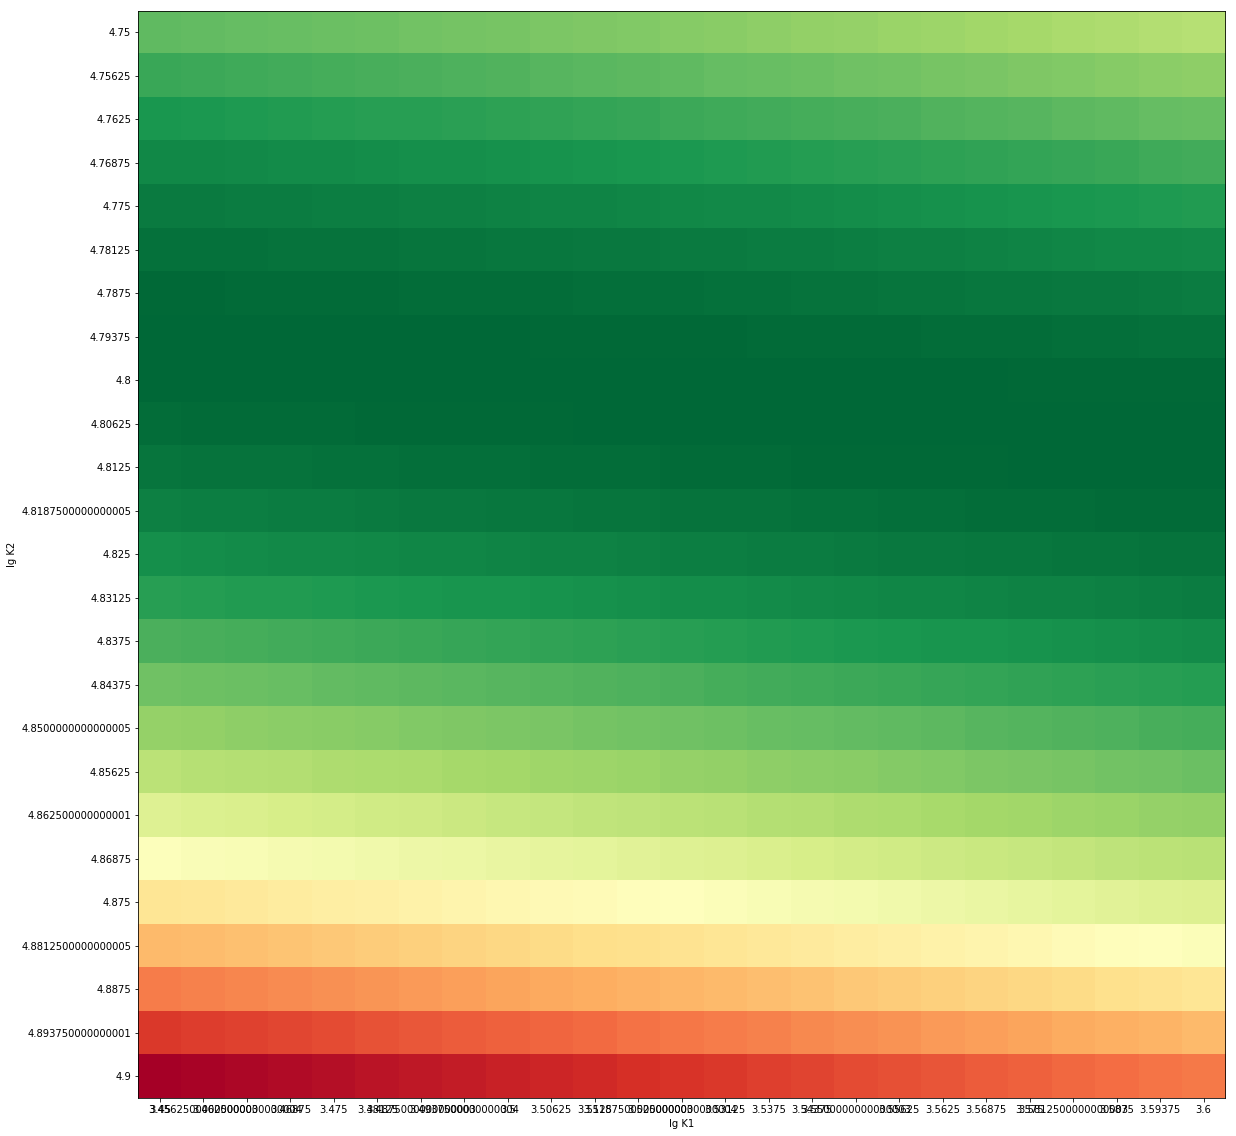

In [18]:
# heatmap : run --------------------------------------

#comment this section for reducing the waiting time

cl_htmp = cl_heatmap_fmin(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix, ign_indices
              , ser_num, ser_counts, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
              _calor_setup_type_coeff, _calor_setup_type, vol_init, _const_x, _const_y, _iterations)

with pd.ExcelWriter('../../output/calorimetry/' + _file_out, mode = "w") as output:
    cl_htmp.to_excel(output)

In [19]:
float("1e10")

10000000000.0